In [1]:
from IPython.display import clear_output
from typing import List, Optional

import datetime
import functools
import gpflow as gpf
import hydra
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import palettable
import tensorflow as tf
import tensor_annotations.tensorflow as ttf
import tensorflow_probability as tfp

from gpflow import default_float, default_jitter
from gpflow.conditionals import uncertain_conditional, base_conditional
from matplotlib import cm
from numpy import random
from omegaconf import DictConfig
from simenvs import make

from modeopt.cost_functions import ControlQuadraticCostFunction, TargetStateCostFunction, StateDiffCostFunction, quadratic_cost_fn
from modeopt.controllers.utils import initialise_deterministic_trajectory, build_mode_variational_objective
from modeopt.controllers import TrajectoryOptimisationController
from modeopt.constraints import build_mode_chance_constraints_scipy
from modeopt.custom_types import Dataset
from modeopt.dynamics.conditionals import svgp_covariance_conditional
from modeopt.plotting import ModeOptContourPlotter
from modeopt.rollouts import rollout_controls_in_dynamics, rollout_controller_in_dynamics, rollout_controller_in_env, collect_data_from_env
from modeopt.trajectories import ControlTrajectoryDist
from modeopt.utils import model_from_DictConfig, combine_state_controls_to_input, append_zero_control
from modeopt.mode_opt import ModeOpt
from mogpe.keras.callbacks.tensorboard import PlotFn, TensorboardImageCallback
from mogpe.keras.mixture_of_experts import MixtureOfSVGPExperts
from mogpe.keras.plotting import MixtureOfSVGPExpertsContourPlotter
from mogpe.keras.utils import sample_mosvgpe_inducing_inputs_from_data, model_from_yaml

%matplotlib inline

tfd = tfp.distributions

CMAP = palettable.scientific.sequential.Bilbao_15.mpl_colormap

meaning_of_life = 42
tf.random.set_seed(meaning_of_life)
np.random.seed(meaning_of_life)

## Initialise environment

In [2]:
env_name = "velocity-controlled-point-mass/scenario-7"

In [3]:
env = make(env_name)
state_dim = env.observation_spec().shape[0]
control_dim = env.action_spec().shape[0]

No constant_error found in toml config so using default : 0.0


## ModeOpt config

In [4]:
start_state = np.array([[-1.0, -2.0]])
target_state = np.array([[1.7, 3.0]])
mode_satisfaction_prob = 0.8

## Sample initial data set from desired mode

(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)


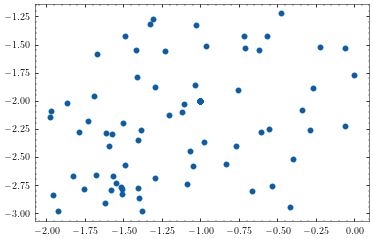

In [5]:
def sample_env_trajectories(horizon=15, num_trajectories=10):
    X, Y = [], []
    for i in range(num_trajectories):
        controls = np.random.uniform(
            env.action_spec().minimum,
            env.action_spec().maximum,
            (horizon, env.action_spec().shape[-1]),
        )
        X_, Y_ = collect_data_from_env(env, start_state=start_state, controls=controls)
        X.append(X_)
        Y.append(Y_)
    X = np.concatenate(X, 0)
    Y = np.concatenate(Y, 0)
    width = 1.0
    mask_1 = X[:, 0] > start_state[0, 0] - width
    mask_2 = X[:, 0] < start_state[0, 0] + width
    mask_3 = X[:, 1] > start_state[0, 1] - width
    mask_4 = X[:, 1] < start_state[0, 1] + width
    mask = mask_1 & mask_2 & mask_3 & mask_4
    X_trimmed = X[mask]
    Y_trimmed = Y[mask]
    print(X_trimmed.shape)
    print(Y_trimmed.shape)
    return (X_trimmed, Y_trimmed)

initial_dataset = sample_env_trajectories(horizon = 15, num_trajectories=50)
dataset = initial_dataset
plt.scatter(dataset[0][:, 0], dataset[0][:, 1])
plt.show()

## Train dynamics on initial data set or load from config

In [6]:
initial_num_epochs = 20000
# num_epochs = 300
num_epochs = 1500
# batch_size = 128
batch_size = initial_dataset[0].shape[0]
dynamics_logging_epoch_freq = 100

load_from_config = True
# load_from_config = False
yaml_cfg_filename = "./keras_configs/mode_opt_explore_scenario_7.yaml"
load_ckpt_dir = "./experiments/exploration-prob-0.8/2022-03-29-18-14/ckpts"
load_ckpt_dir = "./experiments/exploration-prob-0.8/2022-03-30-13-33/ckpts"
load_ckpt_dir = "./experiments/exploration-prob-0.8/2022-03-30-14-22/ckpts"

In [7]:
now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M') #  now
log_dir = os.path.join(f"./experiments/no-entropy-only-state-diff/explorative-prob-{mode_satisfaction_prob}", now_time)

In [8]:
if load_from_config:
    mode_optimiser = ModeOpt.load(load_ckpt_dir)
    mode_optimiser.log_dir = log_dir
else:
    mode_optimiser = model_from_yaml(yaml_cfg_filename, custom_objects={"ModeOpt": ModeOpt})
    mode_optimiser.dataset = (tf.constant(initial_dataset[0], dtype=default_float()),
                              tf.constant(initial_dataset[1], dtype=default_float())
                             )
    sample_mosvgpe_inducing_inputs_from_data(initial_dataset[0], mode_optimiser.dynamics.mosvgpe)
    mode_optimiser.dynamics_fit_kwargs.update({"epochs": initial_num_epochs, "batch_size": batch_size, "validation_split": 0.2})
#     dynamics_plotting_callbacks = build_contour_plotter_callbacks(mode_optimiser.dynamics.mosvgpe, logging_epoch_freq=dynamics_logging_epoch_freq, log_dir=mode_optimiser.log_dir)
#     mode_optimiser.add_dynamics_callbacks(dynamics_plotting_callbacks)
#     gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.inducing_variable, False)
    mode_optimiser.optimise_dynamics()
#     gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.kernel, False)

2022-04-08 17:31:33.832095: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


setting desired mode to 1
╒════════════════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════╤═════════╤══════════════════════════════════════════╕
│ name                                                           │ class     │ transform      │ prior   │ trainable   │ shape       │ dtype   │ value                                    │
╞════════════════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════╪═════════╪══════════════════════════════════════════╡
│ IndependentPosteriorMultiOutput.kernel.kernels[0].variance     │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.4978003107997662                       │
├────────────────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ IndependentPosteriorMultiOutput.kerne

2022-04-08 17:31:35.208367: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 17:31:35.208397: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-08 17:31:35.209623: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Update the data set.

In [9]:
mode_optimiser.start_state = tf.constant(start_state, dtype=default_float())

Set the correct desired dynamics mode.

In [10]:
def which_desired_mode(mode_optimiser, initial_dataset):
    probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs(initial_dataset[0])
    mean_probs = tf.reduce_mean(probs, 0)
    return int(tf.math.argmax(mean_probs))

desired_mode = which_desired_mode(mode_optimiser, initial_dataset)
print("Desired mode is {}".format(desired_mode))
mode_optimiser.desired_mode = desired_mode

Desired mode is 1


Save the learned dynamics model.

In [11]:
mode_optimiser.save()

## Configure the explorative controller

In [12]:
horizon = 15
max_iterations = 1000
keep_last_solution = True
method = "SLSQP"

In [13]:
terminal_state_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 100
state_diff_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 0.01
state_diff_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 1.0
# control_cost_matrix = tf.eye(control_dim, dtype=default_float()) * 0.1
# control_cost_matrix = tf.eye(control_dim, dtype=default_float()) * 0.5
control_cost_matrix = tf.eye(control_dim, dtype=default_float()) * 1.0

# terminal_cost_fn = TargetStateCostFunction(weight_matrix=terminal_state_cost_matrix, target_state=start_state)
terminal_cost_fn = TargetStateCostFunction(weight_matrix=terminal_state_cost_matrix, target_state=target_state)
control_cost_fn = ControlQuadraticCostFunction(weight_matrix=control_cost_matrix)
state_diff_cost_fn = StateDiffCostFunction(weight_matrix=state_diff_cost_matrix, target_state=target_state)

cost_fn = control_cost_fn + state_diff_cost_fn
# cost_fn = state_diff_cost_fn
# cost_fn = control_cost_fn
# cost_fn = control_cost_fn + state_diff_cost_fn + terminal_cost_fn
# cost_fn = state_diff_cost_fn
# cost_fn = terminal_cost_fn + state_diff_cost_fn

In [25]:
def explorative_objective(initial_solution: ControlTrajectoryDist) -> ttf.Tensor0:
    control_means = initial_solution(variance=False)
    control_vars = None
    state_means, state_vars = rollout_controls_in_dynamics(
        dynamics=mode_optimiser.dynamics,
        start_state=start_state,
        control_means=control_means,
        control_vars=control_vars,
    )
    return cost_fn(state_means, control_means, state_vars, control_vars)

In [15]:
def find_initial_solution_in_desired_mode():
    fake_target_state_in_mode_idx = np.random.choice(np.arange(len(mode_optimiser.dataset[0])), size=1)
    fake_target_state_in_mode = mode_optimiser.dataset[0][fake_target_state_in_mode_idx[0], :state_dim]
    fake_target_state_in_mode = tf.constant([[0, -1]], dtype=default_float())
    
    terminal_state_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 100.0
    control_cost_matrix = tf.eye(control_dim, dtype=default_float())
    
    terminal_cost_fn = TargetStateCostFunction(weight_matrix=terminal_state_cost_matrix, 
                                               target_state=fake_target_state_in_mode)
    control_cost_fn = ControlQuadraticCostFunction(weight_matrix=control_cost_matrix)
    initial_cost_fn = terminal_cost_fn + control_cost_fn

    initial_solution = initialise_deterministic_trajectory(horizon, control_dim)
    objective_fn = build_mode_variational_objective(mode_optimiser.dynamics, initial_cost_fn, start_state)
    explorative_controller = TrajectoryOptimisationController(
        max_iterations=max_iterations,
        initial_solution=initial_solution,
        objective_fn=objective_fn,
        method=method,
    )
    explorative_controller.optimise()
    return explorative_controller.previous_solution

initial_solution_in_mode = find_initial_solution_in_desired_mode()

2022-04-08 17:31:36.822963: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Xnew.shape
(256, 15, 4)
gating_means.shape
(256, 15, 1)
input_mean.shape
(15, 4)
(15, 4)
var_exp: Tensor("Sum_218:0", shape=(15, 1), dtype=float64)
mode_var_exp: Tensor("Sum_219:0", shape=(), dtype=float64)


2022-04-08 17:32:49.038889: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Optimisation result:
     fun: array([66.59696742])
     jac: array([2.69513992e-04, 7.56009729e-04, 5.53638984e-04, 6.17919925e-04,
       8.24734830e-05, 6.56961782e-04, 1.17365008e-04, 7.29399697e-04,
       4.05722417e-04, 7.39736557e-04, 4.61553437e-04, 6.91946622e-04,
       2.84344129e-04, 5.91346487e-04, 9.81022855e-05, 4.57220948e-04,
       7.90776870e-05, 4.21872280e-04, 1.69593489e-04, 5.53104525e-04,
       2.26450631e-04, 7.32156357e-04, 1.44979967e-04, 7.40807270e-04,
       7.21748549e-05, 4.30802069e-04, 1.85513109e-04, 2.63013167e-05,
       3.66076753e-04, 9.75111871e-05])
 message: 'Optimization terminated successfully'
    nfev: 32
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([-0.23821481,  2.13424601, -0.13510465,  1.95088118, -0.07097346,
        1.82675821, -0.02716002,  1.7448613 ,  0.00669778,  1.69276623,
        0.03689614,  1.66185601,  0.0678676 ,  1.64643057,  0.10312259,
        1.6430313 ,  0.14580199,  1.65000104,  0.1990902 ,  

In [26]:
mode_chance_constraints = build_mode_chance_constraints_scipy(mode_optimiser.dynamics, 
                                                              start_state, 
                                                              horizon, 
                                                              control_dim=control_dim,
                                                              lower_bound=mode_satisfaction_prob)
explorative_controller = TrajectoryOptimisationController(
    max_iterations=max_iterations,
    initial_solution=initial_solution_in_mode,
    objective_fn=explorative_objective,
    keep_last_solution=keep_last_solution,
    constraints=[mode_chance_constraints],
    method=method,
)
mode_optimiser.explorative_controller = explorative_controller

## Configure plotter

In [27]:
def create_test_inputs(x_min=[-3, -3], x_max=[3, 3], input_dim=4, num_test: int = 1600, factor: float = 1.2):
    sqrtN = int(np.sqrt(num_test))
    xx = np.linspace(x_min[0] * factor, x_max[0] * factor, sqrtN)
    yy = np.linspace(x_min[1] * factor, x_max[1] * factor, sqrtN)
    xx, yy = np.meshgrid(xx, yy)
    test_inputs = np.column_stack([xx.reshape(-1), yy.reshape(-1)])
    if input_dim > 2:
        zeros = np.zeros((num_test, input_dim - 2))
        test_inputs = np.concatenate([test_inputs, zeros], -1)
    return test_inputs, xx, yy

test_inputs, xx, yy = create_test_inputs()
plotter = ModeOptContourPlotter(mode_optimiser, test_inputs=test_inputs, static=False, explorative=True)

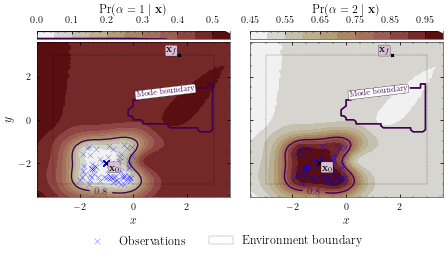

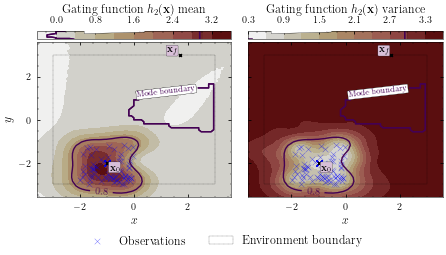

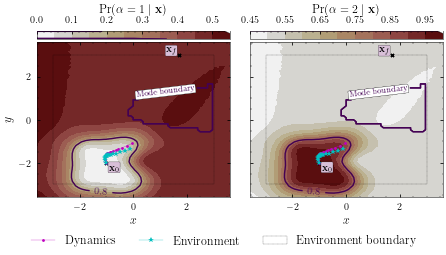

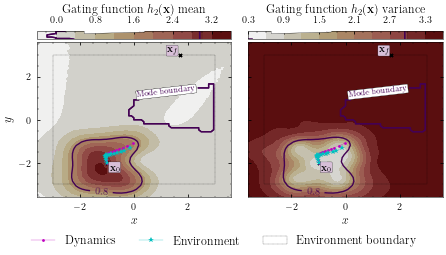

In [28]:
image_save_dir = os.path.join(mode_optimiser.log_dir, "images")
try:
    os.makedirs(image_save_dir)
except FileExistsError:
    pass

def plot_data_over_gating_network_and_save(step: int, epoch: int, save: bool = True):
    plotter.plot_data_over_mixing_probs()
    if save:
        save_filename = os.path.join(image_save_dir, "data_over_mixing_probs_step_{}_epoch_{}.pdf".format(step, epoch))
        plt.savefig(save_filename, transparent=True)
    
    plotter.plot_data_over_desired_gating_network_gp()
    if save:
        save_filename = os.path.join(image_save_dir, "data_over_desired_gating_gp_step_{}_epoch_{}.pdf".format(step, epoch))
        plt.savefig(save_filename, transparent=True)

def plot_trajectories_over_gating_network_and_save(step: int, save: bool = True):
    plotter.plot_trajectories_over_mixing_probs()
    if save:
        save_filename = os.path.join(image_save_dir, "trajectories_over_mixing_probs_step_{}.pdf".format(step))
        plt.savefig(save_filename, transparent=True)
    
    plotter.plot_trajectories_over_desired_gating_network_gp()
    if save:
        save_filename = os.path.join(image_save_dir, "trajectories_over_desired_gating_gp_step_{}.pdf".format(step))
        plt.savefig(save_filename, transparent=True)

plot_data_over_gating_network_and_save(step=0, epoch=0)
plot_trajectories_over_gating_network_and_save(step=0)

## Configure ModeOpt and callbacks

In [29]:
# mode_optimiser.dataset = (mode_optimiser.dataset[0][:130, :], mode_optimiser.dataset[1][:130, :])

In [30]:
# logging_epoch_freq = 60
num_epochs = 10000
logging_epoch_freq = math.floor((num_epochs)/5)
save_epoch_freq = math.floor((num_epochs)/5)
num_steps = 35
dataset = initial_dataset
# batch_size = 128
batch_size = mode_optimiser.dataset[0].shape[0]

mode_optimiser.dynamics_fit_kwargs.update({"epochs": num_epochs, "batch_size": batch_size, "validation_split": 0.2})
mode_optimiser.dynamics_fit_kwargs

{'epochs': 10000, 'batch_size': 125, 'validation_split': 0.2}

Callbacks for dynamics learning.

In [31]:
class PlottingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % logging_epoch_freq == 0:
            plot_data_over_gating_network_and_save(step=step, epoch=epoch)

class CustomSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % save_epoch_freq == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(os.path.join(mode_optimiser.ckpt_dir, "step_{}_epoch_{}".format(step, epoch)), save_format="tf")
            
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=500,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
callbacks = [PlottingCallback(),
             CustomSaver(),
             early_stopping_cb,
#              tf.keras.callbacks.ModelCheckpoint(
#                  filepath=os.path.join(save_dir + "ckpts/ModeOptDynamics"),
#                  monitor="loss",
#                  save_format="tf",
#                  save_best_only=False,
#                  save_freq=500),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir)
            ]

2022-04-08 17:42:23.871621: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 17:42:23.871645: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-08 17:42:23.871949: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [32]:
mode_optimiser.dynamics(dataset[0]) # call ModeOptDynamics to build it for saving
mode_optimiser.dynamics_callbacks = []
mode_optimiser.add_dynamics_callbacks(callbacks)

In [33]:
# gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.kernel, False)
# gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.experts_list[desired_mode].gp.kernel, False)

Optimisation result:
     fun: 362.66569114719044
     jac: array([-12.93137791, -16.27526919, -12.29095342, -16.85008189,
       -11.68306667, -17.01514805, -11.17585813, -16.80125141,
       -10.63704411, -15.98748848,  -9.87460747, -14.54685186,
        -9.01436597, -13.04485104,  -8.09210846, -11.49347334,
        -7.12967277,  -9.89416753,  -6.13819814,  -8.24684661,
        -5.11994927,  -6.55397172,  -4.065449  ,  -4.82545014,
        -2.95179867,  -3.08763878,  -1.73740197,  -1.429796  ,
        -0.47805622,  -0.19079622])
 message: 'Optimization terminated successfully'
    nfev: 26
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([ 1.31778147,  3.7652362 ,  0.94935952,  2.91928572,  0.59076344,
        2.22275362,  0.25911872,  1.68177289,  0.01457125,  1.41552842,
       -0.08148755,  1.44307999, -0.1318536 ,  1.46566013, -0.15551224,
        1.48047087, -0.16352645,  1.48888377, -0.16034285,  1.49171645,
       -0.14636276,  1.48831713, -0.11558135,  1.4

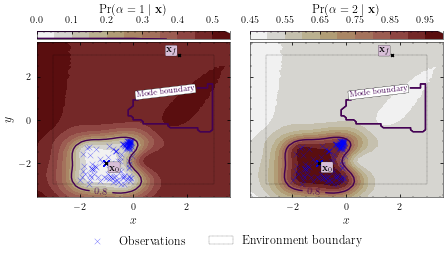

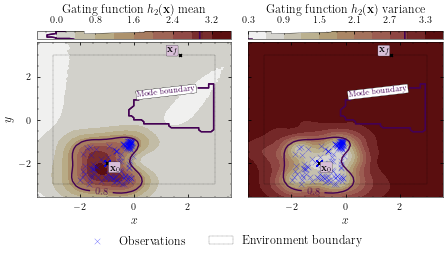

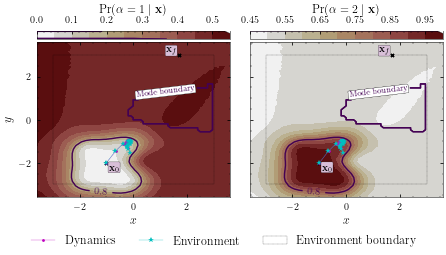

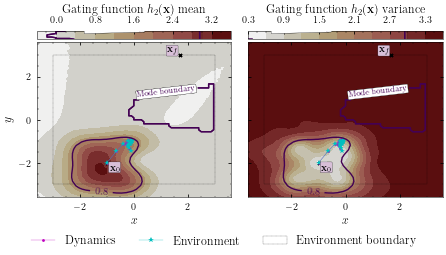

Epoch 1/10000
Mixing probs: (1, None, 2)
Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Experts probs: (None, None, 2)
Mixing probs: (1, None, 2)
Experts probs: (None, None, 2)
1/1 [==============================] - ETA: 0s - loss: -659.4299Mixing probs: (1, None, 2)
Experts probs: (None, None, 2)
1/1 [==============================] - 38s 38s/step - loss: -659.4299 - val_loss: -665.9807
Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_1_epoch_0/assets
Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -515.2938

2022-04-08 17:46:04.885628: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 17:46:04.885657: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-08 17:46:04.926781: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 17:46:05.009658: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 17:46:05.073730: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_17_46_05

2022-04-08 17:46:05.116810: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_17_46_05/dr-robots-mbp.local.trace.json.gz
2022-04-08 17:46:05.264602: I

1/1 [==============================] - 1s 517ms/step - loss: -515.2938 - val_loss: -523.8658
Epoch 3/10000
1/1 [==============================] - 0s 90ms/step - loss: -627.3585 - val_loss: -591.8223


2022-04-08 17:46:05.335122: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_17_46_05
Dumped tool data for xplane.pb to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_17_46_05/dr-robots-mbp.local.xplane.pb
Dumped tool data for overview_page.pb to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_17_46_05/dr-robots-mbp.local.overview_page.pb
Dumped tool data for input_pipeline.pb to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_17_46_05/dr-robots-mbp.local.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_17_46_05/dr-robots-mbp.local

Epoch 4/10000
1/1 [==============================] - 0s 122ms/step - loss: -644.8045 - val_loss: -608.0436
Epoch 5/10000
1/1 [==============================] - 0s 102ms/step - loss: -612.6935 - val_loss: -600.9499
Epoch 6/10000
1/1 [==============================] - 0s 93ms/step - loss: -615.3341 - val_loss: -537.3269
Epoch 7/10000
1/1 [==============================] - 0s 90ms/step - loss: -595.4945 - val_loss: -678.5027
Epoch 8/10000
1/1 [==============================] - 0s 105ms/step - loss: -651.0369 - val_loss: -727.7035
Epoch 9/10000
1/1 [==============================] - 0s 91ms/step - loss: -665.8309 - val_loss: -694.4417
Epoch 10/10000
1/1 [==============================] - 0s 89ms/step - loss: -671.7522 - val_loss: -742.3395
Epoch 11/10000
1/1 [==============================] - 0s 86ms/step - loss: -635.9439 - val_loss: -735.0957
Epoch 12/10000
1/1 [==============================] - 0s 89ms/step - loss: -615.3163 - val_loss: -662.0287
Epoch 13/10000
1/1 [====================

1/1 [==============================] - 0s 75ms/step - loss: -537.4840 - val_loss: -694.4827
Epoch 157/10000
1/1 [==============================] - 0s 74ms/step - loss: -614.5165 - val_loss: -675.9603
Epoch 158/10000
1/1 [==============================] - 0s 75ms/step - loss: -559.9926 - val_loss: -660.9168
Epoch 159/10000
1/1 [==============================] - 0s 83ms/step - loss: -571.3801 - val_loss: -661.1569
Epoch 160/10000
1/1 [==============================] - 0s 79ms/step - loss: -455.6255 - val_loss: -539.1644
Epoch 161/10000
1/1 [==============================] - 0s 88ms/step - loss: -607.7056 - val_loss: -695.9117
Epoch 162/10000
1/1 [==============================] - 0s 81ms/step - loss: -614.2544 - val_loss: -655.0187
Epoch 163/10000
1/1 [==============================] - 0s 82ms/step - loss: -592.0388 - val_loss: -646.0302
Epoch 164/10000
1/1 [==============================] - 0s 116ms/step - loss: -561.8283 - val_loss: -700.8977
Epoch 165/10000
1/1 [======================

Epoch 232/10000
1/1 [==============================] - 0s 74ms/step - loss: -777.7705 - val_loss: -858.4332
Epoch 233/10000
1/1 [==============================] - 0s 78ms/step - loss: -785.0688 - val_loss: -859.8542
Epoch 234/10000
1/1 [==============================] - 0s 91ms/step - loss: -785.6740 - val_loss: -885.4637
Epoch 235/10000
1/1 [==============================] - 0s 70ms/step - loss: -705.9438 - val_loss: -860.6694
Epoch 236/10000
1/1 [==============================] - 0s 72ms/step - loss: -592.8661 - val_loss: -759.5030
Epoch 237/10000
1/1 [==============================] - 0s 67ms/step - loss: -719.1908 - val_loss: -885.1460
Epoch 238/10000
1/1 [==============================] - 0s 69ms/step - loss: -801.3035 - val_loss: -904.9299
Epoch 239/10000
1/1 [==============================] - 0s 71ms/step - loss: -751.9171 - val_loss: -816.1321
Epoch 240/10000
1/1 [==============================] - 0s 72ms/step - loss: -728.7122 - val_loss: -856.1735
Epoch 241/10000
1/1 [=======

Epoch 308/10000
1/1 [==============================] - 0s 69ms/step - loss: -715.9751 - val_loss: -666.5344
Epoch 309/10000
1/1 [==============================] - 0s 96ms/step - loss: -690.3526 - val_loss: -500.1604
Epoch 310/10000
1/1 [==============================] - 0s 69ms/step - loss: -676.1246 - val_loss: -730.5410
Epoch 311/10000
1/1 [==============================] - 0s 73ms/step - loss: -708.4412 - val_loss: -766.7774
Epoch 312/10000
1/1 [==============================] - 0s 81ms/step - loss: -474.2853 - val_loss: -597.6255
Epoch 313/10000
1/1 [==============================] - 0s 74ms/step - loss: -347.2310 - val_loss: -293.1690
Epoch 314/10000
1/1 [==============================] - 0s 75ms/step - loss: -562.0895 - val_loss: -483.8685
Epoch 315/10000
1/1 [==============================] - 0s 66ms/step - loss: -721.3301 - val_loss: -816.3466
Epoch 316/10000
1/1 [==============================] - 0s 58ms/step - loss: -628.5531 - val_loss: -790.8172
Epoch 317/10000
1/1 [=======

Epoch 384/10000
1/1 [==============================] - 0s 62ms/step - loss: -383.8529 - val_loss: -494.4536
Epoch 385/10000
1/1 [==============================] - 0s 66ms/step - loss: -696.1774 - val_loss: -783.7219
Epoch 386/10000
1/1 [==============================] - 0s 64ms/step - loss: -573.7312 - val_loss: -816.9644
Epoch 387/10000
1/1 [==============================] - 0s 63ms/step - loss: -360.7007 - val_loss: -721.9658
Epoch 388/10000
1/1 [==============================] - 0s 68ms/step - loss: -616.8288 - val_loss: -720.2406
Epoch 389/10000
1/1 [==============================] - 0s 69ms/step - loss: -573.9607 - val_loss: -750.0787
Epoch 390/10000
1/1 [==============================] - 0s 64ms/step - loss: -495.1547 - val_loss: -685.8061
Epoch 391/10000
1/1 [==============================] - 0s 65ms/step - loss: -492.1469 - val_loss: -610.1845
Epoch 392/10000
1/1 [==============================] - 0s 57ms/step - loss: -500.1823 - val_loss: -735.8657
Epoch 393/10000
1/1 [=======

Epoch 460/10000
1/1 [==============================] - 0s 62ms/step - loss: -609.0283 - val_loss: -608.1727
Epoch 461/10000
1/1 [==============================] - 0s 65ms/step - loss: -631.8232 - val_loss: -719.0400
Epoch 462/10000
1/1 [==============================] - 0s 71ms/step - loss: -653.6704 - val_loss: -716.3027
Epoch 463/10000
1/1 [==============================] - 0s 69ms/step - loss: -707.7878 - val_loss: -730.7046
Epoch 464/10000
1/1 [==============================] - 0s 64ms/step - loss: -666.7451 - val_loss: -721.2375
Epoch 465/10000
1/1 [==============================] - 0s 71ms/step - loss: -698.2054 - val_loss: -743.4079
Epoch 466/10000
1/1 [==============================] - 0s 62ms/step - loss: -689.0332 - val_loss: -716.1773
Epoch 467/10000
1/1 [==============================] - 0s 69ms/step - loss: -699.9945 - val_loss: -760.5606
Epoch 468/10000
1/1 [==============================] - 0s 71ms/step - loss: -745.1499 - val_loss: -799.4131
Epoch 469/10000
1/1 [=======

Epoch 536/10000
1/1 [==============================] - 0s 72ms/step - loss: -557.1869 - val_loss: -564.2042
Epoch 537/10000
1/1 [==============================] - 0s 58ms/step - loss: -659.3784 - val_loss: -617.6706
Epoch 538/10000
1/1 [==============================] - 0s 67ms/step - loss: -344.3194 - val_loss: -808.6433
Epoch 539/10000
1/1 [==============================] - 0s 68ms/step - loss: -311.8299 - val_loss: -464.3013
Epoch 540/10000
1/1 [==============================] - 0s 69ms/step - loss: -686.4397 - val_loss: -756.1729
Epoch 541/10000
1/1 [==============================] - 0s 66ms/step - loss: -684.5092 - val_loss: -628.4840
Epoch 542/10000
1/1 [==============================] - 0s 63ms/step - loss: -646.0062 - val_loss: -576.9065
Epoch 543/10000
1/1 [==============================] - 0s 62ms/step - loss: -669.4808 - val_loss: -865.7927
Epoch 544/10000
1/1 [==============================] - 0s 52ms/step - loss: -576.0081 - val_loss: -767.3272
Epoch 545/10000
1/1 [=======

Epoch 612/10000
1/1 [==============================] - 0s 68ms/step - loss: -644.3219 - val_loss: -768.1504
Epoch 613/10000
1/1 [==============================] - 0s 55ms/step - loss: -650.0430 - val_loss: -781.6675
Epoch 614/10000
1/1 [==============================] - 0s 55ms/step - loss: -651.9560 - val_loss: -636.2775
Epoch 615/10000
1/1 [==============================] - 0s 61ms/step - loss: -764.0173 - val_loss: -802.8571
Epoch 616/10000
1/1 [==============================] - 0s 60ms/step - loss: -727.1704 - val_loss: -795.8655
Epoch 617/10000
1/1 [==============================] - 0s 63ms/step - loss: -570.4372 - val_loss: -591.4997
Epoch 618/10000
1/1 [==============================] - 0s 56ms/step - loss: -731.1074 - val_loss: -746.4213
Epoch 619/10000
1/1 [==============================] - 0s 55ms/step - loss: -718.5409 - val_loss: -762.4956
Epoch 620/10000
1/1 [==============================] - 0s 59ms/step - loss: -715.4626 - val_loss: -825.0302
Epoch 621/10000
1/1 [=======

Epoch 688/10000
1/1 [==============================] - 0s 67ms/step - loss: -705.2444 - val_loss: -817.7049
Epoch 689/10000
1/1 [==============================] - 0s 65ms/step - loss: -721.0893 - val_loss: -786.0775
Epoch 690/10000
1/1 [==============================] - 0s 67ms/step - loss: -705.9194 - val_loss: -820.5023
Epoch 691/10000
1/1 [==============================] - 0s 68ms/step - loss: -678.4967 - val_loss: -805.6654
Epoch 692/10000
1/1 [==============================] - 0s 64ms/step - loss: -713.3537 - val_loss: -782.0160
Epoch 693/10000
1/1 [==============================] - 0s 71ms/step - loss: -745.9937 - val_loss: -821.9699
Epoch 694/10000
1/1 [==============================] - 0s 72ms/step - loss: -707.3883 - val_loss: -780.5112
Epoch 695/10000
1/1 [==============================] - 0s 73ms/step - loss: -750.6781 - val_loss: -788.8146
Epoch 696/10000
1/1 [==============================] - 0s 66ms/step - loss: -754.7070 - val_loss: -814.9258
Epoch 697/10000
1/1 [=======

Epoch 764/10000
1/1 [==============================] - 0s 68ms/step - loss: -528.8759 - val_loss: -644.8727
Epoch 765/10000
1/1 [==============================] - 0s 80ms/step - loss: -628.9569 - val_loss: -606.2614
Epoch 766/10000
1/1 [==============================] - 0s 73ms/step - loss: -708.8443 - val_loss: -701.0495
Epoch 767/10000
1/1 [==============================] - 0s 76ms/step - loss: 128.1873 - val_loss: -636.0883
Epoch 768/10000
1/1 [==============================] - 0s 67ms/step - loss: 288.7315 - val_loss: -584.5355
Epoch 769/10000
1/1 [==============================] - 0s 64ms/step - loss: 344.9323 - val_loss: -714.9532
Epoch 770/10000
1/1 [==============================] - 0s 61ms/step - loss: -596.5566 - val_loss: -598.4922
Epoch 771/10000
1/1 [==============================] - 0s 64ms/step - loss: -311.9690 - val_loss: -588.5110
Epoch 772/10000
1/1 [==============================] - 0s 68ms/step - loss: -416.0396 - val_loss: -722.0913
Epoch 773/10000
1/1 [==========

Epoch 840/10000
1/1 [==============================] - 0s 83ms/step - loss: -723.8276 - val_loss: -742.9524
Epoch 841/10000
1/1 [==============================] - 0s 72ms/step - loss: -776.4216 - val_loss: -834.3572
Epoch 842/10000
1/1 [==============================] - 0s 72ms/step - loss: -711.2765 - val_loss: -824.8524
Epoch 843/10000
1/1 [==============================] - 0s 78ms/step - loss: -768.0825 - val_loss: -803.1991
Epoch 844/10000
1/1 [==============================] - 0s 72ms/step - loss: -760.5234 - val_loss: -779.8578
Epoch 845/10000
1/1 [==============================] - 0s 72ms/step - loss: -760.1162 - val_loss: -800.1866
Epoch 846/10000
1/1 [==============================] - 0s 77ms/step - loss: -770.9526 - val_loss: -839.5897
Epoch 847/10000
1/1 [==============================] - 0s 86ms/step - loss: -773.9599 - val_loss: -833.8743
Epoch 848/10000
1/1 [==============================] - 0s 76ms/step - loss: -781.0464 - val_loss: -856.7177
Epoch 849/10000
1/1 [=======

Epoch 916/10000
1/1 [==============================] - 0s 97ms/step - loss: -707.9118 - val_loss: -850.1334
Epoch 917/10000
1/1 [==============================] - 0s 84ms/step - loss: -694.8043 - val_loss: -782.4322
Epoch 918/10000
1/1 [==============================] - 0s 83ms/step - loss: -708.6882 - val_loss: -842.0245
Epoch 919/10000
1/1 [==============================] - 0s 67ms/step - loss: -703.3252 - val_loss: -784.8097
Epoch 920/10000
1/1 [==============================] - 0s 67ms/step - loss: -691.5592 - val_loss: -753.1484
Epoch 921/10000
1/1 [==============================] - 0s 92ms/step - loss: -734.8544 - val_loss: -625.8493
Epoch 922/10000
1/1 [==============================] - 0s 99ms/step - loss: -756.6400 - val_loss: -783.7550
Epoch 923/10000
1/1 [==============================] - 0s 81ms/step - loss: -750.3536 - val_loss: -793.1661
Epoch 924/10000
1/1 [==============================] - 0s 79ms/step - loss: -667.8420 - val_loss: -727.0941
Epoch 925/10000
1/1 [=======

Epoch 992/10000
1/1 [==============================] - 0s 59ms/step - loss: -610.8508 - val_loss: -635.4049
Epoch 993/10000
1/1 [==============================] - 0s 61ms/step - loss: -734.1593 - val_loss: -810.4770
Epoch 994/10000
1/1 [==============================] - 0s 61ms/step - loss: -755.0495 - val_loss: -827.7651
Epoch 995/10000
1/1 [==============================] - 0s 62ms/step - loss: -668.4246 - val_loss: -775.2761
Epoch 996/10000
1/1 [==============================] - 0s 60ms/step - loss: -783.6238 - val_loss: -783.4103
Epoch 997/10000
1/1 [==============================] - 0s 58ms/step - loss: -715.1874 - val_loss: -835.4752
Epoch 998/10000
1/1 [==============================] - 0s 58ms/step - loss: -698.7428 - val_loss: -859.9462
Epoch 999/10000
1/1 [==============================] - 0s 61ms/step - loss: -813.3496 - val_loss: -817.8991
Epoch 1000/10000
1/1 [==============================] - 0s 61ms/step - loss: -723.5902 - val_loss: -795.5759
Epoch 1001/10000
1/1 [=====

Epoch 1067/10000
1/1 [==============================] - 0s 53ms/step - loss: -794.7780 - val_loss: -862.5143
Epoch 1068/10000
1/1 [==============================] - 0s 42ms/step - loss: -669.3137 - val_loss: -654.4513
Epoch 1069/10000
1/1 [==============================] - 0s 42ms/step - loss: -765.1265 - val_loss: -878.1965
Epoch 1070/10000
1/1 [==============================] - 0s 44ms/step - loss: -415.3228 - val_loss: -581.4151
Epoch 1071/10000
1/1 [==============================] - 0s 44ms/step - loss: -417.7716 - val_loss: -272.9942
Epoch 1072/10000
1/1 [==============================] - 0s 45ms/step - loss: -698.7234 - val_loss: -786.4045
Epoch 1073/10000
1/1 [==============================] - 0s 43ms/step - loss: -810.7428 - val_loss: -735.3168
Epoch 1074/10000
1/1 [==============================] - 0s 43ms/step - loss: -553.4477 - val_loss: -467.1036
Epoch 1075/10000
1/1 [==============================] - 0s 42ms/step - loss: -582.1213 - val_loss: -713.8247
Epoch 1076/10000
1/

1/1 [==============================] - 0s 42ms/step - loss: -477.6288 - val_loss: -650.6841
Epoch 1218/10000
1/1 [==============================] - 0s 43ms/step - loss: -769.4243 - val_loss: -715.4438
Epoch 1219/10000
1/1 [==============================] - 0s 43ms/step - loss: -795.7360 - val_loss: -832.2846
Epoch 1220/10000
1/1 [==============================] - 0s 44ms/step - loss: -597.4542 - val_loss: -669.3746
Epoch 1221/10000
1/1 [==============================] - 0s 45ms/step - loss: -642.2243 - val_loss: -776.4387
Epoch 1222/10000
1/1 [==============================] - 0s 43ms/step - loss: -775.3097 - val_loss: -799.1933
Epoch 1223/10000
1/1 [==============================] - 0s 44ms/step - loss: -746.6011 - val_loss: -845.4589
Epoch 1224/10000
1/1 [==============================] - 0s 41ms/step - loss: -780.0790 - val_loss: -864.8284
Epoch 1225/10000
1/1 [==============================] - 0s 40ms/step - loss: -777.1540 - val_loss: -855.3271
Epoch 1226/10000
1/1 [==============

1/1 [==============================] - 0s 41ms/step - loss: -796.4842 - val_loss: -878.8415
Epoch 1368/10000
1/1 [==============================] - 0s 40ms/step - loss: -809.2364 - val_loss: -832.0388
Epoch 1369/10000
1/1 [==============================] - 0s 38ms/step - loss: -820.0992 - val_loss: -846.8626
Epoch 1370/10000
1/1 [==============================] - 0s 41ms/step - loss: -799.7268 - val_loss: -870.7936
Epoch 1371/10000
1/1 [==============================] - 0s 39ms/step - loss: -678.7386 - val_loss: -821.1998
Epoch 1372/10000
1/1 [==============================] - 0s 39ms/step - loss: -760.4364 - val_loss: -799.9928
Epoch 1373/10000
1/1 [==============================] - 0s 37ms/step - loss: -787.6183 - val_loss: -845.0601
Epoch 1374/10000
1/1 [==============================] - 0s 37ms/step - loss: -782.6927 - val_loss: -852.4490
Epoch 1375/10000
1/1 [==============================] - 0s 38ms/step - loss: -818.6577 - val_loss: -850.2218
Epoch 1376/10000
1/1 [==============

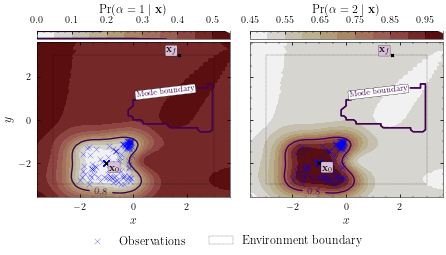

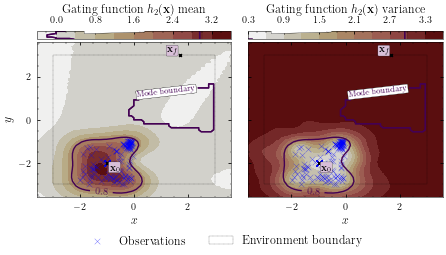

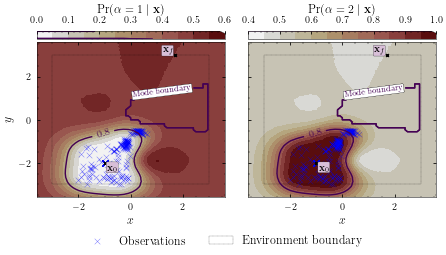

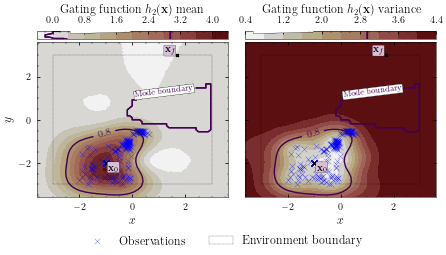

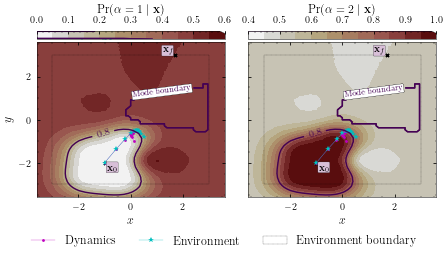

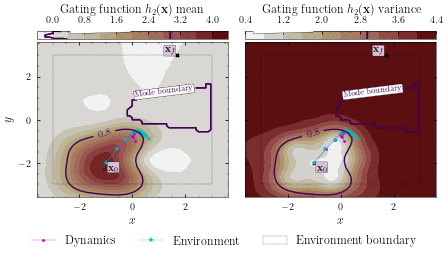

Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: -788.5797 - val_loss: -667.9865


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_2_epoch_0/assets
Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -805.1168

2022-04-08 17:50:32.449665: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 17:50:32.449720: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-08 17:50:38.044701: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 17:50:38.093654: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 17:50:38.124226: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_17_50_38

2022-04-08 17:50:38.139732: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_17_50_38/dr-robots-mbp.local.trace.json.gz
2022-04-08 17:50:38.211619: I

1/1 [==============================] - 6s 6s/step - loss: -805.1168 - val_loss: -667.0376
Epoch 3/10000
1/1 [==============================] - ETA: 0s - loss: -504.5060

2022-04-08 17:50:38.261947: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_17_50_38
Dumped tool data for xplane.pb to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_17_50_38/dr-robots-mbp.local.xplane.pb
Dumped tool data for overview_page.pb to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_17_50_38/dr-robots-mbp.local.overview_page.pb
Dumped tool data for input_pipeline.pb to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_17_50_38/dr-robots-mbp.local.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_17_50_38/dr-robots-mbp.local

1/1 [==============================] - 0s 101ms/step - loss: -504.5060 - val_loss: -676.0541
Epoch 4/10000
1/1 [==============================] - 0s 102ms/step - loss: -577.7963 - val_loss: -708.6516
Epoch 5/10000
1/1 [==============================] - 0s 98ms/step - loss: -805.6509 - val_loss: -692.2121
Epoch 6/10000
1/1 [==============================] - 0s 73ms/step - loss: -691.3588 - val_loss: -359.9253
Epoch 7/10000
1/1 [==============================] - 0s 84ms/step - loss: -685.8285 - val_loss: -612.7151
Epoch 8/10000
1/1 [==============================] - 0s 87ms/step - loss: -602.2965 - val_loss: -715.1633
Epoch 9/10000
1/1 [==============================] - 0s 88ms/step - loss: -646.9634 - val_loss: -716.3740
Epoch 10/10000
1/1 [==============================] - 0s 97ms/step - loss: -796.1943 - val_loss: -737.3750
Epoch 11/10000
1/1 [==============================] - 0s 94ms/step - loss: -819.2357 - val_loss: -644.6571
Epoch 12/10000
1/1 [==============================] - 0s

Epoch 155/10000
1/1 [==============================] - 0s 92ms/step - loss: -636.1192 - val_loss: -732.1259
Epoch 156/10000
1/1 [==============================] - 0s 84ms/step - loss: -745.2174 - val_loss: -753.9832
Epoch 157/10000
1/1 [==============================] - 0s 91ms/step - loss: -484.8089 - val_loss: -720.3518
Epoch 158/10000
1/1 [==============================] - 0s 76ms/step - loss: -640.7180 - val_loss: -718.7240
Epoch 159/10000
1/1 [==============================] - 0s 87ms/step - loss: -658.0056 - val_loss: -745.2847
Epoch 160/10000
1/1 [==============================] - 0s 96ms/step - loss: -630.2967 - val_loss: -753.8377
Epoch 161/10000
1/1 [==============================] - 0s 94ms/step - loss: -490.5212 - val_loss: -737.4978
Epoch 162/10000
1/1 [==============================] - 0s 100ms/step - loss: -648.8030 - val_loss: -671.1878
Epoch 163/10000
1/1 [==============================] - 0s 96ms/step - loss: -624.8450 - val_loss: -717.1800
Epoch 164/10000
1/1 [======

Epoch 306/10000
1/1 [==============================] - 0s 76ms/step - loss: -325.7302 - val_loss: -310.7489
Epoch 307/10000
1/1 [==============================] - 0s 96ms/step - loss: -495.3820 - val_loss: -672.1290
Epoch 308/10000
1/1 [==============================] - 0s 78ms/step - loss: -362.3162 - val_loss: -576.9114
Epoch 309/10000
1/1 [==============================] - 0s 84ms/step - loss: -729.6293 - val_loss: -792.3153
Epoch 310/10000
1/1 [==============================] - 0s 92ms/step - loss: -582.2717 - val_loss: -729.1598
Epoch 311/10000
1/1 [==============================] - 0s 86ms/step - loss: -728.6456 - val_loss: -716.1057
Epoch 312/10000
1/1 [==============================] - 0s 85ms/step - loss: -697.2274 - val_loss: -626.6413
Epoch 313/10000
1/1 [==============================] - 0s 67ms/step - loss: -387.1626 - val_loss: -497.9941
Epoch 314/10000
1/1 [==============================] - 0s 75ms/step - loss: -357.0840 - val_loss: -704.7621
Epoch 315/10000
1/1 [=======

Epoch 382/10000
1/1 [==============================] - 0s 114ms/step - loss: -268.3887 - val_loss: -490.8240
Epoch 383/10000
1/1 [==============================] - 0s 113ms/step - loss: -666.2794 - val_loss: -661.5346
Epoch 384/10000
1/1 [==============================] - 0s 82ms/step - loss: -667.7060 - val_loss: -635.8591
Epoch 385/10000
1/1 [==============================] - 0s 87ms/step - loss: -522.9436 - val_loss: -412.6996
Epoch 386/10000
1/1 [==============================] - 0s 112ms/step - loss: -517.5584 - val_loss: -436.3434
Epoch 387/10000
1/1 [==============================] - 0s 82ms/step - loss: -602.2997 - val_loss: -509.6178
Epoch 388/10000
1/1 [==============================] - 0s 89ms/step - loss: -466.7447 - val_loss: -511.2608
Epoch 389/10000
1/1 [==============================] - 0s 113ms/step - loss: 229.0593 - val_loss: -171.6111
Epoch 390/10000
1/1 [==============================] - 0s 95ms/step - loss: -525.7816 - val_loss: -541.8838
Epoch 391/10000
1/1 [====

Epoch 458/10000
1/1 [==============================] - 0s 73ms/step - loss: -774.8599 - val_loss: -715.2359
Epoch 459/10000
1/1 [==============================] - 0s 69ms/step - loss: -784.5707 - val_loss: -717.6675
Epoch 460/10000
1/1 [==============================] - 0s 73ms/step - loss: -742.8512 - val_loss: -734.3345
Epoch 461/10000
1/1 [==============================] - 0s 101ms/step - loss: -762.9505 - val_loss: -718.8412
Epoch 462/10000
1/1 [==============================] - 0s 82ms/step - loss: -683.9807 - val_loss: -728.2327
Epoch 463/10000
1/1 [==============================] - 0s 78ms/step - loss: -774.4158 - val_loss: -693.9890
Epoch 464/10000
1/1 [==============================] - 0s 101ms/step - loss: -607.8303 - val_loss: -686.9406
Epoch 465/10000
1/1 [==============================] - 0s 68ms/step - loss: -765.4339 - val_loss: -733.7154
Epoch 466/10000
1/1 [==============================] - 0s 77ms/step - loss: -801.0442 - val_loss: -743.7226
Epoch 467/10000
1/1 [=====

Epoch 534/10000
1/1 [==============================] - 0s 86ms/step - loss: -789.3643 - val_loss: -712.6158
Epoch 535/10000
1/1 [==============================] - 0s 101ms/step - loss: 520.5196 - val_loss: 541.7144
Epoch 536/10000
1/1 [==============================] - 0s 97ms/step - loss: 16.6462 - val_loss: -243.3727
Epoch 537/10000
1/1 [==============================] - 0s 80ms/step - loss: -407.3468 - val_loss: -562.2898
Epoch 538/10000
1/1 [==============================] - 0s 89ms/step - loss: 522.0883 - val_loss: 903.4132
Epoch 539/10000
1/1 [==============================] - 0s 121ms/step - loss: 148.9361 - val_loss: 525.8304
Epoch 540/10000
1/1 [==============================] - 0s 116ms/step - loss: -673.9439 - val_loss: -670.9440
Epoch 541/10000
1/1 [==============================] - 0s 112ms/step - loss: -553.0744 - val_loss: -601.1787
Epoch 542/10000
1/1 [==============================] - 0s 91ms/step - loss: -352.6749 - val_loss: -405.8701
Epoch 543/10000
1/1 [===========

Epoch 610/10000
1/1 [==============================] - 0s 61ms/step - loss: -641.5184 - val_loss: -641.3171
Epoch 611/10000
1/1 [==============================] - 0s 81ms/step - loss: -628.4658 - val_loss: -628.8616
Epoch 612/10000
1/1 [==============================] - 0s 76ms/step - loss: -639.3805 - val_loss: -618.4450
Epoch 613/10000
1/1 [==============================] - 0s 63ms/step - loss: -655.9920 - val_loss: -630.3743
Epoch 614/10000
1/1 [==============================] - 0s 74ms/step - loss: -678.1439 - val_loss: -638.2444
Epoch 615/10000
1/1 [==============================] - 0s 74ms/step - loss: -663.2110 - val_loss: -638.1641
Epoch 616/10000
1/1 [==============================] - 0s 80ms/step - loss: -556.7677 - val_loss: -618.4839
Epoch 617/10000
1/1 [==============================] - 0s 72ms/step - loss: -654.0918 - val_loss: -627.1637
Epoch 618/10000
1/1 [==============================] - 0s 80ms/step - loss: -618.4530 - val_loss: -651.7001
Epoch 619/10000
1/1 [=======

Epoch 686/10000
1/1 [==============================] - 0s 136ms/step - loss: -739.2021 - val_loss: -727.5701
Epoch 687/10000
1/1 [==============================] - 0s 78ms/step - loss: -685.0909 - val_loss: -783.9126
Epoch 688/10000
1/1 [==============================] - 0s 71ms/step - loss: -708.3311 - val_loss: -743.1547
Epoch 689/10000
1/1 [==============================] - 0s 76ms/step - loss: -760.4407 - val_loss: -791.5881
Epoch 690/10000
1/1 [==============================] - 0s 71ms/step - loss: -774.5988 - val_loss: -773.5370
Epoch 691/10000
1/1 [==============================] - 0s 92ms/step - loss: -780.4519 - val_loss: -788.9582
Epoch 692/10000
1/1 [==============================] - 0s 106ms/step - loss: -795.7059 - val_loss: -765.3618
Epoch 693/10000
1/1 [==============================] - 0s 68ms/step - loss: -813.1086 - val_loss: -785.9848
Epoch 694/10000
1/1 [==============================] - 0s 102ms/step - loss: -817.6584 - val_loss: -752.3551
Epoch 695/10000
1/1 [====

Epoch 762/10000
1/1 [==============================] - 0s 66ms/step - loss: -788.6675 - val_loss: -772.0808
Epoch 763/10000
1/1 [==============================] - 0s 76ms/step - loss: -480.6547 - val_loss: -505.2556
Epoch 764/10000
1/1 [==============================] - 0s 82ms/step - loss: -700.7984 - val_loss: -635.9670
Epoch 765/10000
1/1 [==============================] - 0s 68ms/step - loss: -654.6229 - val_loss: -758.7373
Epoch 766/10000
1/1 [==============================] - 0s 68ms/step - loss: -631.6596 - val_loss: -704.5254
Epoch 767/10000
1/1 [==============================] - 0s 72ms/step - loss: -536.2974 - val_loss: -690.1516
Epoch 768/10000
1/1 [==============================] - 0s 66ms/step - loss: -738.8644 - val_loss: -756.2822
Epoch 769/10000
1/1 [==============================] - 0s 68ms/step - loss: -784.2249 - val_loss: -734.5723
Epoch 770/10000
1/1 [==============================] - 0s 59ms/step - loss: -695.4350 - val_loss: -767.4529
Epoch 771/10000
1/1 [=======

Epoch 838/10000
1/1 [==============================] - 0s 61ms/step - loss: -749.4683 - val_loss: -727.2782
Epoch 839/10000
1/1 [==============================] - 0s 67ms/step - loss: -676.6585 - val_loss: -726.0518
Epoch 840/10000
1/1 [==============================] - 0s 77ms/step - loss: -685.9377 - val_loss: -730.8268
Epoch 841/10000
1/1 [==============================] - 0s 54ms/step - loss: -708.0322 - val_loss: -633.0386
Epoch 842/10000
1/1 [==============================] - 0s 54ms/step - loss: -723.4910 - val_loss: -689.0122
Epoch 843/10000
1/1 [==============================] - 0s 59ms/step - loss: -735.8263 - val_loss: -718.7983
Epoch 844/10000
1/1 [==============================] - 0s 60ms/step - loss: -694.5227 - val_loss: -664.5864
Epoch 845/10000
1/1 [==============================] - 0s 57ms/step - loss: -719.3825 - val_loss: -695.4642
Epoch 846/10000
1/1 [==============================] - 0s 56ms/step - loss: -707.4907 - val_loss: -724.4315
Epoch 847/10000
1/1 [=======

Epoch 914/10000
1/1 [==============================] - 0s 60ms/step - loss: -706.2980 - val_loss: -592.9584
Epoch 915/10000
1/1 [==============================] - 0s 53ms/step - loss: -718.4737 - val_loss: -771.0124
Epoch 916/10000
1/1 [==============================] - 0s 52ms/step - loss: -595.6487 - val_loss: -728.2091
Epoch 917/10000
1/1 [==============================] - 0s 61ms/step - loss: -683.6360 - val_loss: -739.6904
Epoch 918/10000
1/1 [==============================] - 0s 59ms/step - loss: -821.7432 - val_loss: -814.1720
Epoch 919/10000
1/1 [==============================] - 0s 71ms/step - loss: -734.1091 - val_loss: -769.8176
Epoch 920/10000
1/1 [==============================] - 0s 62ms/step - loss: -612.8385 - val_loss: -769.3975
Epoch 921/10000
1/1 [==============================] - 0s 57ms/step - loss: -730.8883 - val_loss: -785.0644
Epoch 922/10000
1/1 [==============================] - 0s 58ms/step - loss: -756.2348 - val_loss: -807.5434
Epoch 923/10000
1/1 [=======

Epoch 990/10000
1/1 [==============================] - 0s 68ms/step - loss: -655.4182 - val_loss: -759.8203
Epoch 991/10000
1/1 [==============================] - 0s 67ms/step - loss: -27.7552 - val_loss: -191.1408
Epoch 992/10000
1/1 [==============================] - 0s 67ms/step - loss: -708.3483 - val_loss: -716.8789
Epoch 993/10000
1/1 [==============================] - 0s 74ms/step - loss: -517.5479 - val_loss: -746.7382
Epoch 994/10000
1/1 [==============================] - 0s 67ms/step - loss: -259.0981 - val_loss: -716.0449
Epoch 995/10000
1/1 [==============================] - 0s 93ms/step - loss: -781.9189 - val_loss: -714.5677
Epoch 996/10000
1/1 [==============================] - 0s 62ms/step - loss: -595.2500 - val_loss: -752.8409
Epoch 997/10000
1/1 [==============================] - 0s 79ms/step - loss: -258.8684 - val_loss: -606.6517
Epoch 998/10000
1/1 [==============================] - 0s 64ms/step - loss: -670.2413 - val_loss: -582.3176
Epoch 999/10000
1/1 [========

1/1 [==============================] - 0s 59ms/step - loss: -746.9870 - val_loss: -626.6537
Epoch 1141/10000
1/1 [==============================] - 0s 59ms/step - loss: -746.1286 - val_loss: -693.3523
Epoch 1142/10000
1/1 [==============================] - 0s 72ms/step - loss: -756.3186 - val_loss: -717.8720
Epoch 1143/10000
1/1 [==============================] - 0s 65ms/step - loss: -770.0998 - val_loss: -733.3333
Epoch 1144/10000
1/1 [==============================] - 0s 63ms/step - loss: -763.0938 - val_loss: -710.6480
Epoch 1145/10000
1/1 [==============================] - 0s 77ms/step - loss: -773.3553 - val_loss: -730.3591
Epoch 1146/10000
1/1 [==============================] - 0s 74ms/step - loss: -766.5316 - val_loss: -717.2115
Epoch 1147/10000
1/1 [==============================] - 0s 59ms/step - loss: -749.3223 - val_loss: -731.2392
Epoch 1148/10000
1/1 [==============================] - 0s 57ms/step - loss: -815.3418 - val_loss: -724.6347
Epoch 1149/10000
1/1 [==============

1/1 [==============================] - 0s 45ms/step - loss: -724.0768 - val_loss: -702.6585
Epoch 1291/10000
1/1 [==============================] - 0s 46ms/step - loss: -756.4927 - val_loss: -683.0518
Epoch 1292/10000
1/1 [==============================] - 0s 44ms/step - loss: -697.5616 - val_loss: -671.9738
Epoch 1293/10000
1/1 [==============================] - 0s 50ms/step - loss: -713.2547 - val_loss: -696.6223
Epoch 1294/10000
1/1 [==============================] - 0s 45ms/step - loss: -727.3642 - val_loss: -702.6398
Epoch 1295/10000
1/1 [==============================] - 0s 47ms/step - loss: -744.0591 - val_loss: -697.0913
Epoch 1296/10000
1/1 [==============================] - 0s 45ms/step - loss: -722.0560 - val_loss: -698.0207
Epoch 1297/10000
1/1 [==============================] - 0s 46ms/step - loss: -688.4326 - val_loss: -723.3795
Epoch 1298/10000
1/1 [==============================] - 0s 46ms/step - loss: -714.8128 - val_loss: -714.7394
Epoch 1299/10000
1/1 [==============

1/1 [==============================] - 0s 49ms/step - loss: -467.1060 - val_loss: -641.6255
Epoch 1441/10000
1/1 [==============================] - 0s 45ms/step - loss: -532.8613 - val_loss: -646.0850
Epoch 1442/10000
1/1 [==============================] - 0s 49ms/step - loss: -597.0370 - val_loss: -659.9429
Epoch 1443/10000
1/1 [==============================] - 0s 55ms/step - loss: -564.0205 - val_loss: -656.0289
Epoch 1444/10000
1/1 [==============================] - 0s 52ms/step - loss: -634.9878 - val_loss: -659.2018
Epoch 1445/10000
1/1 [==============================] - 0s 57ms/step - loss: -429.8316 - val_loss: -603.8197
Epoch 1446/10000
1/1 [==============================] - 0s 48ms/step - loss: -400.3838 - val_loss: -569.5933
Epoch 1447/10000
1/1 [==============================] - 0s 51ms/step - loss: -666.5078 - val_loss: -642.6784
Epoch 1448/10000
1/1 [==============================] - 0s 47ms/step - loss: -495.3535 - val_loss: -539.0204
Epoch 1449/10000
1/1 [==============

1/1 [==============================] - 0s 42ms/step - loss: -571.1801 - val_loss: -636.2206
Epoch 1591/10000
1/1 [==============================] - 0s 42ms/step - loss: -615.7817 - val_loss: -717.5346
Epoch 1592/10000
1/1 [==============================] - 0s 42ms/step - loss: -647.0131 - val_loss: -731.7159
Epoch 1593/10000
1/1 [==============================] - 0s 44ms/step - loss: -689.5161 - val_loss: -784.5393
Epoch 1594/10000
1/1 [==============================] - 0s 42ms/step - loss: -676.4957 - val_loss: -753.2552
Epoch 1595/10000
1/1 [==============================] - 0s 43ms/step - loss: -784.5724 - val_loss: -756.2691
Epoch 1596/10000
1/1 [==============================] - 0s 43ms/step - loss: -636.9614 - val_loss: -703.4853
Epoch 1597/10000
1/1 [==============================] - 0s 42ms/step - loss: -511.0044 - val_loss: -586.8111
Epoch 1598/10000
1/1 [==============================] - 0s 42ms/step - loss: -611.1538 - val_loss: -722.0757
Epoch 1599/10000
1/1 [==============

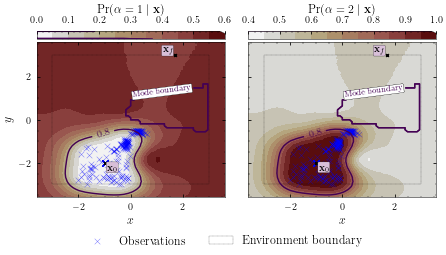

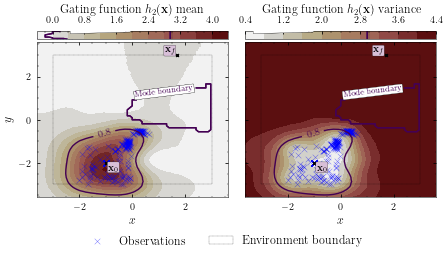

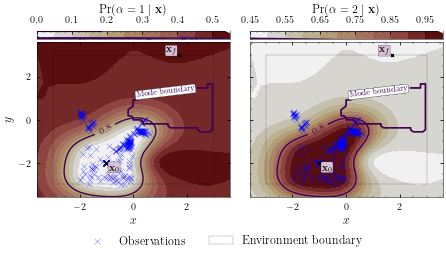

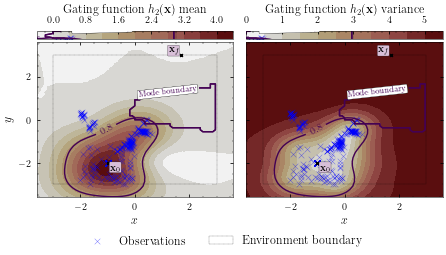

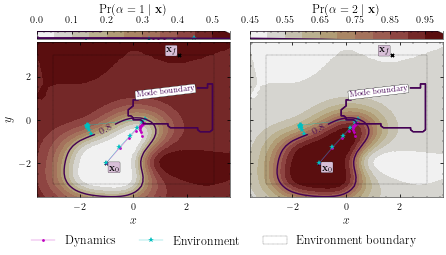

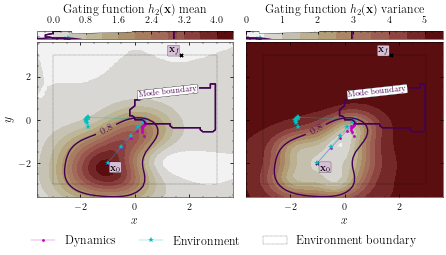

Epoch 1/10000
1/1 [==============================] - 2s 2s/step - loss: -736.6682 - val_loss: -188.6014
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_3_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -677.3660

2022-04-08 17:55:14.229365: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 17:55:14.229382: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -677.3660 - val_loss: -65.9882
Epoch 3/10000
1/1 [==============================] - 0s 41ms/step - loss: -767.8178 - val_loss: -202.0421


2022-04-08 17:55:16.514137: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 17:55:16.530197: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 17:55:16.541288: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_17_55_16

2022-04-08 17:55:16.552420: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_17_55_16/dr-robots-mbp.local.trace.json.gz
2022-04-08 17:55:16.587520: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_17_55_16

2022-04-08 17:55:16.58781

Epoch 4/10000
1/1 [==============================] - 0s 41ms/step - loss: -678.0822 - val_loss: -300.8261
Epoch 5/10000
1/1 [==============================] - 0s 42ms/step - loss: -729.6787 - val_loss: -301.9507
Epoch 6/10000
1/1 [==============================] - 0s 41ms/step - loss: -439.8448 - val_loss: -65.1858
Epoch 7/10000
1/1 [==============================] - 0s 41ms/step - loss: -701.7787 - val_loss: -215.6171
Epoch 8/10000
1/1 [==============================] - 0s 41ms/step - loss: -772.7626 - val_loss: -227.4817
Epoch 9/10000
1/1 [==============================] - 0s 42ms/step - loss: -745.1701 - val_loss: -255.6848
Epoch 10/10000
1/1 [==============================] - 0s 42ms/step - loss: -744.8949 - val_loss: -229.0631
Epoch 11/10000
1/1 [==============================] - 0s 41ms/step - loss: -712.6533 - val_loss: -258.6752
Epoch 12/10000
1/1 [==============================] - 0s 41ms/step - loss: -747.2351 - val_loss: -173.2767
Epoch 13/10000
1/1 [========================

1/1 [==============================] - 0s 40ms/step - loss: -703.8377 - val_loss: -254.4612
Epoch 157/10000
1/1 [==============================] - 0s 41ms/step - loss: -665.6605 - val_loss: -96.2356
Epoch 158/10000
1/1 [==============================] - 0s 41ms/step - loss: -786.2268 - val_loss: -377.3222
Epoch 159/10000
1/1 [==============================] - 0s 40ms/step - loss: -788.8271 - val_loss: -105.7841
Epoch 160/10000
1/1 [==============================] - 0s 40ms/step - loss: -723.3304 - val_loss: -219.7238
Epoch 161/10000
1/1 [==============================] - 0s 41ms/step - loss: -773.1592 - val_loss: -186.7169
Epoch 162/10000
1/1 [==============================] - 0s 40ms/step - loss: -796.2265 - val_loss: -284.9431
Epoch 163/10000
1/1 [==============================] - 0s 40ms/step - loss: -762.8917 - val_loss: -166.3153
Epoch 164/10000
1/1 [==============================] - 0s 41ms/step - loss: -682.1806 - val_loss: -236.5682
Epoch 165/10000
1/1 [========================

1/1 [==============================] - 0s 47ms/step - loss: -708.6273 - val_loss: -287.2173
Epoch 233/10000
1/1 [==============================] - 0s 44ms/step - loss: -777.6556 - val_loss: -153.5539
Epoch 234/10000
1/1 [==============================] - 0s 44ms/step - loss: -779.9372 - val_loss: -345.8837
Epoch 235/10000
1/1 [==============================] - 0s 49ms/step - loss: -496.4654 - val_loss: -184.5938
Epoch 236/10000
1/1 [==============================] - 0s 45ms/step - loss: -717.0999 - val_loss: -265.9589
Epoch 237/10000
1/1 [==============================] - 0s 45ms/step - loss: -670.1224 - val_loss: -289.4722
Epoch 238/10000
1/1 [==============================] - 0s 51ms/step - loss: -697.4641 - val_loss: -194.5933
Epoch 239/10000
1/1 [==============================] - 0s 48ms/step - loss: -791.2870 - val_loss: -257.8739
Epoch 240/10000
1/1 [==============================] - 0s 45ms/step - loss: -734.7506 - val_loss: -200.8941
Epoch 241/10000
1/1 [=======================

1/1 [==============================] - 0s 47ms/step - loss: -632.5698 - val_loss: -235.2351
Epoch 309/10000
1/1 [==============================] - 0s 72ms/step - loss: -773.9260 - val_loss: -321.8435
Epoch 310/10000
1/1 [==============================] - 0s 64ms/step - loss: -741.4836 - val_loss: -257.5050
Epoch 311/10000
1/1 [==============================] - 0s 53ms/step - loss: -757.2421 - val_loss: -364.5745
Epoch 312/10000
1/1 [==============================] - 0s 53ms/step - loss: -598.7243 - val_loss: 43.8004
Epoch 313/10000
1/1 [==============================] - 0s 55ms/step - loss: -748.3066 - val_loss: -226.2246
Epoch 314/10000
1/1 [==============================] - 0s 54ms/step - loss: -811.1174 - val_loss: -323.3473
Epoch 315/10000
1/1 [==============================] - 0s 54ms/step - loss: -615.9340 - val_loss: -225.1118
Epoch 316/10000
1/1 [==============================] - 0s 53ms/step - loss: -821.7592 - val_loss: -229.8076
Epoch 317/10000
1/1 [=========================

1/1 [==============================] - 0s 62ms/step - loss: -795.5968 - val_loss: -166.9907
Epoch 385/10000
1/1 [==============================] - 0s 59ms/step - loss: -795.5697 - val_loss: -282.8095
Epoch 386/10000
1/1 [==============================] - 0s 56ms/step - loss: -777.7212 - val_loss: -380.3251
Epoch 387/10000
1/1 [==============================] - 0s 56ms/step - loss: -832.3101 - val_loss: -434.6848
Epoch 388/10000
1/1 [==============================] - 0s 54ms/step - loss: -846.4861 - val_loss: -159.8547
Epoch 389/10000
1/1 [==============================] - 0s 54ms/step - loss: -763.3670 - val_loss: -290.9426
Epoch 390/10000
1/1 [==============================] - 0s 55ms/step - loss: -775.4164 - val_loss: -238.6117
Epoch 391/10000
1/1 [==============================] - 0s 52ms/step - loss: -838.6722 - val_loss: -452.9761
Epoch 392/10000
1/1 [==============================] - 0s 57ms/step - loss: -767.5807 - val_loss: -470.1039
Epoch 393/10000
1/1 [=======================

Epoch 460/10000
1/1 [==============================] - 0s 93ms/step - loss: -581.2865 - val_loss: -402.8033
Epoch 461/10000
1/1 [==============================] - 0s 90ms/step - loss: -669.5835 - val_loss: -364.4561
Epoch 462/10000
1/1 [==============================] - 0s 123ms/step - loss: -780.9237 - val_loss: -334.9458
Epoch 463/10000
1/1 [==============================] - 0s 90ms/step - loss: -722.1058 - val_loss: -252.3801
Epoch 464/10000
1/1 [==============================] - 0s 98ms/step - loss: -754.8331 - val_loss: -390.4595
Epoch 465/10000
1/1 [==============================] - 0s 91ms/step - loss: -568.1438 - val_loss: -167.9993
Epoch 466/10000
1/1 [==============================] - 0s 104ms/step - loss: -748.0652 - val_loss: -294.3112
Epoch 467/10000
1/1 [==============================] - 0s 81ms/step - loss: -720.2992 - val_loss: -260.4443
Epoch 468/10000
1/1 [==============================] - 0s 73ms/step - loss: -790.4963 - val_loss: -331.0934
Epoch 469/10000
1/1 [=====

1/1 [==============================] - 0s 63ms/step - loss: -723.0883 - val_loss: -277.2690
Epoch 612/10000
1/1 [==============================] - 0s 70ms/step - loss: -552.2967 - val_loss: -269.5913
Epoch 613/10000
1/1 [==============================] - 0s 62ms/step - loss: -691.3030 - val_loss: -338.5183
Epoch 614/10000
1/1 [==============================] - 0s 59ms/step - loss: -670.2712 - val_loss: -288.0285
Epoch 615/10000
1/1 [==============================] - 0s 61ms/step - loss: -419.2480 - val_loss: -241.4222
Epoch 616/10000
1/1 [==============================] - 0s 55ms/step - loss: -807.3412 - val_loss: -320.3218
Epoch 617/10000
1/1 [==============================] - 0s 61ms/step - loss: -667.8299 - val_loss: -167.6072
Epoch 618/10000
1/1 [==============================] - 0s 66ms/step - loss: -348.1173 - val_loss: -371.7431
Epoch 619/10000
1/1 [==============================] - 0s 59ms/step - loss: -397.5554 - val_loss: -296.4746
Epoch 620/10000
1/1 [=======================

1/1 [==============================] - 0s 88ms/step - loss: -806.5977 - val_loss: -344.8671
Epoch 688/10000
1/1 [==============================] - 0s 83ms/step - loss: -797.1979 - val_loss: -200.8672
Epoch 689/10000
1/1 [==============================] - 0s 95ms/step - loss: -798.8882 - val_loss: -324.8291
Epoch 690/10000
1/1 [==============================] - 0s 84ms/step - loss: -786.3158 - val_loss: -256.7398
Epoch 691/10000
1/1 [==============================] - 0s 85ms/step - loss: -815.7269 - val_loss: -234.9381
Epoch 692/10000
1/1 [==============================] - 0s 73ms/step - loss: -741.9324 - val_loss: -278.1461
Epoch 693/10000
1/1 [==============================] - 0s 71ms/step - loss: -719.1616 - val_loss: -315.8653
Epoch 694/10000
1/1 [==============================] - 0s 65ms/step - loss: -785.9508 - val_loss: -367.5890
Epoch 695/10000
1/1 [==============================] - 0s 68ms/step - loss: -782.4350 - val_loss: -214.3016
Epoch 696/10000
1/1 [=======================

Epoch 763/10000
1/1 [==============================] - 0s 63ms/step - loss: -803.8031 - val_loss: -326.2040
Epoch 764/10000
1/1 [==============================] - 0s 71ms/step - loss: -777.2790 - val_loss: -286.7082
Epoch 765/10000
1/1 [==============================] - 0s 71ms/step - loss: -746.2077 - val_loss: -306.3963
Epoch 766/10000
1/1 [==============================] - 0s 85ms/step - loss: -667.8947 - val_loss: -414.6356
Epoch 767/10000
1/1 [==============================] - 0s 62ms/step - loss: -771.0076 - val_loss: -387.0288
Epoch 768/10000
1/1 [==============================] - 0s 68ms/step - loss: -809.9690 - val_loss: -407.6712
Epoch 769/10000
1/1 [==============================] - 0s 69ms/step - loss: -806.6371 - val_loss: -350.4573
Epoch 770/10000
1/1 [==============================] - 0s 65ms/step - loss: -816.6173 - val_loss: -327.0787
Epoch 771/10000
1/1 [==============================] - 0s 65ms/step - loss: -699.1437 - val_loss: -218.2508
Epoch 772/10000
1/1 [=======

Epoch 914/10000
1/1 [==============================] - 0s 70ms/step - loss: -716.4845 - val_loss: -183.7957
Epoch 915/10000
1/1 [==============================] - 0s 77ms/step - loss: -554.8033 - val_loss: -131.9094
Epoch 916/10000
1/1 [==============================] - 0s 76ms/step - loss: -788.5344 - val_loss: -333.4352
Epoch 917/10000
1/1 [==============================] - 0s 72ms/step - loss: -682.1327 - val_loss: -187.3903
Epoch 918/10000
1/1 [==============================] - 0s 69ms/step - loss: -722.8427 - val_loss: -330.6727
Epoch 919/10000
1/1 [==============================] - 0s 66ms/step - loss: -805.2661 - val_loss: -316.5716
Epoch 920/10000
1/1 [==============================] - 0s 68ms/step - loss: -377.0876 - val_loss: -224.1279
Epoch 921/10000
1/1 [==============================] - 0s 72ms/step - loss: -843.7684 - val_loss: -468.5519
Epoch 922/10000
1/1 [==============================] - 0s 70ms/step - loss: -733.9928 - val_loss: -350.0322
Epoch 923/10000
1/1 [=======

Epoch 990/10000
1/1 [==============================] - 0s 104ms/step - loss: -717.2134 - val_loss: -291.7231
Epoch 991/10000
1/1 [==============================] - 0s 83ms/step - loss: -751.4567 - val_loss: -312.5199
Epoch 992/10000
1/1 [==============================] - 0s 102ms/step - loss: -594.0726 - val_loss: -148.4735
Epoch 993/10000
1/1 [==============================] - 0s 100ms/step - loss: -730.0286 - val_loss: -307.5146
Epoch 994/10000
1/1 [==============================] - 0s 112ms/step - loss: -737.1157 - val_loss: -377.6829
Epoch 995/10000
1/1 [==============================] - 0s 97ms/step - loss: -707.3965 - val_loss: -328.9367
Epoch 996/10000
1/1 [==============================] - 0s 81ms/step - loss: -663.1402 - val_loss: -328.9810
Epoch 997/10000
1/1 [==============================] - 0s 82ms/step - loss: -709.6804 - val_loss: -213.4991
Epoch 998/10000
1/1 [==============================] - 0s 79ms/step - loss: -585.8987 - val_loss: -352.4967
Epoch 999/10000
1/1 [===

1/1 [==============================] - 0s 85ms/step - loss: -537.0898 - val_loss: -297.2799
Epoch 1066/10000
1/1 [==============================] - 0s 101ms/step - loss: -838.8117 - val_loss: -409.9771
Epoch 1067/10000
1/1 [==============================] - 0s 75ms/step - loss: -841.5620 - val_loss: -410.4259
Epoch 1068/10000
1/1 [==============================] - 0s 88ms/step - loss: -815.5242 - val_loss: -462.5898
Epoch 1069/10000
1/1 [==============================] - 0s 77ms/step - loss: -805.5853 - val_loss: -408.3445
Epoch 1070/10000
1/1 [==============================] - 0s 82ms/step - loss: -748.4687 - val_loss: -132.7377
Epoch 1071/10000
1/1 [==============================] - 0s 82ms/step - loss: -716.9943 - val_loss: -365.1213
Epoch 1072/10000
1/1 [==============================] - 0s 88ms/step - loss: -743.3422 - val_loss: -155.7375
Epoch 1073/10000
1/1 [==============================] - 0s 99ms/step - loss: -857.4182 - val_loss: -388.5933
Epoch 1074/10000
1/1 [=============

Epoch 1215/10000
1/1 [==============================] - 0s 118ms/step - loss: -704.2232 - val_loss: -316.1136
Epoch 1216/10000
1/1 [==============================] - 0s 108ms/step - loss: -771.0953 - val_loss: -295.0903
Epoch 1217/10000
1/1 [==============================] - 0s 112ms/step - loss: -735.4017 - val_loss: -316.7892
Epoch 1218/10000
1/1 [==============================] - 0s 85ms/step - loss: -753.0993 - val_loss: -350.8489
Epoch 1219/10000
1/1 [==============================] - 0s 100ms/step - loss: -777.7830 - val_loss: -386.8343
Epoch 1220/10000
1/1 [==============================] - 0s 86ms/step - loss: -739.9479 - val_loss: -396.2496
Epoch 1221/10000
1/1 [==============================] - 0s 99ms/step - loss: -739.2788 - val_loss: -219.9823
Epoch 1222/10000
1/1 [==============================] - 0s 111ms/step - loss: -763.8425 - val_loss: -334.7204
Epoch 1223/10000
1/1 [==============================] - 0s 93ms/step - loss: -774.3748 - val_loss: -363.9449
Epoch 1224/100

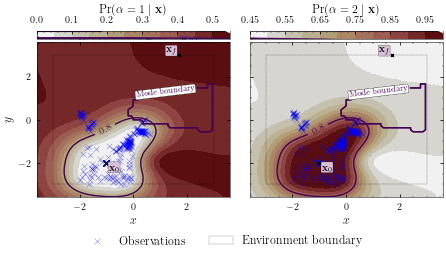

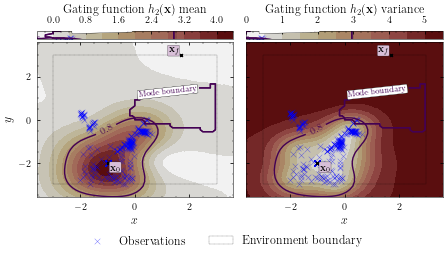

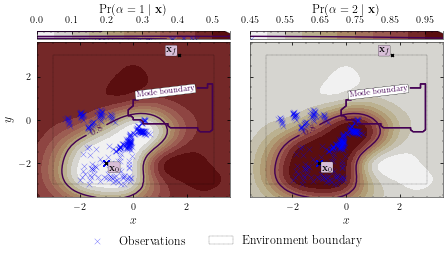

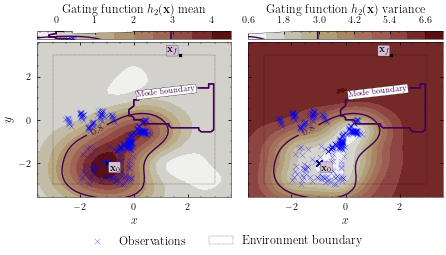

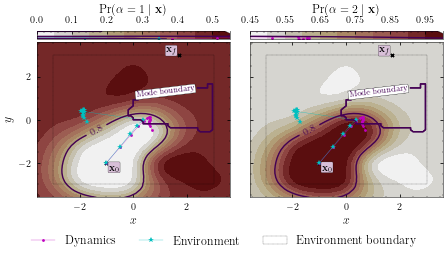

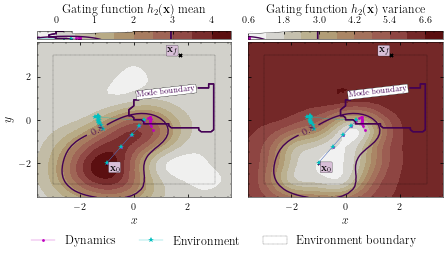

Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: -425.5650 - val_loss: -221.1717
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_4_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: 136.1467

2022-04-08 18:00:00.343034: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 18:00:00.343051: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 3s 3s/step - loss: 136.1467 - val_loss: 26.7010
Epoch 3/10000
1/1 [==============================] - ETA: 0s - loss: -351.7789

2022-04-08 18:00:02.733865: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 18:00:02.757345: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 18:00:02.779442: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_00_02

2022-04-08 18:00:02.792485: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_00_02/dr-robots-mbp.local.trace.json.gz
2022-04-08 18:00:02.838250: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_00_02

2022-04-08 18:00:02.83895

1/1 [==============================] - 0s 49ms/step - loss: -351.7789 - val_loss: -243.2792
Epoch 4/10000
1/1 [==============================] - 0s 51ms/step - loss: -554.9554 - val_loss: -290.1176
Epoch 5/10000
1/1 [==============================] - 0s 47ms/step - loss: -578.1495 - val_loss: -312.5450
Epoch 6/10000
1/1 [==============================] - 0s 46ms/step - loss: -613.5070 - val_loss: -374.3095
Epoch 7/10000
1/1 [==============================] - 0s 46ms/step - loss: -649.1370 - val_loss: -355.1104
Epoch 8/10000
1/1 [==============================] - 0s 46ms/step - loss: -703.1835 - val_loss: -390.3368
Epoch 9/10000
1/1 [==============================] - 0s 44ms/step - loss: -712.2821 - val_loss: -403.7921
Epoch 10/10000
1/1 [==============================] - 0s 45ms/step - loss: -736.5305 - val_loss: -430.0704
Epoch 11/10000
1/1 [==============================] - 0s 45ms/step - loss: -505.1396 - val_loss: -311.8180
Epoch 12/10000
1/1 [==============================] - 0s 4

Epoch 80/10000
1/1 [==============================] - 0s 47ms/step - loss: -748.8934 - val_loss: -533.8994
Epoch 81/10000
1/1 [==============================] - 0s 50ms/step - loss: -755.1128 - val_loss: -520.6552
Epoch 82/10000
1/1 [==============================] - 0s 46ms/step - loss: -782.0759 - val_loss: -566.3299
Epoch 83/10000
1/1 [==============================] - 0s 51ms/step - loss: -718.4515 - val_loss: -546.8971
Epoch 84/10000
1/1 [==============================] - 0s 47ms/step - loss: -656.1701 - val_loss: -461.2894
Epoch 85/10000
1/1 [==============================] - 0s 48ms/step - loss: -680.5050 - val_loss: -352.6200
Epoch 86/10000
1/1 [==============================] - 0s 46ms/step - loss: -578.4462 - val_loss: -297.9907
Epoch 87/10000
1/1 [==============================] - 0s 47ms/step - loss: -447.2524 - val_loss: -270.1478
Epoch 88/10000
1/1 [==============================] - 0s 46ms/step - loss: -444.3845 - val_loss: -328.2346
Epoch 89/10000
1/1 [=================

1/1 [==============================] - 0s 66ms/step - loss: -355.5951 - val_loss: 407.7566
Epoch 233/10000
1/1 [==============================] - 0s 54ms/step - loss: -338.1214 - val_loss: 361.4202
Epoch 234/10000
1/1 [==============================] - 0s 60ms/step - loss: -513.4165 - val_loss: -314.9238
Epoch 235/10000
1/1 [==============================] - 0s 58ms/step - loss: -442.1816 - val_loss: 356.1411
Epoch 236/10000
1/1 [==============================] - 0s 58ms/step - loss: -455.8569 - val_loss: -543.6007
Epoch 237/10000
1/1 [==============================] - 0s 54ms/step - loss: -464.6401 - val_loss: -550.3736
Epoch 238/10000
1/1 [==============================] - 0s 53ms/step - loss: -367.4271 - val_loss: 257.6439
Epoch 239/10000
1/1 [==============================] - 0s 51ms/step - loss: -506.1390 - val_loss: -266.8550
Epoch 240/10000
1/1 [==============================] - 0s 55ms/step - loss: -277.0688 - val_loss: 393.6520
Epoch 241/10000
1/1 [============================

1/1 [==============================] - 0s 60ms/step - loss: -323.0828 - val_loss: 274.6348
Epoch 385/10000
1/1 [==============================] - 0s 55ms/step - loss: -254.6103 - val_loss: 266.0131
Epoch 386/10000
1/1 [==============================] - 0s 54ms/step - loss: -522.9648 - val_loss: -523.2786
Epoch 387/10000
1/1 [==============================] - 0s 54ms/step - loss: -700.6145 - val_loss: -581.3593
Epoch 388/10000
1/1 [==============================] - 0s 54ms/step - loss: -539.2386 - val_loss: 173.7818
Epoch 389/10000
1/1 [==============================] - 0s 52ms/step - loss: -572.3337 - val_loss: 110.5440
Epoch 390/10000
1/1 [==============================] - 0s 53ms/step - loss: -697.0174 - val_loss: -605.9675
Epoch 391/10000
1/1 [==============================] - 0s 54ms/step - loss: -199.0755 - val_loss: 242.8702
Epoch 392/10000
1/1 [==============================] - 0s 56ms/step - loss: -63.8353 - val_loss: 243.0833
Epoch 393/10000
1/1 [==============================

1/1 [==============================] - 0s 58ms/step - loss: -331.6441 - val_loss: 169.1858
Epoch 537/10000
1/1 [==============================] - 0s 60ms/step - loss: -536.1379 - val_loss: 132.7567
Epoch 538/10000
1/1 [==============================] - 0s 62ms/step - loss: -574.9057 - val_loss: 48.0714
Epoch 539/10000
1/1 [==============================] - 0s 60ms/step - loss: -684.7752 - val_loss: -416.9824
Epoch 540/10000
1/1 [==============================] - 0s 61ms/step - loss: -587.0562 - val_loss: -571.9399
Epoch 541/10000
1/1 [==============================] - 0s 59ms/step - loss: -503.7921 - val_loss: 119.9734
Epoch 542/10000
1/1 [==============================] - 0s 61ms/step - loss: -401.1147 - val_loss: -480.0228
Epoch 543/10000
1/1 [==============================] - 0s 60ms/step - loss: -443.0137 - val_loss: 254.3068
Epoch 544/10000
1/1 [==============================] - 0s 61ms/step - loss: -174.0181 - val_loss: -426.8848
Epoch 545/10000
1/1 [=============================

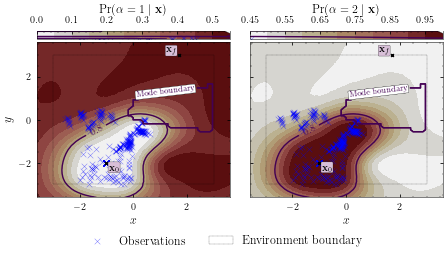

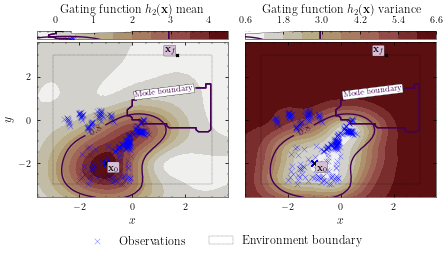

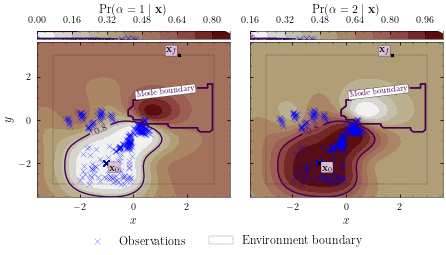

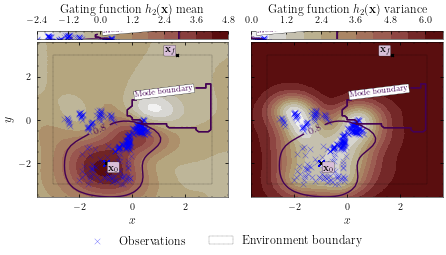

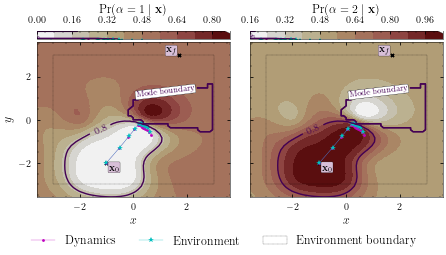

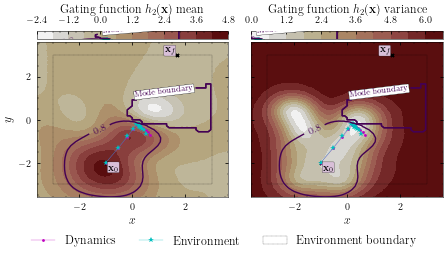

Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: -563.2860 - val_loss: -503.0696
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_5_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -502.0141

2022-04-08 18:03:58.220296: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 18:03:58.220315: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -502.0141 - val_loss: -507.9827
Epoch 3/10000
1/1 [==============================] - 0s 38ms/step - loss: -488.6388 - val_loss: -321.8231
Epoch 4/10000
1/1 [==============================] - 0s 37ms/step - loss: -531.5730 - val_loss: -426.7962


2022-04-08 18:04:00.067633: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 18:04:00.081347: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 18:04:00.090793: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_04_00

2022-04-08 18:04:00.099796: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_04_00/dr-robots-mbp.local.trace.json.gz
2022-04-08 18:04:00.126361: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_04_00

2022-04-08 18:04:00.12659

Epoch 5/10000
1/1 [==============================] - 0s 38ms/step - loss: -496.8104 - val_loss: -469.0143
Epoch 6/10000
1/1 [==============================] - 0s 37ms/step - loss: -658.5517 - val_loss: -745.5806
Epoch 7/10000
1/1 [==============================] - 0s 38ms/step - loss: -558.1902 - val_loss: -531.5329
Epoch 8/10000
1/1 [==============================] - 0s 37ms/step - loss: -579.4795 - val_loss: -540.2151
Epoch 9/10000
1/1 [==============================] - 0s 37ms/step - loss: -606.2941 - val_loss: -720.0213
Epoch 10/10000
1/1 [==============================] - 0s 38ms/step - loss: -538.9692 - val_loss: -512.7619
Epoch 11/10000
1/1 [==============================] - 0s 38ms/step - loss: -476.7274 - val_loss: -512.1013
Epoch 12/10000
1/1 [==============================] - 0s 37ms/step - loss: -553.1296 - val_loss: -555.5710
Epoch 13/10000
1/1 [==============================] - 0s 38ms/step - loss: -505.0393 - val_loss: -614.7642
Epoch 14/10000
1/1 [======================

1/1 [==============================] - 0s 46ms/step - loss: -633.5961 - val_loss: -607.4473
Epoch 158/10000
1/1 [==============================] - 0s 49ms/step - loss: -680.2863 - val_loss: -688.5627
Epoch 159/10000
1/1 [==============================] - 0s 46ms/step - loss: -702.8549 - val_loss: -713.5371
Epoch 160/10000
1/1 [==============================] - 0s 47ms/step - loss: -665.2423 - val_loss: -669.8875
Epoch 161/10000
1/1 [==============================] - 0s 52ms/step - loss: -505.2474 - val_loss: -454.8970
Epoch 162/10000
1/1 [==============================] - 0s 46ms/step - loss: -599.9628 - val_loss: -535.4776
Epoch 163/10000
1/1 [==============================] - 0s 42ms/step - loss: -483.3914 - val_loss: -430.7954
Epoch 164/10000
1/1 [==============================] - 0s 40ms/step - loss: -403.8323 - val_loss: -385.5217
Epoch 165/10000
1/1 [==============================] - 0s 41ms/step - loss: -702.6124 - val_loss: -717.3431
Epoch 166/10000
1/1 [=======================

1/1 [==============================] - 0s 49ms/step - loss: -694.7575 - val_loss: -807.4766
Epoch 234/10000
1/1 [==============================] - 0s 59ms/step - loss: -694.8645 - val_loss: -701.6872
Epoch 235/10000
1/1 [==============================] - 0s 55ms/step - loss: -691.9112 - val_loss: -781.0555
Epoch 236/10000
1/1 [==============================] - 0s 57ms/step - loss: -796.3831 - val_loss: -784.4910
Epoch 237/10000
1/1 [==============================] - 0s 67ms/step - loss: -734.0202 - val_loss: -746.9025
Epoch 238/10000
1/1 [==============================] - 0s 52ms/step - loss: -733.8275 - val_loss: -743.6169
Epoch 239/10000
1/1 [==============================] - 0s 45ms/step - loss: -557.4279 - val_loss: -759.2831
Epoch 240/10000
1/1 [==============================] - 0s 43ms/step - loss: -691.1717 - val_loss: -822.9397
Epoch 241/10000
1/1 [==============================] - 0s 43ms/step - loss: -632.0109 - val_loss: -760.1384
Epoch 242/10000
1/1 [=======================

1/1 [==============================] - 0s 42ms/step - loss: -511.8775 - val_loss: -497.6163
Epoch 310/10000
1/1 [==============================] - 0s 43ms/step - loss: -553.3359 - val_loss: -646.2378
Epoch 311/10000
1/1 [==============================] - 0s 43ms/step - loss: -638.5899 - val_loss: -686.4580
Epoch 312/10000
1/1 [==============================] - 0s 58ms/step - loss: -631.3279 - val_loss: -719.2863
Epoch 313/10000
1/1 [==============================] - 0s 53ms/step - loss: -455.3169 - val_loss: -664.3300
Epoch 314/10000
1/1 [==============================] - 0s 55ms/step - loss: -680.0018 - val_loss: -740.6697
Epoch 315/10000
1/1 [==============================] - 0s 48ms/step - loss: -680.0591 - val_loss: -750.1499
Epoch 316/10000
1/1 [==============================] - 0s 46ms/step - loss: -617.3943 - val_loss: -681.7627
Epoch 317/10000
1/1 [==============================] - 0s 43ms/step - loss: -706.2285 - val_loss: -741.2147
Epoch 318/10000
1/1 [=======================

1/1 [==============================] - 0s 46ms/step - loss: -648.3077 - val_loss: -768.3732
Epoch 386/10000
1/1 [==============================] - 0s 49ms/step - loss: -588.3174 - val_loss: -676.5412
Epoch 387/10000
1/1 [==============================] - 0s 49ms/step - loss: -717.1489 - val_loss: -770.7993
Epoch 388/10000
1/1 [==============================] - 0s 48ms/step - loss: -739.4432 - val_loss: -752.5442
Epoch 389/10000
1/1 [==============================] - 0s 50ms/step - loss: -724.5351 - val_loss: -804.4566
Epoch 390/10000
1/1 [==============================] - 0s 53ms/step - loss: -625.4127 - val_loss: -708.5112
Epoch 391/10000
1/1 [==============================] - 0s 47ms/step - loss: -769.8374 - val_loss: -822.2655
Epoch 392/10000
1/1 [==============================] - 0s 49ms/step - loss: -699.9410 - val_loss: -773.5556
Epoch 393/10000
1/1 [==============================] - 0s 44ms/step - loss: -705.3324 - val_loss: -798.4305
Epoch 394/10000
1/1 [=======================

1/1 [==============================] - 0s 49ms/step - loss: -630.0545 - val_loss: -690.8047
Epoch 462/10000
1/1 [==============================] - 0s 49ms/step - loss: -681.4064 - val_loss: -718.8920
Epoch 463/10000
1/1 [==============================] - 0s 47ms/step - loss: -648.7312 - val_loss: -660.1833
Epoch 464/10000
1/1 [==============================] - 0s 46ms/step - loss: -590.9777 - val_loss: -665.2008
Epoch 465/10000
1/1 [==============================] - 0s 46ms/step - loss: -587.6741 - val_loss: -687.2035
Epoch 466/10000
1/1 [==============================] - 0s 46ms/step - loss: -560.0281 - val_loss: -682.6699
Epoch 467/10000
1/1 [==============================] - 0s 46ms/step - loss: -563.8013 - val_loss: -698.4653
Epoch 468/10000
1/1 [==============================] - 0s 46ms/step - loss: -644.0693 - val_loss: -686.0735
Epoch 469/10000
1/1 [==============================] - 0s 49ms/step - loss: -656.8260 - val_loss: -692.5026
Epoch 470/10000
1/1 [=======================

Epoch 537/10000
1/1 [==============================] - 0s 62ms/step - loss: -770.6367 - val_loss: -776.8447
Epoch 538/10000
1/1 [==============================] - 0s 90ms/step - loss: -735.4051 - val_loss: -784.7669
Epoch 539/10000
1/1 [==============================] - 0s 78ms/step - loss: -745.0519 - val_loss: -769.4005
Epoch 540/10000
1/1 [==============================] - 0s 58ms/step - loss: -765.5171 - val_loss: -803.3864
Epoch 541/10000
1/1 [==============================] - 0s 60ms/step - loss: -698.5615 - val_loss: -744.5336
Epoch 542/10000
1/1 [==============================] - 0s 60ms/step - loss: -780.1845 - val_loss: -785.0511
Epoch 543/10000
1/1 [==============================] - 0s 67ms/step - loss: -787.1715 - val_loss: -824.7813
Epoch 544/10000
1/1 [==============================] - 0s 61ms/step - loss: -756.9187 - val_loss: -809.7064
Epoch 545/10000
1/1 [==============================] - 0s 64ms/step - loss: -711.8382 - val_loss: -766.2302
Epoch 546/10000
1/1 [=======

Epoch 613/10000
1/1 [==============================] - 0s 58ms/step - loss: -573.3747 - val_loss: -669.7298
Epoch 614/10000
1/1 [==============================] - 0s 60ms/step - loss: -616.4742 - val_loss: -649.9854
Epoch 615/10000
1/1 [==============================] - 0s 58ms/step - loss: -542.7037 - val_loss: -699.7932
Epoch 616/10000
1/1 [==============================] - 0s 50ms/step - loss: -689.2036 - val_loss: -732.4209
Epoch 617/10000
1/1 [==============================] - 0s 54ms/step - loss: -716.2321 - val_loss: -721.8515
Epoch 618/10000
1/1 [==============================] - 0s 54ms/step - loss: -731.8308 - val_loss: -707.4934
Epoch 619/10000
1/1 [==============================] - 0s 51ms/step - loss: -705.7135 - val_loss: -738.8648
Epoch 620/10000
1/1 [==============================] - 0s 48ms/step - loss: -719.4514 - val_loss: -702.8696
Epoch 621/10000
1/1 [==============================] - 0s 49ms/step - loss: -725.6578 - val_loss: -750.8113
Epoch 622/10000
1/1 [=======

Epoch 689/10000
1/1 [==============================] - 0s 52ms/step - loss: -756.4573 - val_loss: -812.5106
Epoch 690/10000
1/1 [==============================] - 0s 54ms/step - loss: -800.0298 - val_loss: -811.1546
Epoch 691/10000
1/1 [==============================] - 0s 53ms/step - loss: -767.0322 - val_loss: -776.0296
Epoch 692/10000
1/1 [==============================] - 0s 51ms/step - loss: -779.8558 - val_loss: -803.5268
Epoch 693/10000
1/1 [==============================] - 0s 53ms/step - loss: -802.5963 - val_loss: -819.9987
Epoch 694/10000
1/1 [==============================] - 0s 53ms/step - loss: -822.2344 - val_loss: -826.8750
Epoch 695/10000
1/1 [==============================] - 0s 53ms/step - loss: -826.9537 - val_loss: -835.1000
Epoch 696/10000
1/1 [==============================] - 0s 52ms/step - loss: -813.9320 - val_loss: -830.7876
Epoch 697/10000
1/1 [==============================] - 0s 53ms/step - loss: -801.4626 - val_loss: -828.2494
Epoch 698/10000
1/1 [=======

Epoch 765/10000
1/1 [==============================] - 0s 64ms/step - loss: -514.2478 - val_loss: -669.2809
Epoch 766/10000
1/1 [==============================] - 0s 75ms/step - loss: -563.2043 - val_loss: -671.0960
Epoch 767/10000
1/1 [==============================] - 0s 82ms/step - loss: -452.5989 - val_loss: -604.8345
Epoch 768/10000
1/1 [==============================] - 0s 89ms/step - loss: -595.2203 - val_loss: -692.4227
Epoch 769/10000
1/1 [==============================] - 0s 99ms/step - loss: -630.6495 - val_loss: -634.3886
Epoch 770/10000
1/1 [==============================] - 0s 92ms/step - loss: -642.9719 - val_loss: -684.9290
Epoch 771/10000
1/1 [==============================] - 0s 80ms/step - loss: -716.2222 - val_loss: -724.5657
Epoch 772/10000
1/1 [==============================] - 0s 69ms/step - loss: -589.2933 - val_loss: -553.7338
Epoch 773/10000
1/1 [==============================] - 0s 89ms/step - loss: -653.8398 - val_loss: -653.7676
Epoch 774/10000
1/1 [=======

Epoch 841/10000
1/1 [==============================] - 0s 91ms/step - loss: -739.0229 - val_loss: -785.8923
Epoch 842/10000
1/1 [==============================] - 0s 87ms/step - loss: -768.6669 - val_loss: -739.9284
Epoch 843/10000
1/1 [==============================] - 0s 101ms/step - loss: -745.6054 - val_loss: -749.7909
Epoch 844/10000
1/1 [==============================] - 0s 104ms/step - loss: -791.5153 - val_loss: -794.7558
Epoch 845/10000
1/1 [==============================] - 0s 104ms/step - loss: -720.3876 - val_loss: -773.8751
Epoch 846/10000
1/1 [==============================] - 0s 82ms/step - loss: -735.7379 - val_loss: -803.5436
Epoch 847/10000
1/1 [==============================] - 0s 75ms/step - loss: -714.2994 - val_loss: -792.8850
Epoch 848/10000
1/1 [==============================] - 0s 94ms/step - loss: -777.2807 - val_loss: -810.3056
Epoch 849/10000
1/1 [==============================] - 0s 97ms/step - loss: -767.3884 - val_loss: -814.3459
Epoch 850/10000
1/1 [====

Epoch 992/10000
1/1 [==============================] - 0s 81ms/step - loss: -541.2637 - val_loss: -770.0928
Epoch 993/10000
1/1 [==============================] - 0s 86ms/step - loss: -732.2648 - val_loss: -741.9964
Epoch 994/10000
1/1 [==============================] - 0s 94ms/step - loss: -642.8670 - val_loss: -724.2866
Epoch 995/10000
1/1 [==============================] - 0s 96ms/step - loss: -497.5829 - val_loss: -639.9234
Epoch 996/10000
1/1 [==============================] - 0s 95ms/step - loss: -298.2204 - val_loss: -704.8993
Epoch 997/10000
1/1 [==============================] - 0s 82ms/step - loss: -463.7862 - val_loss: -710.2070
Epoch 998/10000
1/1 [==============================] - 0s 70ms/step - loss: -746.2556 - val_loss: -739.8739
Epoch 999/10000
1/1 [==============================] - 0s 92ms/step - loss: -591.5163 - val_loss: -677.3211
Epoch 1000/10000
1/1 [==============================] - 0s 93ms/step - loss: -549.8741 - val_loss: -556.5288
Epoch 1001/10000
1/1 [=====

1/1 [==============================] - 0s 69ms/step - loss: -783.4480 - val_loss: -777.2129
Epoch 1068/10000
1/1 [==============================] - 0s 66ms/step - loss: -621.1659 - val_loss: -764.6309
Epoch 1069/10000
1/1 [==============================] - 0s 75ms/step - loss: -786.3086 - val_loss: -797.8909
Epoch 1070/10000
1/1 [==============================] - 0s 86ms/step - loss: -772.0509 - val_loss: -795.2831
Epoch 1071/10000
1/1 [==============================] - 0s 81ms/step - loss: -781.5659 - val_loss: -791.6075
Epoch 1072/10000
1/1 [==============================] - 0s 79ms/step - loss: -670.5914 - val_loss: -758.4031
Epoch 1073/10000
1/1 [==============================] - 0s 73ms/step - loss: -769.6568 - val_loss: -771.6146
Epoch 1074/10000
1/1 [==============================] - 0s 67ms/step - loss: -782.9787 - val_loss: -765.6357
Epoch 1075/10000
1/1 [==============================] - 0s 70ms/step - loss: -770.4265 - val_loss: -760.4789
Epoch 1076/10000
1/1 [==============

1/1 [==============================] - 0s 84ms/step - loss: -666.2821 - val_loss: -696.4841
Epoch 1218/10000
1/1 [==============================] - 0s 94ms/step - loss: -541.1054 - val_loss: -662.1771
Epoch 1219/10000
1/1 [==============================] - 0s 83ms/step - loss: -718.8705 - val_loss: -716.8984
Epoch 1220/10000
1/1 [==============================] - 0s 96ms/step - loss: -698.3676 - val_loss: -695.2265
Epoch 1221/10000
1/1 [==============================] - 0s 82ms/step - loss: -700.1232 - val_loss: -686.5271
Epoch 1222/10000
1/1 [==============================] - 0s 69ms/step - loss: -663.7137 - val_loss: -723.4049
Epoch 1223/10000
1/1 [==============================] - 0s 62ms/step - loss: -693.1714 - val_loss: -729.5025
Epoch 1224/10000
1/1 [==============================] - 0s 73ms/step - loss: -692.1930 - val_loss: -727.8445
Epoch 1225/10000
1/1 [==============================] - 0s 82ms/step - loss: -732.1833 - val_loss: -727.1598
Epoch 1226/10000
1/1 [==============

1/1 [==============================] - 0s 69ms/step - loss: -743.2761 - val_loss: -807.0259
Epoch 1293/10000
1/1 [==============================] - 0s 68ms/step - loss: -781.0486 - val_loss: -856.8166
Epoch 1294/10000
1/1 [==============================] - 0s 67ms/step - loss: -801.1190 - val_loss: -836.4634
Epoch 1295/10000
1/1 [==============================] - 0s 58ms/step - loss: -762.1145 - val_loss: -809.9930
Epoch 1296/10000
1/1 [==============================] - 0s 62ms/step - loss: -777.3289 - val_loss: -818.9650
Epoch 1297/10000
1/1 [==============================] - 0s 55ms/step - loss: -724.8497 - val_loss: -788.2567
Epoch 1298/10000
1/1 [==============================] - 0s 66ms/step - loss: -779.5492 - val_loss: -812.4303
Epoch 1299/10000
1/1 [==============================] - 0s 64ms/step - loss: -821.9797 - val_loss: -854.9499
Epoch 1300/10000
1/1 [==============================] - 0s 64ms/step - loss: -692.1615 - val_loss: -820.8986
Epoch 1301/10000
1/1 [==============

1/1 [==============================] - 0s 83ms/step - loss: -775.1776 - val_loss: -787.8148
Epoch 1443/10000
1/1 [==============================] - 0s 96ms/step - loss: -781.6481 - val_loss: -805.4127
Epoch 1444/10000
1/1 [==============================] - 0s 125ms/step - loss: -786.3275 - val_loss: -796.9712
Epoch 1445/10000
1/1 [==============================] - 0s 100ms/step - loss: -786.4401 - val_loss: -789.0743
Epoch 1446/10000
1/1 [==============================] - 0s 90ms/step - loss: -794.1883 - val_loss: -791.5558
Epoch 1447/10000
1/1 [==============================] - 0s 73ms/step - loss: -787.6213 - val_loss: -788.9282
Epoch 1448/10000
1/1 [==============================] - 0s 90ms/step - loss: -788.8806 - val_loss: -788.2437
Epoch 1449/10000
1/1 [==============================] - 0s 71ms/step - loss: -795.9274 - val_loss: -816.2299
Epoch 1450/10000
1/1 [==============================] - 0s 59ms/step - loss: -786.0125 - val_loss: -812.1034
Epoch 1451/10000
1/1 [============

1/1 [==============================] - 0s 49ms/step - loss: -632.3859 - val_loss: -698.2198
Epoch 1593/10000
1/1 [==============================] - 0s 50ms/step - loss: -674.7455 - val_loss: -764.3480
Epoch 1594/10000
1/1 [==============================] - 0s 52ms/step - loss: -683.1620 - val_loss: -755.3469
Epoch 1595/10000
1/1 [==============================] - 0s 43ms/step - loss: -733.5084 - val_loss: -760.4897
Epoch 1596/10000
1/1 [==============================] - 0s 43ms/step - loss: -678.9901 - val_loss: -712.8381
Epoch 1597/10000
1/1 [==============================] - 0s 44ms/step - loss: -555.4877 - val_loss: -711.3396
Epoch 1598/10000
1/1 [==============================] - 0s 49ms/step - loss: -471.1221 - val_loss: -663.7013
Epoch 1599/10000
1/1 [==============================] - 0s 43ms/step - loss: -625.0032 - val_loss: -659.3786
Epoch 1600/10000
1/1 [==============================] - 0s 42ms/step - loss: -518.9084 - val_loss: -643.5272
Epoch 1601/10000
1/1 [==============

(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
Data set size: (485, 4)


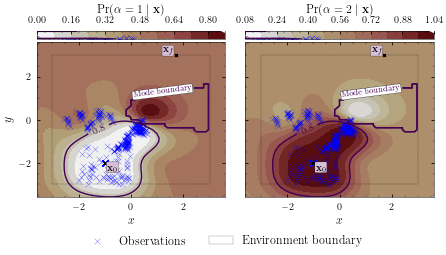

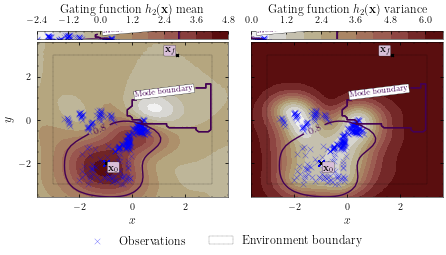

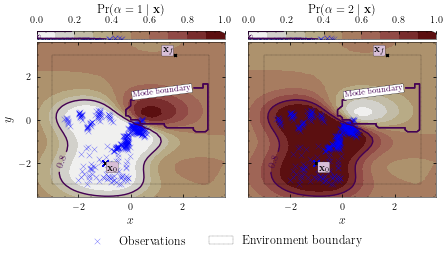

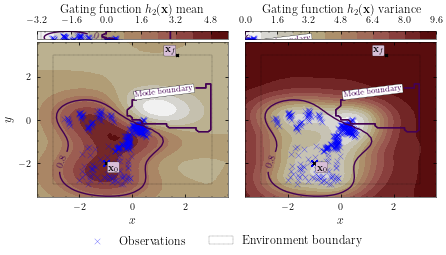

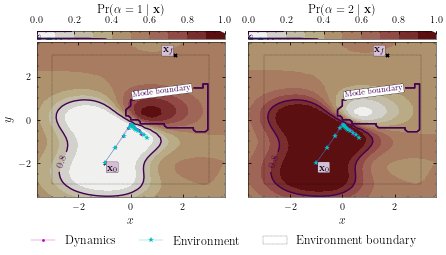

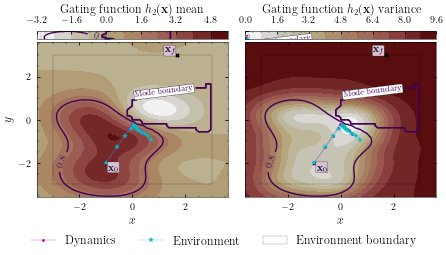

Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: -662.5730 - val_loss: -729.8099
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_6_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -642.8598

2022-04-08 18:07:55.301282: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 18:07:55.301302: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-08 18:07:58.963172: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 18:07:58.996112: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 18:07:59.021619: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_07_58

2022-04-08 18:07:59.035855: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_07_58/dr-robots-mbp.local.trace.json.gz
2022-04-08 18:07:59.090722: I

1/1 [==============================] - 4s 4s/step - loss: -642.8598 - val_loss: -727.5551
Epoch 3/10000
1/1 [==============================] - 0s 92ms/step - loss: -658.3852 - val_loss: -734.5168
Epoch 4/10000
1/1 [==============================] - 0s 82ms/step - loss: -687.1927 - val_loss: -789.0263
Epoch 5/10000
1/1 [==============================] - 0s 71ms/step - loss: -588.6944 - val_loss: -701.0710
Epoch 6/10000
1/1 [==============================] - 0s 100ms/step - loss: -186.2802 - val_loss: -613.0077
Epoch 7/10000
1/1 [==============================] - 0s 87ms/step - loss: -560.6846 - val_loss: -703.2365
Epoch 8/10000
1/1 [==============================] - 0s 81ms/step - loss: -591.5256 - val_loss: -631.9522
Epoch 9/10000
1/1 [==============================] - 0s 72ms/step - loss: 134.9984 - val_loss: -448.3709
Epoch 10/10000
1/1 [==============================] - 0s 98ms/step - loss: -656.6888 - val_loss: -724.8653
Epoch 11/10000
1/1 [==============================] - 0s 95ms

Epoch 79/10000
1/1 [==============================] - 0s 74ms/step - loss: -699.5036 - val_loss: -810.7315
Epoch 80/10000
1/1 [==============================] - 0s 76ms/step - loss: -679.7232 - val_loss: -813.5441
Epoch 81/10000
1/1 [==============================] - 0s 87ms/step - loss: -719.8407 - val_loss: -826.2762
Epoch 82/10000
1/1 [==============================] - 0s 80ms/step - loss: -708.0382 - val_loss: -822.5056
Epoch 83/10000
1/1 [==============================] - 0s 77ms/step - loss: -687.6685 - val_loss: -821.8955
Epoch 84/10000
1/1 [==============================] - 0s 129ms/step - loss: -670.1362 - val_loss: -790.4722
Epoch 85/10000
1/1 [==============================] - 0s 116ms/step - loss: -644.7518 - val_loss: -821.0243
Epoch 86/10000
1/1 [==============================] - 0s 96ms/step - loss: -628.6196 - val_loss: -794.5432
Epoch 87/10000
1/1 [==============================] - 0s 151ms/step - loss: -685.9957 - val_loss: -799.4821
Epoch 88/10000
1/1 [==============

1/1 [==============================] - 0s 66ms/step - loss: -784.8494 - val_loss: -891.5951
Epoch 156/10000
1/1 [==============================] - 0s 72ms/step - loss: -754.4291 - val_loss: -881.3582
Epoch 157/10000
1/1 [==============================] - 0s 69ms/step - loss: -654.3835 - val_loss: -816.0366
Epoch 158/10000
1/1 [==============================] - 0s 68ms/step - loss: -790.7488 - val_loss: -890.7301
Epoch 159/10000
1/1 [==============================] - 0s 70ms/step - loss: -679.5159 - val_loss: -875.2873
Epoch 160/10000
1/1 [==============================] - 0s 76ms/step - loss: -782.8572 - val_loss: -893.8956
Epoch 161/10000
1/1 [==============================] - 0s 69ms/step - loss: -758.0602 - val_loss: -876.4404
Epoch 162/10000
1/1 [==============================] - 0s 84ms/step - loss: -680.4439 - val_loss: -766.7356
Epoch 163/10000
1/1 [==============================] - 0s 82ms/step - loss: -588.8497 - val_loss: -789.1286
Epoch 164/10000
1/1 [=======================

Epoch 231/10000
1/1 [==============================] - 0s 58ms/step - loss: -572.0023 - val_loss: -832.1956
Epoch 232/10000
1/1 [==============================] - 0s 58ms/step - loss: -304.0081 - val_loss: -588.1419
Epoch 233/10000
1/1 [==============================] - 0s 60ms/step - loss: -539.8884 - val_loss: -697.7991
Epoch 234/10000
1/1 [==============================] - 0s 55ms/step - loss: -382.4296 - val_loss: -808.0467
Epoch 235/10000
1/1 [==============================] - 0s 58ms/step - loss: -676.9758 - val_loss: -825.3546
Epoch 236/10000
1/1 [==============================] - 0s 57ms/step - loss: -207.7815 - val_loss: -450.7619
Epoch 237/10000
1/1 [==============================] - 0s 57ms/step - loss: 589.7190 - val_loss: 150.9993
Epoch 238/10000
1/1 [==============================] - 0s 57ms/step - loss: -599.5846 - val_loss: -600.8005
Epoch 239/10000
1/1 [==============================] - 0s 56ms/step - loss: 213.9626 - val_loss: -180.4667
Epoch 240/10000
1/1 [==========

Epoch 307/10000
1/1 [==============================] - 0s 52ms/step - loss: -663.3317 - val_loss: -767.5136
Epoch 308/10000
1/1 [==============================] - 0s 50ms/step - loss: -574.6124 - val_loss: -707.9714
Epoch 309/10000
1/1 [==============================] - 0s 51ms/step - loss: -597.0972 - val_loss: -753.4200
Epoch 310/10000
1/1 [==============================] - 0s 49ms/step - loss: -697.2848 - val_loss: -779.4359
Epoch 311/10000
1/1 [==============================] - 0s 50ms/step - loss: -601.3931 - val_loss: -717.6448
Epoch 312/10000
1/1 [==============================] - 0s 50ms/step - loss: -518.3636 - val_loss: -635.9708
Epoch 313/10000
1/1 [==============================] - 0s 52ms/step - loss: -651.4083 - val_loss: -744.8527
Epoch 314/10000
1/1 [==============================] - 0s 51ms/step - loss: -685.5810 - val_loss: -778.0419
Epoch 315/10000
1/1 [==============================] - 0s 51ms/step - loss: -573.8823 - val_loss: -695.8273
Epoch 316/10000
1/1 [=======

Epoch 383/10000
1/1 [==============================] - 0s 49ms/step - loss: -759.2671 - val_loss: -860.1964
Epoch 384/10000
1/1 [==============================] - 0s 50ms/step - loss: -744.6862 - val_loss: -868.2177
Epoch 385/10000
1/1 [==============================] - 0s 50ms/step - loss: -613.7897 - val_loss: -828.6762
Epoch 386/10000
1/1 [==============================] - 0s 48ms/step - loss: -778.1911 - val_loss: -883.7595
Epoch 387/10000
1/1 [==============================] - 0s 50ms/step - loss: -772.8758 - val_loss: -864.8656
Epoch 388/10000
1/1 [==============================] - 0s 49ms/step - loss: -772.9692 - val_loss: -861.3130
Epoch 389/10000
1/1 [==============================] - 0s 48ms/step - loss: -796.2720 - val_loss: -886.3631
Epoch 390/10000
1/1 [==============================] - 0s 48ms/step - loss: -784.9508 - val_loss: -881.2867
Epoch 391/10000
1/1 [==============================] - 0s 48ms/step - loss: -419.2004 - val_loss: -704.3299
Epoch 392/10000
1/1 [=======

Epoch 459/10000
1/1 [==============================] - 0s 68ms/step - loss: -762.9921 - val_loss: -884.3018
Epoch 460/10000
1/1 [==============================] - 0s 64ms/step - loss: -694.7141 - val_loss: -826.3320
Epoch 461/10000
1/1 [==============================] - 0s 72ms/step - loss: -495.6297 - val_loss: -769.6163
Epoch 462/10000
1/1 [==============================] - 0s 86ms/step - loss: -513.6242 - val_loss: -719.1842
Epoch 463/10000
1/1 [==============================] - 0s 67ms/step - loss: 167.5547 - val_loss: -639.7465
Epoch 464/10000
1/1 [==============================] - 0s 57ms/step - loss: -638.9254 - val_loss: -846.6233
Epoch 465/10000
1/1 [==============================] - 0s 62ms/step - loss: -807.6648 - val_loss: -872.7626
Epoch 466/10000
1/1 [==============================] - 0s 64ms/step - loss: -817.1473 - val_loss: -898.9642
Epoch 467/10000
1/1 [==============================] - 0s 65ms/step - loss: -790.4242 - val_loss: -887.7098
Epoch 468/10000
1/1 [========

1/1 [==============================] - 0s 48ms/step - loss: -610.8324 - val_loss: -677.7706
Epoch 536/10000
1/1 [==============================] - 0s 68ms/step - loss: -436.7231 - val_loss: -528.4288
Epoch 537/10000
1/1 [==============================] - 0s 63ms/step - loss: -646.9732 - val_loss: -735.3707
Epoch 538/10000
1/1 [==============================] - 0s 49ms/step - loss: -623.5213 - val_loss: -708.1298
Epoch 539/10000
1/1 [==============================] - 0s 50ms/step - loss: -655.7859 - val_loss: -739.6849
Epoch 540/10000
1/1 [==============================] - 0s 49ms/step - loss: -571.4407 - val_loss: -655.5049
Epoch 541/10000
1/1 [==============================] - 0s 51ms/step - loss: -649.6075 - val_loss: -720.5488
Epoch 542/10000
1/1 [==============================] - 0s 51ms/step - loss: -625.8400 - val_loss: -702.6786
Epoch 543/10000
1/1 [==============================] - 0s 50ms/step - loss: -650.5621 - val_loss: -732.9906
Epoch 544/10000
1/1 [=======================

1/1 [==============================] - 0s 49ms/step - loss: -776.0034 - val_loss: -871.0454
Epoch 612/10000
1/1 [==============================] - 0s 49ms/step - loss: -751.1744 - val_loss: -869.6748
Epoch 613/10000
1/1 [==============================] - 0s 48ms/step - loss: -759.5606 - val_loss: -854.9153
Epoch 614/10000
1/1 [==============================] - 0s 48ms/step - loss: -611.8327 - val_loss: -784.7040
Epoch 615/10000
1/1 [==============================] - 0s 49ms/step - loss: -748.1634 - val_loss: -843.8721
Epoch 616/10000
1/1 [==============================] - 0s 49ms/step - loss: -702.1150 - val_loss: -840.6499
Epoch 617/10000
1/1 [==============================] - 0s 50ms/step - loss: -716.8470 - val_loss: -845.9795
Epoch 618/10000
1/1 [==============================] - 0s 48ms/step - loss: -754.8558 - val_loss: -856.0484
Epoch 619/10000
1/1 [==============================] - 0s 49ms/step - loss: -769.9094 - val_loss: -880.4081
Epoch 620/10000
1/1 [=======================

1/1 [==============================] - 0s 48ms/step - loss: 54.2355 - val_loss: -566.9956
Epoch 688/10000
1/1 [==============================] - 0s 48ms/step - loss: -597.0010 - val_loss: -781.8097
Epoch 689/10000
1/1 [==============================] - 0s 49ms/step - loss: -798.2874 - val_loss: -900.7234
Epoch 690/10000
1/1 [==============================] - 0s 49ms/step - loss: -695.0274 - val_loss: -786.0094
Epoch 691/10000
1/1 [==============================] - 0s 45ms/step - loss: -751.8390 - val_loss: -845.2053
Epoch 692/10000
1/1 [==============================] - 0s 48ms/step - loss: -721.1021 - val_loss: -774.3411
Epoch 693/10000
1/1 [==============================] - 0s 47ms/step - loss: -729.1361 - val_loss: -855.2198
Epoch 694/10000
1/1 [==============================] - 0s 46ms/step - loss: -278.5863 - val_loss: -669.7943
Epoch 695/10000
1/1 [==============================] - 0s 47ms/step - loss: -748.5279 - val_loss: -888.8709
Epoch 696/10000
1/1 [=========================

1/1 [==============================] - 0s 46ms/step - loss: -673.8386 - val_loss: -788.1148
Epoch 764/10000
1/1 [==============================] - 0s 48ms/step - loss: -650.0716 - val_loss: -816.0802
Epoch 765/10000
1/1 [==============================] - 0s 46ms/step - loss: -640.1107 - val_loss: -773.1939
Epoch 766/10000
1/1 [==============================] - 0s 47ms/step - loss: -696.1555 - val_loss: -841.4680
Epoch 767/10000
1/1 [==============================] - 0s 47ms/step - loss: -692.8214 - val_loss: -801.8352
Epoch 768/10000
1/1 [==============================] - 0s 46ms/step - loss: -695.7112 - val_loss: -828.1288
Epoch 769/10000
1/1 [==============================] - 0s 46ms/step - loss: -745.1844 - val_loss: -800.5400
Epoch 770/10000
1/1 [==============================] - 0s 46ms/step - loss: -746.1078 - val_loss: -824.1731
Epoch 771/10000
1/1 [==============================] - 0s 47ms/step - loss: -703.6282 - val_loss: -802.3715
Epoch 772/10000
1/1 [=======================

1/1 [==============================] - 0s 45ms/step - loss: -766.4096 - val_loss: -874.8060
Epoch 840/10000
1/1 [==============================] - 0s 47ms/step - loss: -691.8783 - val_loss: -840.9150
Epoch 841/10000
1/1 [==============================] - 0s 45ms/step - loss: -785.1687 - val_loss: -893.1619
Epoch 842/10000
1/1 [==============================] - 0s 46ms/step - loss: -750.0828 - val_loss: -907.4689
Epoch 843/10000
1/1 [==============================] - 0s 46ms/step - loss: -776.4038 - val_loss: -901.9963
Epoch 844/10000
1/1 [==============================] - 0s 47ms/step - loss: -740.6995 - val_loss: -869.5252
Epoch 845/10000
1/1 [==============================] - 0s 47ms/step - loss: -805.6260 - val_loss: -877.9610
Epoch 846/10000
1/1 [==============================] - 0s 47ms/step - loss: -805.1897 - val_loss: -893.7991
Epoch 847/10000
1/1 [==============================] - 0s 46ms/step - loss: -770.0812 - val_loss: -905.2422
Epoch 848/10000
1/1 [=======================

1/1 [==============================] - 0s 44ms/step - loss: -688.2600 - val_loss: -736.7819
Epoch 916/10000
1/1 [==============================] - 0s 45ms/step - loss: -651.1439 - val_loss: -707.3676
Epoch 917/10000
1/1 [==============================] - 0s 45ms/step - loss: -275.0344 - val_loss: -547.6014
Epoch 918/10000
1/1 [==============================] - 0s 45ms/step - loss: -522.0430 - val_loss: -629.3362
Epoch 919/10000
1/1 [==============================] - 0s 45ms/step - loss: -298.7294 - val_loss: -480.5773
Epoch 920/10000
1/1 [==============================] - 0s 45ms/step - loss: -698.9974 - val_loss: -752.8016
Epoch 921/10000
1/1 [==============================] - 0s 46ms/step - loss: -679.4049 - val_loss: -768.4185
Epoch 922/10000
1/1 [==============================] - 0s 44ms/step - loss: -511.8811 - val_loss: -679.2928
Epoch 923/10000
1/1 [==============================] - 0s 45ms/step - loss: -425.1794 - val_loss: -535.1526
Epoch 924/10000
1/1 [=======================

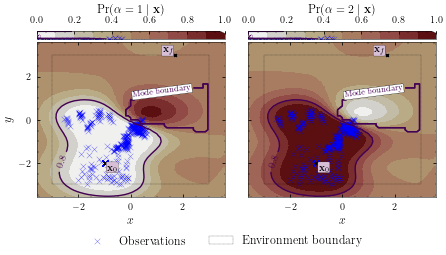

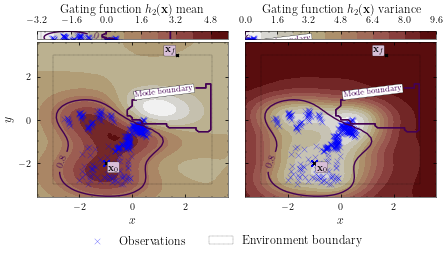

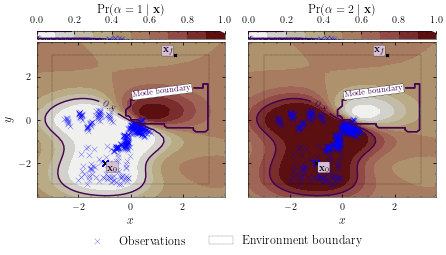

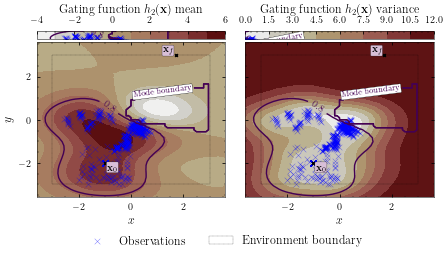

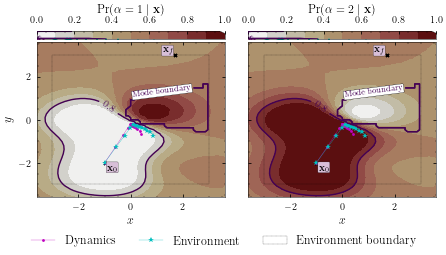

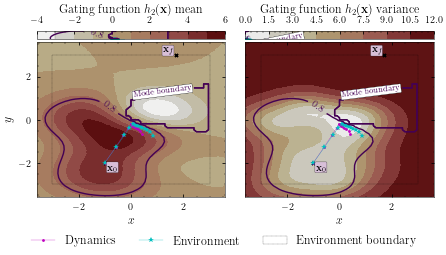

Epoch 1/10000
1/1 [==============================] - 2s 2s/step - loss: -589.7603 - val_loss: -684.4575
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_7_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -556.4028

2022-04-08 18:11:28.670392: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 18:11:28.670415: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 3s 3s/step - loss: -556.4028 - val_loss: -569.2409


2022-04-08 18:11:31.880573: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 18:11:31.912258: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 18:11:31.926335: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_11_31

2022-04-08 18:11:31.938049: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_11_31/dr-robots-mbp.local.trace.json.gz
2022-04-08 18:11:31.990460: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_11_31

2022-04-08 18:11:31.99080

Epoch 3/10000
1/1 [==============================] - 0s 67ms/step - loss: -599.5560 - val_loss: -662.7267
Epoch 4/10000
1/1 [==============================] - 0s 68ms/step - loss: -357.1121 - val_loss: -597.1911
Epoch 5/10000
1/1 [==============================] - 0s 68ms/step - loss: -660.8352 - val_loss: -686.2707
Epoch 6/10000
1/1 [==============================] - 0s 67ms/step - loss: -644.1394 - val_loss: -716.8081
Epoch 7/10000
1/1 [==============================] - 0s 61ms/step - loss: -681.8265 - val_loss: -723.3764
Epoch 8/10000
1/1 [==============================] - 0s 76ms/step - loss: -550.4945 - val_loss: -690.0785
Epoch 9/10000
1/1 [==============================] - 0s 66ms/step - loss: -684.7427 - val_loss: -730.6822
Epoch 10/10000
1/1 [==============================] - 0s 60ms/step - loss: -664.7239 - val_loss: -712.5585
Epoch 11/10000
1/1 [==============================] - 0s 64ms/step - loss: -674.1710 - val_loss: -722.7310
Epoch 12/10000
1/1 [========================

1/1 [==============================] - 0s 60ms/step - loss: -691.2886 - val_loss: -880.3675
Epoch 156/10000
1/1 [==============================] - 0s 65ms/step - loss: -749.2527 - val_loss: -808.0635
Epoch 157/10000
1/1 [==============================] - 0s 68ms/step - loss: -724.6750 - val_loss: -825.3125
Epoch 158/10000
1/1 [==============================] - 0s 64ms/step - loss: -776.7903 - val_loss: -832.4503
Epoch 159/10000
1/1 [==============================] - 0s 65ms/step - loss: -632.3608 - val_loss: -762.5761
Epoch 160/10000
1/1 [==============================] - 0s 67ms/step - loss: -341.6558 - val_loss: -214.8260
Epoch 161/10000
1/1 [==============================] - 0s 71ms/step - loss: -704.2898 - val_loss: -872.9802
Epoch 162/10000
1/1 [==============================] - 0s 75ms/step - loss: -650.4026 - val_loss: -755.6196
Epoch 163/10000
1/1 [==============================] - 0s 68ms/step - loss: -803.9299 - val_loss: -886.3473
Epoch 164/10000
1/1 [=======================

1/1 [==============================] - 0s 49ms/step - loss: -623.7307 - val_loss: -775.8629
Epoch 308/10000
1/1 [==============================] - 0s 50ms/step - loss: -706.9815 - val_loss: -804.4259
Epoch 309/10000
1/1 [==============================] - 0s 51ms/step - loss: -641.7157 - val_loss: -722.8994
Epoch 310/10000
1/1 [==============================] - 0s 49ms/step - loss: -693.7838 - val_loss: -789.7156
Epoch 311/10000
1/1 [==============================] - 0s 50ms/step - loss: -588.2882 - val_loss: -717.0351
Epoch 312/10000
1/1 [==============================] - 0s 51ms/step - loss: -670.1997 - val_loss: -787.3402
Epoch 313/10000
1/1 [==============================] - 0s 50ms/step - loss: -715.5314 - val_loss: -791.2840
Epoch 314/10000
1/1 [==============================] - 0s 50ms/step - loss: -455.1919 - val_loss: -704.8200
Epoch 315/10000
1/1 [==============================] - 0s 51ms/step - loss: -634.4818 - val_loss: -751.5856
Epoch 316/10000
1/1 [=======================

1/1 [==============================] - 0s 65ms/step - loss: -769.2498 - val_loss: -838.9981
Epoch 384/10000
1/1 [==============================] - 0s 75ms/step - loss: -677.9668 - val_loss: -804.9304
Epoch 385/10000
1/1 [==============================] - 0s 77ms/step - loss: -690.7187 - val_loss: -844.3087
Epoch 386/10000
1/1 [==============================] - 0s 69ms/step - loss: -705.8018 - val_loss: -856.7325
Epoch 387/10000
1/1 [==============================] - 0s 65ms/step - loss: -578.9452 - val_loss: -812.7328
Epoch 388/10000
1/1 [==============================] - 0s 77ms/step - loss: -308.2401 - val_loss: -754.7239
Epoch 389/10000
1/1 [==============================] - 0s 67ms/step - loss: -620.4842 - val_loss: -787.3166
Epoch 390/10000
1/1 [==============================] - 0s 60ms/step - loss: -774.2075 - val_loss: -847.4927
Epoch 391/10000
1/1 [==============================] - 0s 60ms/step - loss: -762.7450 - val_loss: -869.8583
Epoch 392/10000
1/1 [=======================

1/1 [==============================] - 0s 100ms/step - loss: -687.1712 - val_loss: -766.7209
Epoch 460/10000
1/1 [==============================] - 0s 92ms/step - loss: -351.9603 - val_loss: -645.8620
Epoch 461/10000
1/1 [==============================] - 0s 79ms/step - loss: -314.9844 - val_loss: -638.0002
Epoch 462/10000
1/1 [==============================] - 0s 70ms/step - loss: -621.2774 - val_loss: -689.9965
Epoch 463/10000
1/1 [==============================] - 0s 84ms/step - loss: -680.9676 - val_loss: -813.5703
Epoch 464/10000
1/1 [==============================] - 0s 79ms/step - loss: -627.6745 - val_loss: -797.7554
Epoch 465/10000
1/1 [==============================] - 0s 75ms/step - loss: 580.9980 - val_loss: 279.0020
Epoch 466/10000
1/1 [==============================] - 0s 76ms/step - loss: -728.1129 - val_loss: -837.1999
Epoch 467/10000
1/1 [==============================] - 0s 82ms/step - loss: -475.7799 - val_loss: -729.2074
Epoch 468/10000
1/1 [========================

Epoch 535/10000
1/1 [==============================] - 0s 68ms/step - loss: -752.3467 - val_loss: -836.7334
Epoch 536/10000
1/1 [==============================] - 0s 67ms/step - loss: -754.2056 - val_loss: -826.6496
Epoch 537/10000
1/1 [==============================] - 0s 72ms/step - loss: -722.1269 - val_loss: -818.1375
Epoch 538/10000
1/1 [==============================] - 0s 67ms/step - loss: -743.3358 - val_loss: -823.5250
Epoch 539/10000
1/1 [==============================] - 0s 77ms/step - loss: -665.3297 - val_loss: -785.1979
Epoch 540/10000
1/1 [==============================] - 0s 71ms/step - loss: -722.6998 - val_loss: -817.2606
Epoch 541/10000
1/1 [==============================] - 0s 69ms/step - loss: -670.4333 - val_loss: -797.8685
Epoch 542/10000
1/1 [==============================] - 0s 74ms/step - loss: -722.2269 - val_loss: -821.1370
Epoch 543/10000
1/1 [==============================] - 0s 78ms/step - loss: -669.9122 - val_loss: -801.2341
Epoch 544/10000
1/1 [=======

Epoch 611/10000
1/1 [==============================] - 0s 75ms/step - loss: -730.9886 - val_loss: -875.0551
Epoch 612/10000
1/1 [==============================] - 0s 70ms/step - loss: -784.0922 - val_loss: -886.1035
Epoch 613/10000
1/1 [==============================] - 0s 65ms/step - loss: -488.9121 - val_loss: -709.4122
Epoch 614/10000
1/1 [==============================] - 0s 75ms/step - loss: -181.9217 - val_loss: -811.1426
Epoch 615/10000
1/1 [==============================] - 0s 85ms/step - loss: -526.6849 - val_loss: -788.9891
Epoch 616/10000
1/1 [==============================] - 0s 82ms/step - loss: -296.4999 - val_loss: -688.7891
Epoch 617/10000
1/1 [==============================] - 0s 80ms/step - loss: -640.5474 - val_loss: -844.4669
Epoch 618/10000
1/1 [==============================] - 0s 72ms/step - loss: -570.4492 - val_loss: -791.0830
Epoch 619/10000
1/1 [==============================] - 0s 67ms/step - loss: -311.4358 - val_loss: -561.0308
Epoch 620/10000
1/1 [=======

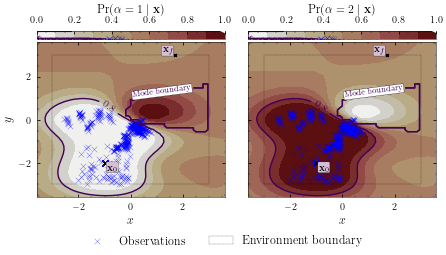

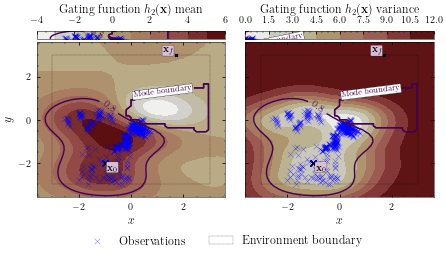

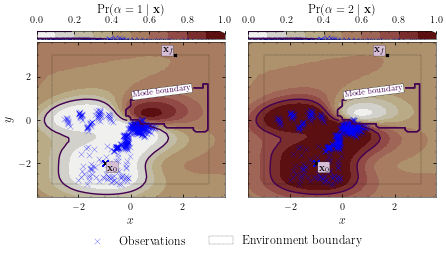

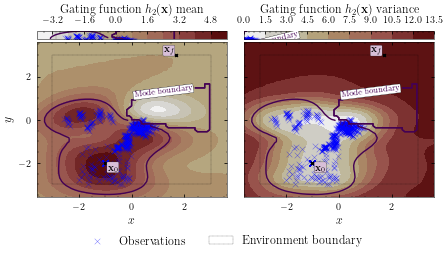

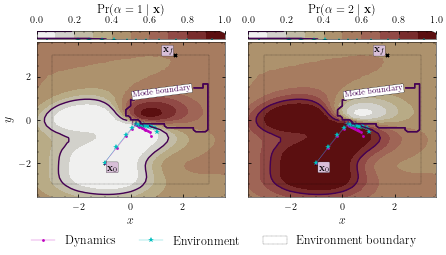

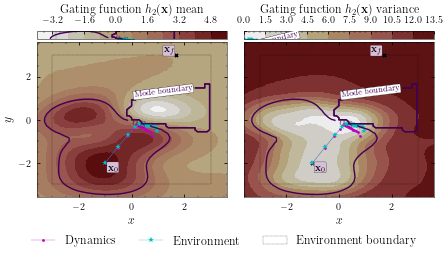

Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: -765.4516 - val_loss: -816.6269


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_8_epoch_0/assets
Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: 424.3402

2022-04-08 18:15:15.491258: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 18:15:15.491348: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-08 18:15:18.771453: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 18:15:18.811752: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 18:15:18.831787: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_15_18

2022-04-08 18:15:18.849885: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_15_18/dr-robots-mbp.local.trace.json.gz
2022-04-08 18:15:18.906466: I

1/1 [==============================] - 4s 4s/step - loss: 424.3402 - val_loss: -282.0750
Epoch 3/10000
1/1 [==============================] - 0s 89ms/step - loss: -709.2919 - val_loss: -621.8326
Epoch 4/10000
1/1 [==============================] - 0s 78ms/step - loss: -92.7467 - val_loss: -246.4887
Epoch 5/10000
1/1 [==============================] - 0s 70ms/step - loss: -237.3166 - val_loss: -517.9907
Epoch 6/10000
1/1 [==============================] - 0s 70ms/step - loss: -526.4553 - val_loss: -527.1395
Epoch 7/10000
1/1 [==============================] - 0s 75ms/step - loss: -257.6108 - val_loss: -643.1174
Epoch 8/10000
1/1 [==============================] - 0s 67ms/step - loss: -207.2468 - val_loss: -739.7510
Epoch 9/10000
1/1 [==============================] - 0s 71ms/step - loss: -674.9075 - val_loss: -808.9123
Epoch 10/10000
1/1 [==============================] - 0s 75ms/step - loss: -745.4396 - val_loss: -785.9311
Epoch 11/10000
1/1 [==============================] - 0s 81ms/s

Epoch 79/10000
1/1 [==============================] - 0s 64ms/step - loss: -687.2740 - val_loss: -748.6113
Epoch 80/10000
1/1 [==============================] - 0s 65ms/step - loss: -695.2317 - val_loss: -782.9587
Epoch 81/10000
1/1 [==============================] - 0s 65ms/step - loss: -753.9089 - val_loss: -807.1060
Epoch 82/10000
1/1 [==============================] - 0s 64ms/step - loss: -750.6538 - val_loss: -780.5913
Epoch 83/10000
1/1 [==============================] - 0s 69ms/step - loss: -771.5895 - val_loss: -779.0223
Epoch 84/10000
1/1 [==============================] - 0s 66ms/step - loss: -755.3485 - val_loss: -810.1654
Epoch 85/10000
1/1 [==============================] - 0s 65ms/step - loss: -711.4386 - val_loss: -705.3540
Epoch 86/10000
1/1 [==============================] - 0s 65ms/step - loss: -714.2052 - val_loss: -722.1685
Epoch 87/10000
1/1 [==============================] - 0s 66ms/step - loss: -741.7342 - val_loss: -786.5277
Epoch 88/10000
1/1 [=================

1/1 [==============================] - 0s 69ms/step - loss: -648.6528 - val_loss: -815.4436
Epoch 156/10000
1/1 [==============================] - 0s 64ms/step - loss: -789.6532 - val_loss: -826.8837
Epoch 157/10000
1/1 [==============================] - 0s 70ms/step - loss: -429.3773 - val_loss: -443.8718
Epoch 158/10000
1/1 [==============================] - 0s 69ms/step - loss: -570.4721 - val_loss: -797.2941
Epoch 159/10000
1/1 [==============================] - 0s 71ms/step - loss: -744.0651 - val_loss: -836.8734
Epoch 160/10000
1/1 [==============================] - 0s 70ms/step - loss: -771.1844 - val_loss: -851.3491
Epoch 161/10000
1/1 [==============================] - 0s 71ms/step - loss: -801.3095 - val_loss: -835.2567
Epoch 162/10000
1/1 [==============================] - 0s 70ms/step - loss: -769.6147 - val_loss: -839.4630
Epoch 163/10000
1/1 [==============================] - 0s 77ms/step - loss: -368.2907 - val_loss: -483.8716
Epoch 164/10000
1/1 [=======================

Epoch 231/10000
1/1 [==============================] - 0s 77ms/step - loss: -809.8097 - val_loss: -873.8953
Epoch 232/10000
1/1 [==============================] - 0s 67ms/step - loss: -841.5700 - val_loss: -876.8076
Epoch 233/10000
1/1 [==============================] - 0s 68ms/step - loss: -815.0501 - val_loss: -822.5191
Epoch 234/10000
1/1 [==============================] - 0s 62ms/step - loss: -770.2561 - val_loss: -845.5232
Epoch 235/10000
1/1 [==============================] - 0s 62ms/step - loss: -799.1368 - val_loss: -814.3031
Epoch 236/10000
1/1 [==============================] - 0s 71ms/step - loss: -802.2584 - val_loss: -874.2635
Epoch 237/10000
1/1 [==============================] - 0s 67ms/step - loss: -809.7256 - val_loss: -806.8817
Epoch 238/10000
1/1 [==============================] - 0s 62ms/step - loss: -735.9563 - val_loss: -818.7108
Epoch 239/10000
1/1 [==============================] - 0s 65ms/step - loss: -609.4136 - val_loss: -596.5662
Epoch 240/10000
1/1 [=======

Epoch 307/10000
1/1 [==============================] - 0s 90ms/step - loss: -636.9764 - val_loss: -638.5231
Epoch 308/10000
1/1 [==============================] - 0s 99ms/step - loss: -663.8341 - val_loss: -676.2147
Epoch 309/10000
1/1 [==============================] - 0s 79ms/step - loss: -649.5039 - val_loss: -671.0388
Epoch 310/10000
1/1 [==============================] - 0s 91ms/step - loss: -665.6199 - val_loss: -689.6922
Epoch 311/10000
1/1 [==============================] - 0s 96ms/step - loss: -589.8668 - val_loss: -667.2415
Epoch 312/10000
1/1 [==============================] - 0s 87ms/step - loss: -683.0873 - val_loss: -708.8349
Epoch 313/10000
1/1 [==============================] - 0s 85ms/step - loss: -482.9117 - val_loss: -592.7230
Epoch 314/10000
1/1 [==============================] - 0s 81ms/step - loss: -593.6714 - val_loss: -634.9916
Epoch 315/10000
1/1 [==============================] - 0s 89ms/step - loss: -633.3131 - val_loss: -673.6281
Epoch 316/10000
1/1 [=======

Epoch 383/10000
1/1 [==============================] - 0s 66ms/step - loss: -786.2708 - val_loss: -794.3667
Epoch 384/10000
1/1 [==============================] - 0s 63ms/step - loss: -502.5489 - val_loss: -658.3572
Epoch 385/10000
1/1 [==============================] - 0s 65ms/step - loss: -646.4487 - val_loss: -700.3980
Epoch 386/10000
1/1 [==============================] - 0s 66ms/step - loss: -642.4144 - val_loss: -760.0038
Epoch 387/10000
1/1 [==============================] - 0s 63ms/step - loss: -726.1332 - val_loss: -793.8504
Epoch 388/10000
1/1 [==============================] - 0s 66ms/step - loss: -770.1156 - val_loss: -750.9901
Epoch 389/10000
1/1 [==============================] - 0s 67ms/step - loss: -481.7412 - val_loss: -803.2431
Epoch 390/10000
1/1 [==============================] - 0s 66ms/step - loss: -756.3982 - val_loss: -762.6958
Epoch 391/10000
1/1 [==============================] - 0s 63ms/step - loss: -22.5133 - val_loss: -545.1770
Epoch 392/10000
1/1 [========

Epoch 459/10000
1/1 [==============================] - 0s 66ms/step - loss: -807.6838 - val_loss: -852.4346
Epoch 460/10000
1/1 [==============================] - 0s 64ms/step - loss: -830.4399 - val_loss: -866.3840
Epoch 461/10000
1/1 [==============================] - 0s 61ms/step - loss: -817.4432 - val_loss: -864.1505
Epoch 462/10000
1/1 [==============================] - 0s 63ms/step - loss: -824.8085 - val_loss: -860.0205
Epoch 463/10000
1/1 [==============================] - 0s 61ms/step - loss: -817.1285 - val_loss: -859.4362
Epoch 464/10000
1/1 [==============================] - 0s 63ms/step - loss: -764.3985 - val_loss: -776.7657
Epoch 465/10000
1/1 [==============================] - 0s 61ms/step - loss: -800.5716 - val_loss: -829.7652
Epoch 466/10000
1/1 [==============================] - 0s 60ms/step - loss: -777.9332 - val_loss: -800.6051
Epoch 467/10000
1/1 [==============================] - 0s 67ms/step - loss: -830.8306 - val_loss: -869.7477
Epoch 468/10000
1/1 [=======

Epoch 535/10000
1/1 [==============================] - 0s 79ms/step - loss: -402.6969 - val_loss: -840.6871
Epoch 536/10000
1/1 [==============================] - 0s 73ms/step - loss: -771.4820 - val_loss: -779.4091
Epoch 537/10000
1/1 [==============================] - 0s 74ms/step - loss: -640.7224 - val_loss: -554.3513
Epoch 538/10000
1/1 [==============================] - 0s 68ms/step - loss: -657.5120 - val_loss: -754.7711
Epoch 539/10000
1/1 [==============================] - 0s 72ms/step - loss: -691.5464 - val_loss: -790.0996
Epoch 540/10000
1/1 [==============================] - 0s 67ms/step - loss: -746.5062 - val_loss: -867.1423
Epoch 541/10000
1/1 [==============================] - 0s 75ms/step - loss: -727.0540 - val_loss: -816.1187
Epoch 542/10000
1/1 [==============================] - 0s 75ms/step - loss: -860.7792 - val_loss: -924.4589
Epoch 543/10000
1/1 [==============================] - 0s 71ms/step - loss: -780.9517 - val_loss: -856.8176
Epoch 544/10000
1/1 [=======

Epoch 611/10000
1/1 [==============================] - 0s 66ms/step - loss: -757.9459 - val_loss: -764.6926
Epoch 612/10000
1/1 [==============================] - 0s 65ms/step - loss: 216.3508 - val_loss: -82.9899
Epoch 613/10000
1/1 [==============================] - 0s 63ms/step - loss: 103.4672 - val_loss: -540.5079
Epoch 614/10000
1/1 [==============================] - 0s 61ms/step - loss: -591.2110 - val_loss: -724.2225
Epoch 615/10000
1/1 [==============================] - 0s 63ms/step - loss: -788.0026 - val_loss: -792.4126
Epoch 616/10000
1/1 [==============================] - 0s 62ms/step - loss: -735.9246 - val_loss: -760.0467
Epoch 617/10000
1/1 [==============================] - 0s 60ms/step - loss: -801.3441 - val_loss: -828.6563
Epoch 618/10000
1/1 [==============================] - 0s 62ms/step - loss: -821.7748 - val_loss: -838.7751
Epoch 619/10000
1/1 [==============================] - 0s 62ms/step - loss: -785.3241 - val_loss: -821.4146
Epoch 620/10000
1/1 [==========

Epoch 687/10000
1/1 [==============================] - 0s 60ms/step - loss: -816.1465 - val_loss: -856.5086
Epoch 688/10000
1/1 [==============================] - 0s 60ms/step - loss: -784.7606 - val_loss: -773.2074
Epoch 689/10000
1/1 [==============================] - 0s 58ms/step - loss: -820.8494 - val_loss: -856.7064
Epoch 690/10000
1/1 [==============================] - 0s 60ms/step - loss: -824.2353 - val_loss: -854.0788
Epoch 691/10000
1/1 [==============================] - 0s 60ms/step - loss: -801.6120 - val_loss: -847.7633
Epoch 692/10000
1/1 [==============================] - 0s 58ms/step - loss: -793.2840 - val_loss: -845.9922
Epoch 693/10000
1/1 [==============================] - 0s 61ms/step - loss: -827.2995 - val_loss: -859.8049
Epoch 694/10000
1/1 [==============================] - 0s 58ms/step - loss: -814.0899 - val_loss: -835.5655
Epoch 695/10000
1/1 [==============================] - 0s 58ms/step - loss: -816.2922 - val_loss: -847.7193
Epoch 696/10000
1/1 [=======

Epoch 763/10000
1/1 [==============================] - 0s 73ms/step - loss: -631.2339 - val_loss: -787.5459
Epoch 764/10000
1/1 [==============================] - 0s 69ms/step - loss: -852.1383 - val_loss: -879.8100
Epoch 765/10000
1/1 [==============================] - 0s 72ms/step - loss: -828.1909 - val_loss: -834.4763
Epoch 766/10000
1/1 [==============================] - 0s 68ms/step - loss: -639.1663 - val_loss: -848.2921
Epoch 767/10000
1/1 [==============================] - 0s 63ms/step - loss: -615.5101 - val_loss: -819.5553
Epoch 768/10000
1/1 [==============================] - 0s 71ms/step - loss: -829.6198 - val_loss: -881.7280
Epoch 769/10000
1/1 [==============================] - 0s 71ms/step - loss: -806.6444 - val_loss: -879.3502
Epoch 770/10000
1/1 [==============================] - 0s 69ms/step - loss: -741.7426 - val_loss: -838.6158
Epoch 771/10000
1/1 [==============================] - 0s 71ms/step - loss: -473.4368 - val_loss: -594.4892
Epoch 772/10000
1/1 [=======

Epoch 839/10000
1/1 [==============================] - 0s 64ms/step - loss: -852.3115 - val_loss: -898.5621
Epoch 840/10000
1/1 [==============================] - 0s 61ms/step - loss: -731.9621 - val_loss: -800.3376
Epoch 841/10000
1/1 [==============================] - 0s 63ms/step - loss: -849.8926 - val_loss: -865.4927
Epoch 842/10000
1/1 [==============================] - 0s 61ms/step - loss: -857.4787 - val_loss: -906.1439
Epoch 843/10000
1/1 [==============================] - 0s 61ms/step - loss: -825.6765 - val_loss: -878.8544
Epoch 844/10000
1/1 [==============================] - 0s 60ms/step - loss: -850.2887 - val_loss: -876.8006
Epoch 845/10000
1/1 [==============================] - 0s 62ms/step - loss: -848.2455 - val_loss: -850.1942
Epoch 846/10000
1/1 [==============================] - 0s 64ms/step - loss: -821.6016 - val_loss: -842.5837
Epoch 847/10000
1/1 [==============================] - 0s 60ms/step - loss: -738.8301 - val_loss: -887.6980
Epoch 848/10000
1/1 [=======

Epoch 915/10000
1/1 [==============================] - 0s 72ms/step - loss: -516.0505 - val_loss: -739.6068
Epoch 916/10000
1/1 [==============================] - 0s 68ms/step - loss: -766.3448 - val_loss: -850.4757
Epoch 917/10000
1/1 [==============================] - 0s 63ms/step - loss: -716.4797 - val_loss: -825.2227
Epoch 918/10000
1/1 [==============================] - 0s 63ms/step - loss: -779.9569 - val_loss: -860.7163
Epoch 919/10000
1/1 [==============================] - 0s 63ms/step - loss: -800.0320 - val_loss: -815.2550
Epoch 920/10000
1/1 [==============================] - 0s 76ms/step - loss: -809.1449 - val_loss: -845.9350
Epoch 921/10000
1/1 [==============================] - 0s 71ms/step - loss: -743.0572 - val_loss: -798.8690
Epoch 922/10000
1/1 [==============================] - 0s 66ms/step - loss: -508.1376 - val_loss: -749.8677
Epoch 923/10000
1/1 [==============================] - 0s 65ms/step - loss: -777.4570 - val_loss: -869.1577
Epoch 924/10000
1/1 [=======

Epoch 991/10000
1/1 [==============================] - 0s 75ms/step - loss: -802.6514 - val_loss: -835.4117
Epoch 992/10000
1/1 [==============================] - 0s 74ms/step - loss: -637.7393 - val_loss: -643.4468
Epoch 993/10000
1/1 [==============================] - 0s 79ms/step - loss: -685.4126 - val_loss: -805.8045
Epoch 994/10000
1/1 [==============================] - 0s 73ms/step - loss: -785.9928 - val_loss: -805.4086
Epoch 995/10000
1/1 [==============================] - 0s 72ms/step - loss: -545.7302 - val_loss: -583.8770
Epoch 996/10000
1/1 [==============================] - 0s 74ms/step - loss: -595.0090 - val_loss: -633.7848
Epoch 997/10000
1/1 [==============================] - 0s 76ms/step - loss: -203.2236 - val_loss: -613.2620
Epoch 998/10000
1/1 [==============================] - 0s 71ms/step - loss: -466.6367 - val_loss: -510.6874
Epoch 999/10000
1/1 [==============================] - 0s 81ms/step - loss: -728.9599 - val_loss: -809.2282
Epoch 1000/10000
1/1 [======

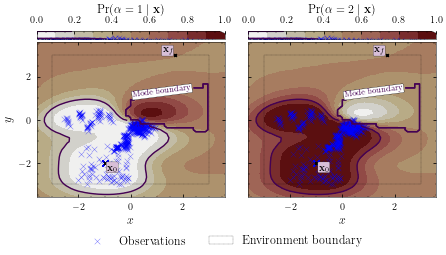

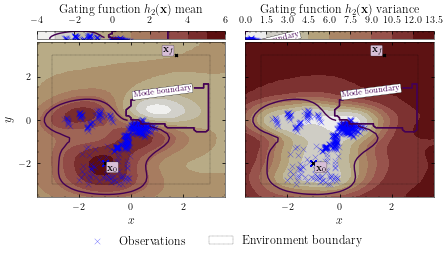

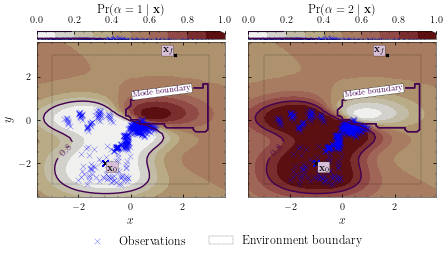

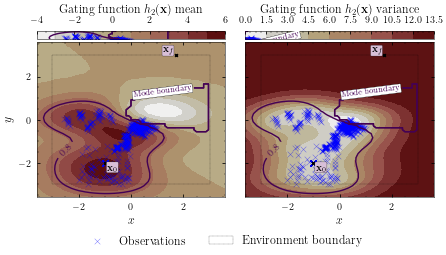

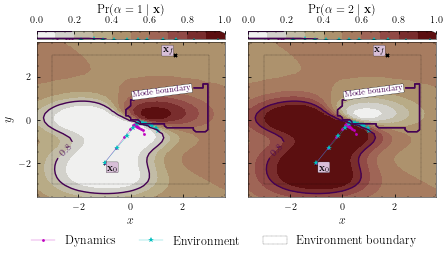

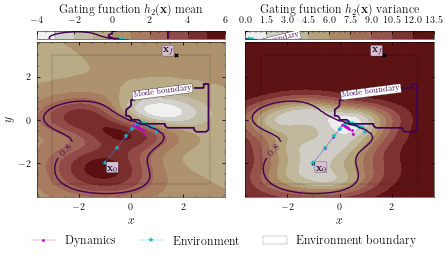

Epoch 1/10000
1/1 [==============================] - 4s 4s/step - loss: -436.5673 - val_loss: -568.9726
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_9_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -637.6352

2022-04-08 18:19:23.174420: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 18:19:23.174438: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -637.6352 - val_loss: -587.5802
Epoch 3/10000
1/1 [==============================] - 0s 46ms/step - loss: -685.4615 - val_loss: -756.4894


2022-04-08 18:19:25.257270: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 18:19:25.279511: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 18:19:25.293177: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_19_25

2022-04-08 18:19:25.305451: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_19_25/dr-robots-mbp.local.trace.json.gz
2022-04-08 18:19:25.340862: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_19_25

2022-04-08 18:19:25.34112

Epoch 4/10000
1/1 [==============================] - 0s 49ms/step - loss: -664.3140 - val_loss: -684.4679
Epoch 5/10000
1/1 [==============================] - 0s 51ms/step - loss: -659.8507 - val_loss: -729.8037
Epoch 6/10000
1/1 [==============================] - 0s 50ms/step - loss: -736.9462 - val_loss: -753.1940
Epoch 7/10000
1/1 [==============================] - 0s 49ms/step - loss: -311.3716 - val_loss: -285.6205
Epoch 8/10000
1/1 [==============================] - 0s 51ms/step - loss: -730.5822 - val_loss: -745.7194
Epoch 9/10000
1/1 [==============================] - 0s 49ms/step - loss: -627.9628 - val_loss: -705.4057
Epoch 10/10000
1/1 [==============================] - 0s 48ms/step - loss: -516.0971 - val_loss: -472.4570
Epoch 11/10000
1/1 [==============================] - 0s 50ms/step - loss: -674.7537 - val_loss: -672.3265
Epoch 12/10000
1/1 [==============================] - 0s 51ms/step - loss: 212.7026 - val_loss: 356.8725
Epoch 13/10000
1/1 [=========================

1/1 [==============================] - 0s 51ms/step - loss: -796.2525 - val_loss: -847.0748
Epoch 157/10000
1/1 [==============================] - 0s 52ms/step - loss: -770.9499 - val_loss: -741.6155
Epoch 158/10000
1/1 [==============================] - 0s 53ms/step - loss: -798.7414 - val_loss: -848.5929
Epoch 159/10000
1/1 [==============================] - 0s 51ms/step - loss: -62.0852 - val_loss: -537.5489
Epoch 160/10000
1/1 [==============================] - 0s 51ms/step - loss: -307.4161 - val_loss: -719.8694
Epoch 161/10000
1/1 [==============================] - 0s 50ms/step - loss: -837.3158 - val_loss: -842.0387
Epoch 162/10000
1/1 [==============================] - 0s 49ms/step - loss: -704.8385 - val_loss: -461.4914
Epoch 163/10000
1/1 [==============================] - 0s 51ms/step - loss: -585.6423 - val_loss: -744.6597
Epoch 164/10000
1/1 [==============================] - 0s 69ms/step - loss: -505.9249 - val_loss: -691.5921
Epoch 165/10000
1/1 [========================

1/1 [==============================] - 0s 57ms/step - loss: -836.0842 - val_loss: -853.2228
Epoch 233/10000
1/1 [==============================] - 0s 51ms/step - loss: -793.6335 - val_loss: -855.7172
Epoch 234/10000
1/1 [==============================] - 0s 52ms/step - loss: -768.3766 - val_loss: -797.9079
Epoch 235/10000
1/1 [==============================] - 0s 51ms/step - loss: -811.7868 - val_loss: -863.7413
Epoch 236/10000
1/1 [==============================] - 0s 48ms/step - loss: -839.8858 - val_loss: -866.9114
Epoch 237/10000
1/1 [==============================] - 0s 49ms/step - loss: -831.9013 - val_loss: -863.1687
Epoch 238/10000
1/1 [==============================] - 0s 46ms/step - loss: -797.8578 - val_loss: -821.4029
Epoch 239/10000
1/1 [==============================] - 0s 50ms/step - loss: -204.9766 - val_loss: -301.4102
Epoch 240/10000
1/1 [==============================] - 0s 49ms/step - loss: -684.9926 - val_loss: -743.5860
Epoch 241/10000
1/1 [=======================

1/1 [==============================] - 0s 48ms/step - loss: -768.4023 - val_loss: -798.6765
Epoch 385/10000
1/1 [==============================] - 0s 48ms/step - loss: -781.9237 - val_loss: -812.8769
Epoch 386/10000
1/1 [==============================] - 0s 49ms/step - loss: -672.8545 - val_loss: -803.1717
Epoch 387/10000
1/1 [==============================] - 0s 50ms/step - loss: -640.2026 - val_loss: -827.9160
Epoch 388/10000
1/1 [==============================] - 0s 48ms/step - loss: -700.9851 - val_loss: -825.3382
Epoch 389/10000
1/1 [==============================] - 0s 51ms/step - loss: -619.8867 - val_loss: -809.4401
Epoch 390/10000
1/1 [==============================] - 0s 49ms/step - loss: -733.4823 - val_loss: -805.1317
Epoch 391/10000
1/1 [==============================] - 0s 49ms/step - loss: -583.0916 - val_loss: -786.7510
Epoch 392/10000
1/1 [==============================] - 0s 49ms/step - loss: -736.7168 - val_loss: -770.5328
Epoch 393/10000
1/1 [=======================

1/1 [==============================] - 0s 50ms/step - loss: -809.1065 - val_loss: -862.2274
Epoch 461/10000
1/1 [==============================] - 0s 51ms/step - loss: -805.3682 - val_loss: -845.1723
Epoch 462/10000
1/1 [==============================] - 0s 52ms/step - loss: -647.7918 - val_loss: -819.6715
Epoch 463/10000
1/1 [==============================] - 0s 52ms/step - loss: -839.1220 - val_loss: -855.7985
Epoch 464/10000
1/1 [==============================] - 0s 58ms/step - loss: -771.3945 - val_loss: -869.9192
Epoch 465/10000
1/1 [==============================] - 0s 58ms/step - loss: -746.5623 - val_loss: -828.2531
Epoch 466/10000
1/1 [==============================] - 0s 60ms/step - loss: -800.8326 - val_loss: -844.4124
Epoch 467/10000
1/1 [==============================] - 0s 56ms/step - loss: -782.1165 - val_loss: -834.9959
Epoch 468/10000
1/1 [==============================] - 0s 55ms/step - loss: -783.4961 - val_loss: -853.7740
Epoch 469/10000
1/1 [=======================

1/1 [==============================] - 0s 47ms/step - loss: -690.9268 - val_loss: -745.8532
Epoch 537/10000
1/1 [==============================] - 0s 57ms/step - loss: -783.3349 - val_loss: -837.6526
Epoch 538/10000
1/1 [==============================] - 0s 57ms/step - loss: -783.5117 - val_loss: -826.6988
Epoch 539/10000
1/1 [==============================] - 0s 56ms/step - loss: -790.0945 - val_loss: -823.1651
Epoch 540/10000
1/1 [==============================] - 0s 48ms/step - loss: -770.8017 - val_loss: -811.2592
Epoch 541/10000
1/1 [==============================] - 0s 49ms/step - loss: -775.9395 - val_loss: -813.1639
Epoch 542/10000
1/1 [==============================] - 0s 48ms/step - loss: -594.8629 - val_loss: -776.3939
Epoch 543/10000
1/1 [==============================] - 0s 52ms/step - loss: -691.9583 - val_loss: -760.6300
Epoch 544/10000
1/1 [==============================] - 0s 50ms/step - loss: -816.1491 - val_loss: -830.0182
Epoch 545/10000
1/1 [=======================

1/1 [==============================] - 0s 46ms/step - loss: -775.4858 - val_loss: -887.5030
Epoch 613/10000
1/1 [==============================] - 0s 47ms/step - loss: -824.8513 - val_loss: -884.9678
Epoch 614/10000
1/1 [==============================] - 0s 48ms/step - loss: -735.5787 - val_loss: -787.2955
Epoch 615/10000
1/1 [==============================] - 0s 46ms/step - loss: -691.5761 - val_loss: -733.6531
Epoch 616/10000
1/1 [==============================] - 0s 48ms/step - loss: -761.4347 - val_loss: -856.0509
Epoch 617/10000
1/1 [==============================] - 0s 47ms/step - loss: -548.4177 - val_loss: -729.0764
Epoch 618/10000
1/1 [==============================] - 0s 46ms/step - loss: -828.9154 - val_loss: -851.1169
Epoch 619/10000
1/1 [==============================] - 0s 48ms/step - loss: -822.6043 - val_loss: -841.3731
Epoch 620/10000
1/1 [==============================] - 0s 47ms/step - loss: -848.7719 - val_loss: -885.1913
Epoch 621/10000
1/1 [=======================

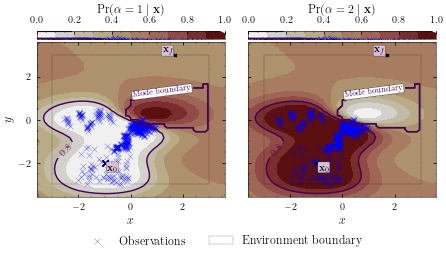

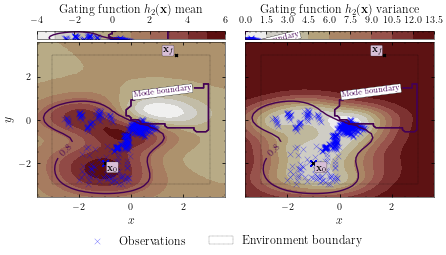

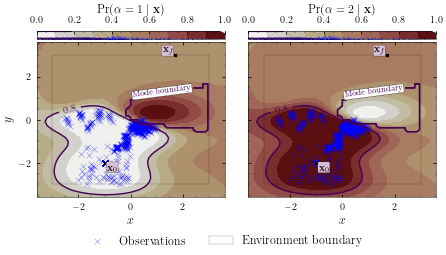

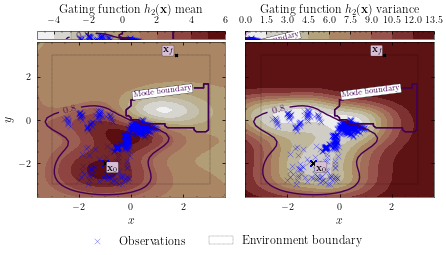

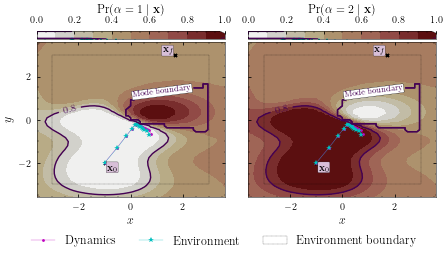

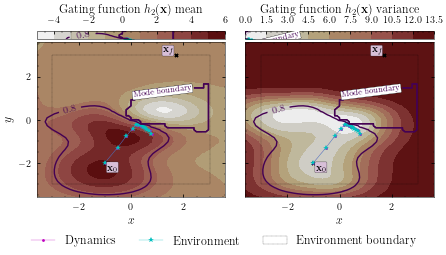

Epoch 1/10000
1/1 [==============================] - 1s 775ms/step - loss: -793.9245 - val_loss: -896.6560
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_10_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -846.5632

2022-04-08 18:21:47.388042: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 18:21:47.388074: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 3s 3s/step - loss: -846.5632 - val_loss: -891.4030


2022-04-08 18:21:49.966143: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 18:21:49.998286: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 18:21:50.015758: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_21_49

2022-04-08 18:21:50.025923: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_21_49/dr-robots-mbp.local.trace.json.gz
2022-04-08 18:21:50.065364: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_21_49

2022-04-08 18:21:50.06569

Epoch 3/10000
1/1 [==============================] - 0s 78ms/step - loss: -815.2864 - val_loss: -851.2389
Epoch 4/10000
1/1 [==============================] - 0s 67ms/step - loss: -799.8694 - val_loss: -860.9451
Epoch 5/10000
1/1 [==============================] - 0s 72ms/step - loss: -838.2609 - val_loss: -887.7030
Epoch 6/10000
1/1 [==============================] - 0s 97ms/step - loss: -696.3110 - val_loss: -856.7011
Epoch 7/10000
1/1 [==============================] - 0s 59ms/step - loss: -800.7482 - val_loss: -879.1119
Epoch 8/10000
1/1 [==============================] - 0s 52ms/step - loss: -839.4034 - val_loss: -839.5235
Epoch 9/10000
1/1 [==============================] - 0s 52ms/step - loss: -650.5355 - val_loss: -794.1212
Epoch 10/10000
1/1 [==============================] - 0s 65ms/step - loss: -769.6343 - val_loss: -839.1701
Epoch 11/10000
1/1 [==============================] - 0s 60ms/step - loss: -796.3519 - val_loss: -894.1268
Epoch 12/10000
1/1 [========================

1/1 [==============================] - 0s 48ms/step - loss: -735.3801 - val_loss: -832.8017
Epoch 156/10000
1/1 [==============================] - 0s 50ms/step - loss: -788.4880 - val_loss: -776.3288
Epoch 157/10000
1/1 [==============================] - 0s 48ms/step - loss: -763.5685 - val_loss: -829.2961
Epoch 158/10000
1/1 [==============================] - 0s 50ms/step - loss: -618.5060 - val_loss: -738.2049
Epoch 159/10000
1/1 [==============================] - 0s 50ms/step - loss: -554.5115 - val_loss: -835.3466
Epoch 160/10000
1/1 [==============================] - 0s 52ms/step - loss: -875.1680 - val_loss: -930.5215
Epoch 161/10000
1/1 [==============================] - 0s 52ms/step - loss: -829.2880 - val_loss: -841.4052
Epoch 162/10000
1/1 [==============================] - 0s 53ms/step - loss: -818.9376 - val_loss: -886.1162
Epoch 163/10000
1/1 [==============================] - 0s 51ms/step - loss: -623.9775 - val_loss: -826.9764
Epoch 164/10000
1/1 [=======================

1/1 [==============================] - 0s 49ms/step - loss: -613.0020 - val_loss: -713.9446
Epoch 232/10000
1/1 [==============================] - 0s 48ms/step - loss: -812.8559 - val_loss: -885.0440
Epoch 233/10000
1/1 [==============================] - 0s 48ms/step - loss: -479.2393 - val_loss: -825.4378
Epoch 234/10000
1/1 [==============================] - 0s 47ms/step - loss: -773.2798 - val_loss: -849.9444
Epoch 235/10000
1/1 [==============================] - 0s 48ms/step - loss: -759.9961 - val_loss: -777.6247
Epoch 236/10000
1/1 [==============================] - 0s 48ms/step - loss: 1112.9195 - val_loss: 1078.2456
Epoch 237/10000
1/1 [==============================] - 0s 48ms/step - loss: -743.0330 - val_loss: -814.7630
Epoch 238/10000
1/1 [==============================] - 0s 50ms/step - loss: -728.9433 - val_loss: -767.7302
Epoch 239/10000
1/1 [==============================] - 0s 48ms/step - loss: 563.8827 - val_loss: 182.6888
Epoch 240/10000
1/1 [=========================

1/1 [==============================] - 0s 48ms/step - loss: -649.8964 - val_loss: -743.3719
Epoch 308/10000
1/1 [==============================] - 0s 48ms/step - loss: -760.9759 - val_loss: -832.3163
Epoch 309/10000
1/1 [==============================] - 0s 48ms/step - loss: -811.7850 - val_loss: -864.1182
Epoch 310/10000
1/1 [==============================] - 0s 48ms/step - loss: -786.8428 - val_loss: -833.1119
Epoch 311/10000
1/1 [==============================] - 0s 48ms/step - loss: -806.6964 - val_loss: -855.0934
Epoch 312/10000
1/1 [==============================] - 0s 48ms/step - loss: -798.7970 - val_loss: -842.2572
Epoch 313/10000
1/1 [==============================] - 0s 49ms/step - loss: -819.5427 - val_loss: -862.3981
Epoch 314/10000
1/1 [==============================] - 0s 48ms/step - loss: -816.8005 - val_loss: -865.5069
Epoch 315/10000
1/1 [==============================] - 0s 48ms/step - loss: -770.2156 - val_loss: -804.3899
Epoch 316/10000
1/1 [=======================

1/1 [==============================] - 0s 50ms/step - loss: -920.8238 - val_loss: -959.1412
Epoch 384/10000
1/1 [==============================] - 0s 49ms/step - loss: -892.3655 - val_loss: -952.8295
Epoch 385/10000
1/1 [==============================] - 0s 53ms/step - loss: -894.5916 - val_loss: -961.3329
Epoch 386/10000
1/1 [==============================] - 0s 51ms/step - loss: -909.3747 - val_loss: -957.6705
Epoch 387/10000
1/1 [==============================] - 0s 54ms/step - loss: -902.7089 - val_loss: -957.8038
Epoch 388/10000
1/1 [==============================] - 0s 50ms/step - loss: -917.3142 - val_loss: -963.8629
Epoch 389/10000
1/1 [==============================] - 0s 49ms/step - loss: -858.8890 - val_loss: -966.1987
Epoch 390/10000
1/1 [==============================] - 0s 51ms/step - loss: -900.5551 - val_loss: -955.1586
Epoch 391/10000
1/1 [==============================] - 0s 50ms/step - loss: -848.6331 - val_loss: -964.3565
Epoch 392/10000
1/1 [=======================

1/1 [==============================] - 0s 54ms/step - loss: -745.0596 - val_loss: -790.8277
Epoch 460/10000
1/1 [==============================] - 0s 54ms/step - loss: -775.3947 - val_loss: -843.2562
Epoch 461/10000
1/1 [==============================] - 0s 53ms/step - loss: -558.7464 - val_loss: -642.3469
Epoch 462/10000
1/1 [==============================] - 0s 53ms/step - loss: -738.1778 - val_loss: -757.8726
Epoch 463/10000
1/1 [==============================] - 0s 52ms/step - loss: -752.4723 - val_loss: -759.6367
Epoch 464/10000
1/1 [==============================] - 0s 56ms/step - loss: -686.3650 - val_loss: -761.7106
Epoch 465/10000
1/1 [==============================] - 0s 57ms/step - loss: -700.8864 - val_loss: -742.1431
Epoch 466/10000
1/1 [==============================] - 0s 54ms/step - loss: -707.9539 - val_loss: -783.4336
Epoch 467/10000
1/1 [==============================] - 0s 52ms/step - loss: -542.7404 - val_loss: -557.9556
Epoch 468/10000
1/1 [=======================

1/1 [==============================] - 0s 52ms/step - loss: -838.1104 - val_loss: -915.9786
Epoch 536/10000
1/1 [==============================] - 0s 51ms/step - loss: -839.2115 - val_loss: -896.2912
Epoch 537/10000
1/1 [==============================] - 0s 51ms/step - loss: -567.7321 - val_loss: -813.8126
Epoch 538/10000
1/1 [==============================] - 0s 50ms/step - loss: -795.0132 - val_loss: -892.1725
Epoch 539/10000
1/1 [==============================] - 0s 51ms/step - loss: -835.2608 - val_loss: -889.8261
Epoch 540/10000
1/1 [==============================] - 0s 49ms/step - loss: -876.1510 - val_loss: -927.0576
Epoch 541/10000
1/1 [==============================] - 0s 52ms/step - loss: -867.4795 - val_loss: -918.4005
Epoch 542/10000
1/1 [==============================] - 0s 51ms/step - loss: -802.9475 - val_loss: -886.5100
Epoch 543/10000
1/1 [==============================] - 0s 50ms/step - loss: -840.6025 - val_loss: -894.3266
Epoch 544/10000
1/1 [=======================

1/1 [==============================] - 0s 50ms/step - loss: -644.2376 - val_loss: -938.7829
Epoch 612/10000
1/1 [==============================] - 0s 49ms/step - loss: -770.8092 - val_loss: -904.3617
Epoch 613/10000
1/1 [==============================] - 0s 50ms/step - loss: -866.9667 - val_loss: -923.2863
Epoch 614/10000
1/1 [==============================] - 0s 50ms/step - loss: -618.9192 - val_loss: -709.7246
Epoch 615/10000
1/1 [==============================] - 0s 50ms/step - loss: -796.6295 - val_loss: -862.5701
Epoch 616/10000
1/1 [==============================] - 0s 49ms/step - loss: -477.2101 - val_loss: -692.2809
Epoch 617/10000
1/1 [==============================] - 0s 49ms/step - loss: -640.7151 - val_loss: -859.4710
Epoch 618/10000
1/1 [==============================] - 0s 50ms/step - loss: -532.8892 - val_loss: -670.0339
Epoch 619/10000
1/1 [==============================] - 0s 50ms/step - loss: -619.2483 - val_loss: -826.1781
Epoch 620/10000
1/1 [=======================

1/1 [==============================] - 0s 53ms/step - loss: -715.5245 - val_loss: -743.7233
Epoch 688/10000
1/1 [==============================] - 0s 52ms/step - loss: -593.8623 - val_loss: -687.9743
Epoch 689/10000
1/1 [==============================] - 0s 51ms/step - loss: -718.8110 - val_loss: -757.2623
Epoch 690/10000
1/1 [==============================] - 0s 50ms/step - loss: -710.1452 - val_loss: -725.1197
Epoch 691/10000
1/1 [==============================] - 0s 51ms/step - loss: -700.2858 - val_loss: -721.8468
Epoch 692/10000
1/1 [==============================] - 0s 50ms/step - loss: -696.4422 - val_loss: -724.6702
Epoch 693/10000
1/1 [==============================] - 0s 50ms/step - loss: -638.1565 - val_loss: -708.4741
Epoch 694/10000
1/1 [==============================] - 0s 50ms/step - loss: -659.2524 - val_loss: -692.4765
Epoch 695/10000
1/1 [==============================] - 0s 50ms/step - loss: -745.9624 - val_loss: -767.2040
Epoch 696/10000
1/1 [=======================

1/1 [==============================] - 0s 52ms/step - loss: -806.9642 - val_loss: -863.1200
Epoch 764/10000
1/1 [==============================] - 0s 51ms/step - loss: -855.9928 - val_loss: -893.2795
Epoch 765/10000
1/1 [==============================] - 0s 50ms/step - loss: -741.5430 - val_loss: -838.0477
Epoch 766/10000
1/1 [==============================] - 0s 50ms/step - loss: -789.8472 - val_loss: -855.0525
Epoch 767/10000
1/1 [==============================] - 0s 50ms/step - loss: -850.4223 - val_loss: -889.2960
Epoch 768/10000
1/1 [==============================] - 0s 52ms/step - loss: -853.5556 - val_loss: -877.6207
Epoch 769/10000
1/1 [==============================] - 0s 62ms/step - loss: -801.3803 - val_loss: -818.3098
Epoch 770/10000
1/1 [==============================] - 0s 50ms/step - loss: -849.9022 - val_loss: -889.3345
Epoch 771/10000
1/1 [==============================] - 0s 49ms/step - loss: -846.4418 - val_loss: -898.9124
Epoch 772/10000
1/1 [=======================

Epoch 839/10000
1/1 [==============================] - 0s 51ms/step - loss: -820.4216 - val_loss: -903.5599
Epoch 840/10000
1/1 [==============================] - 0s 51ms/step - loss: -839.5233 - val_loss: -888.3080
Epoch 841/10000
1/1 [==============================] - 0s 52ms/step - loss: -848.0804 - val_loss: -912.3966
Epoch 842/10000
1/1 [==============================] - 0s 50ms/step - loss: -858.5401 - val_loss: -897.3286
Epoch 843/10000
1/1 [==============================] - 0s 51ms/step - loss: -874.2902 - val_loss: -922.2197
Epoch 844/10000
1/1 [==============================] - 0s 51ms/step - loss: -872.7098 - val_loss: -916.2979
Epoch 845/10000
1/1 [==============================] - 0s 50ms/step - loss: -879.9144 - val_loss: -924.0745
Epoch 846/10000
1/1 [==============================] - 0s 49ms/step - loss: -840.5453 - val_loss: -920.6870
Epoch 847/10000
1/1 [==============================] - 0s 49ms/step - loss: -808.1878 - val_loss: -904.6235
Epoch 848/10000
1/1 [=======

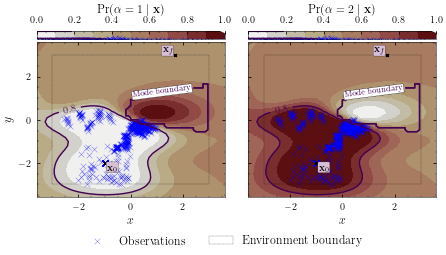

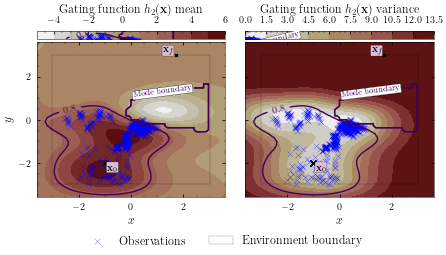

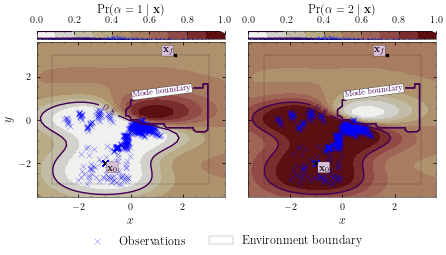

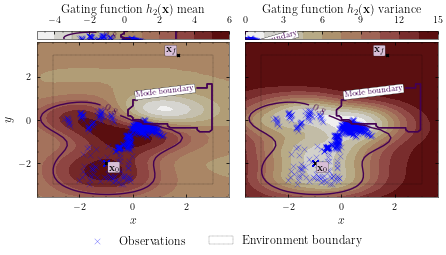

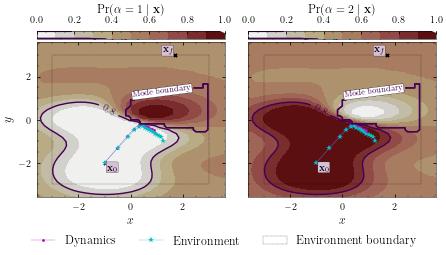

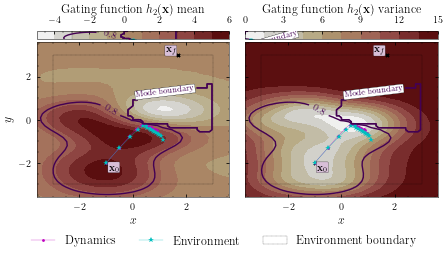

Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: -648.8739 - val_loss: -718.3890
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_11_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -862.4039

2022-04-08 18:24:51.169033: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 18:24:51.169050: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -862.4039 - val_loss: -887.2566
Epoch 3/10000
1/1 [==============================] - 0s 44ms/step - loss: -106.1982 - val_loss: -618.8465
Epoch 4/10000
1/1 [==============================] - ETA: 0s - loss: -452.6841

2022-04-08 18:24:53.004758: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 18:24:53.022336: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 18:24:53.031421: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_24_53

2022-04-08 18:24:53.040331: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_24_53/dr-robots-mbp.local.trace.json.gz
2022-04-08 18:24:53.066596: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_24_53

2022-04-08 18:24:53.06686

1/1 [==============================] - 0s 45ms/step - loss: -452.6841 - val_loss: -735.9770
Epoch 5/10000
1/1 [==============================] - 0s 44ms/step - loss: -843.6125 - val_loss: -767.8594
Epoch 6/10000
1/1 [==============================] - 0s 46ms/step - loss: -614.9945 - val_loss: -627.0467
Epoch 7/10000
1/1 [==============================] - 0s 45ms/step - loss: -288.3183 - val_loss: -483.5180
Epoch 8/10000
1/1 [==============================] - 0s 45ms/step - loss: -289.7970 - val_loss: -526.2901
Epoch 9/10000
1/1 [==============================] - 0s 45ms/step - loss: -438.5173 - val_loss: -786.7356
Epoch 10/10000
1/1 [==============================] - 0s 46ms/step - loss: -485.0652 - val_loss: -743.6223
Epoch 11/10000
1/1 [==============================] - 0s 44ms/step - loss: -489.8058 - val_loss: -564.5747
Epoch 12/10000
1/1 [==============================] - 0s 44ms/step - loss: -567.0404 - val_loss: -784.9771
Epoch 13/10000
1/1 [==============================] - 0s 

Epoch 81/10000
1/1 [==============================] - 0s 49ms/step - loss: -843.9552 - val_loss: -877.5332
Epoch 82/10000
1/1 [==============================] - 0s 48ms/step - loss: -831.7375 - val_loss: -880.8356
Epoch 83/10000
1/1 [==============================] - 0s 47ms/step - loss: -846.0693 - val_loss: -871.2258
Epoch 84/10000
1/1 [==============================] - 0s 50ms/step - loss: -837.2079 - val_loss: -887.9378
Epoch 85/10000
1/1 [==============================] - 0s 48ms/step - loss: -849.3595 - val_loss: -893.2927
Epoch 86/10000
1/1 [==============================] - 0s 48ms/step - loss: -847.4047 - val_loss: -890.5608
Epoch 87/10000
1/1 [==============================] - 0s 48ms/step - loss: -847.3349 - val_loss: -868.5662
Epoch 88/10000
1/1 [==============================] - 0s 48ms/step - loss: -833.8762 - val_loss: -857.2030
Epoch 89/10000
1/1 [==============================] - 0s 52ms/step - loss: -817.9655 - val_loss: -883.4227
Epoch 90/10000
1/1 [=================

1/1 [==============================] - 0s 47ms/step - loss: -883.9909 - val_loss: -941.3824
Epoch 158/10000
1/1 [==============================] - 0s 45ms/step - loss: -785.1502 - val_loss: -904.1117
Epoch 159/10000
1/1 [==============================] - 0s 45ms/step - loss: -820.3742 - val_loss: -924.1712
Epoch 160/10000
1/1 [==============================] - 0s 47ms/step - loss: -920.9920 - val_loss: -973.0575
Epoch 161/10000
1/1 [==============================] - 0s 62ms/step - loss: -847.6130 - val_loss: -947.4866
Epoch 162/10000
1/1 [==============================] - 0s 49ms/step - loss: -817.2884 - val_loss: -916.7403
Epoch 163/10000
1/1 [==============================] - 0s 46ms/step - loss: -858.8240 - val_loss: -970.7129
Epoch 164/10000
1/1 [==============================] - 0s 45ms/step - loss: -889.2250 - val_loss: -932.7678
Epoch 165/10000
1/1 [==============================] - 0s 46ms/step - loss: -915.0388 - val_loss: -968.5804
Epoch 166/10000
1/1 [=======================

1/1 [==============================] - 0s 51ms/step - loss: -380.6564 - val_loss: -383.6837
Epoch 234/10000
1/1 [==============================] - 0s 48ms/step - loss: -715.2138 - val_loss: -757.9702
Epoch 235/10000
1/1 [==============================] - 0s 47ms/step - loss: -525.1801 - val_loss: -620.9143
Epoch 236/10000
1/1 [==============================] - 0s 47ms/step - loss: -677.7445 - val_loss: -753.3963
Epoch 237/10000
1/1 [==============================] - 0s 47ms/step - loss: -790.9229 - val_loss: -848.9830
Epoch 238/10000
1/1 [==============================] - 0s 49ms/step - loss: -798.6361 - val_loss: -852.5030
Epoch 239/10000
1/1 [==============================] - 0s 48ms/step - loss: -777.1400 - val_loss: -841.8929
Epoch 240/10000
1/1 [==============================] - 0s 50ms/step - loss: -802.5722 - val_loss: -856.8500
Epoch 241/10000
1/1 [==============================] - 0s 49ms/step - loss: -771.4228 - val_loss: -815.0918
Epoch 242/10000
1/1 [=======================

1/1 [==============================] - 0s 48ms/step - loss: -853.6912 - val_loss: -955.1378
Epoch 310/10000
1/1 [==============================] - 0s 47ms/step - loss: -901.2802 - val_loss: -954.1624
Epoch 311/10000
1/1 [==============================] - 0s 45ms/step - loss: -896.5861 - val_loss: -949.0879
Epoch 312/10000
1/1 [==============================] - 0s 46ms/step - loss: -881.1159 - val_loss: -952.7651
Epoch 313/10000
1/1 [==============================] - 0s 47ms/step - loss: -832.5743 - val_loss: -874.7517
Epoch 314/10000
1/1 [==============================] - 0s 47ms/step - loss: -887.3373 - val_loss: -964.6718
Epoch 315/10000
1/1 [==============================] - 0s 48ms/step - loss: -897.2253 - val_loss: -959.2614
Epoch 316/10000
1/1 [==============================] - 0s 46ms/step - loss: -894.2164 - val_loss: -940.9101
Epoch 317/10000
1/1 [==============================] - 0s 46ms/step - loss: -880.4207 - val_loss: -945.3049
Epoch 318/10000
1/1 [=======================

1/1 [==============================] - 0s 56ms/step - loss: -435.8956 - val_loss: -628.4316
Epoch 386/10000
1/1 [==============================] - 0s 52ms/step - loss: 0.7660 - val_loss: 27.5805
Epoch 387/10000
1/1 [==============================] - 0s 52ms/step - loss: -493.7688 - val_loss: -487.9332
Epoch 388/10000
1/1 [==============================] - 0s 52ms/step - loss: -218.3231 - val_loss: -80.9172
Epoch 389/10000
1/1 [==============================] - 0s 57ms/step - loss: -248.6505 - val_loss: -326.9724
Epoch 390/10000
1/1 [==============================] - 0s 53ms/step - loss: -67.4792 - val_loss: -49.2706
Epoch 391/10000
1/1 [==============================] - 0s 54ms/step - loss: -168.7593 - val_loss: -229.2275
Epoch 392/10000
1/1 [==============================] - 0s 66ms/step - loss: -672.3234 - val_loss: -709.3977
Epoch 393/10000
1/1 [==============================] - 0s 58ms/step - loss: 491.2508 - val_loss: 455.9614
Epoch 394/10000
1/1 [==============================] -

1/1 [==============================] - 0s 53ms/step - loss: -763.9837 - val_loss: -867.8157
Epoch 538/10000
1/1 [==============================] - 0s 51ms/step - loss: -836.9863 - val_loss: -887.4702
Epoch 539/10000
1/1 [==============================] - 0s 52ms/step - loss: -856.4943 - val_loss: -904.3008
Epoch 540/10000
1/1 [==============================] - 0s 54ms/step - loss: -717.6630 - val_loss: -821.3581
Epoch 541/10000
1/1 [==============================] - 0s 53ms/step - loss: -828.3043 - val_loss: -886.9835
Epoch 542/10000
1/1 [==============================] - 0s 52ms/step - loss: -837.3198 - val_loss: -903.3268
Epoch 543/10000
1/1 [==============================] - 0s 51ms/step - loss: -861.2423 - val_loss: -924.3859
Epoch 544/10000
1/1 [==============================] - 0s 51ms/step - loss: -792.7190 - val_loss: -917.3332
Epoch 545/10000
1/1 [==============================] - 0s 52ms/step - loss: -834.2026 - val_loss: -886.9500
Epoch 546/10000
1/1 [=======================

1/1 [==============================] - 0s 55ms/step - loss: -699.7794 - val_loss: -844.1502
Epoch 614/10000
1/1 [==============================] - 0s 56ms/step - loss: -690.1284 - val_loss: -784.4342
Epoch 615/10000
1/1 [==============================] - 0s 68ms/step - loss: -838.9442 - val_loss: -900.2263
Epoch 616/10000
1/1 [==============================] - 0s 65ms/step - loss: -687.5653 - val_loss: -727.8123
Epoch 617/10000
1/1 [==============================] - 0s 65ms/step - loss: -816.0865 - val_loss: -870.2566
Epoch 618/10000
1/1 [==============================] - 0s 66ms/step - loss: -699.6109 - val_loss: -801.6782
Epoch 619/10000
1/1 [==============================] - 0s 60ms/step - loss: -768.6301 - val_loss: -821.5980
Epoch 620/10000
1/1 [==============================] - 0s 68ms/step - loss: -787.5975 - val_loss: -859.2369
Epoch 621/10000
1/1 [==============================] - 0s 55ms/step - loss: -754.2774 - val_loss: -868.9140
Epoch 622/10000
1/1 [=======================

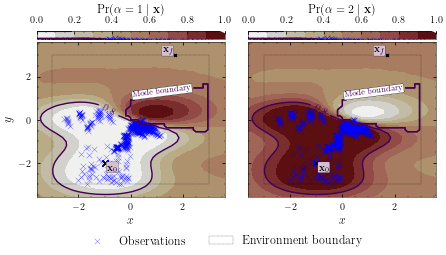

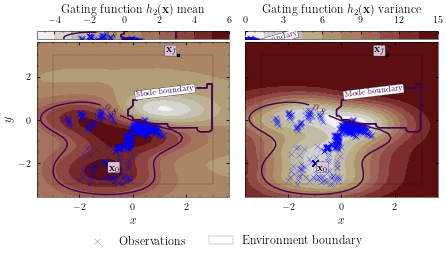

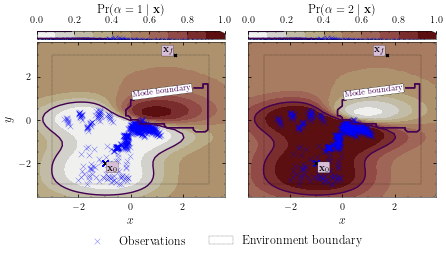

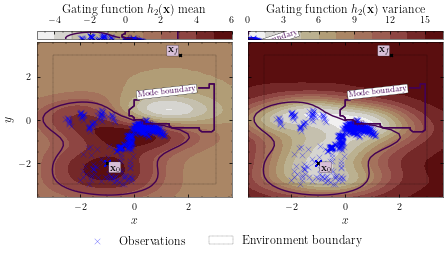

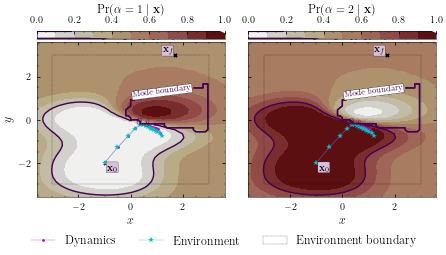

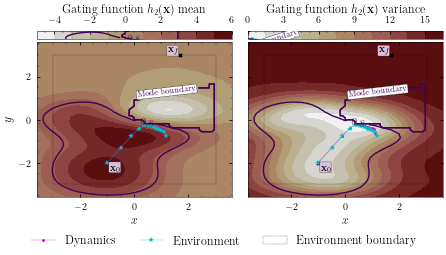

Epoch 1/10000
1/1 [==============================] - 1s 739ms/step - loss: -855.7975 - val_loss: -925.5755
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_12_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -812.8879

2022-04-08 18:27:17.767792: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 18:27:17.767806: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -812.8879 - val_loss: -899.8677
Epoch 3/10000
1/1 [==============================] - 0s 50ms/step - loss: -788.5304 - val_loss: -870.3628


2022-04-08 18:27:19.579271: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 18:27:19.593626: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 18:27:19.604817: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_27_19

2022-04-08 18:27:19.614882: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_27_19/dr-robots-mbp.local.trace.json.gz
2022-04-08 18:27:19.643072: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_27_19

2022-04-08 18:27:19.64347

Epoch 4/10000
1/1 [==============================] - 0s 55ms/step - loss: -843.9786 - val_loss: -907.7580
Epoch 5/10000
1/1 [==============================] - 0s 53ms/step - loss: -761.3178 - val_loss: -902.9460
Epoch 6/10000
1/1 [==============================] - 0s 55ms/step - loss: -847.8697 - val_loss: -890.4343
Epoch 7/10000
1/1 [==============================] - 0s 54ms/step - loss: -669.3619 - val_loss: -874.6381
Epoch 8/10000
1/1 [==============================] - 0s 58ms/step - loss: -722.1060 - val_loss: -817.3952
Epoch 9/10000
1/1 [==============================] - 0s 62ms/step - loss: -765.9058 - val_loss: -868.4926
Epoch 10/10000
1/1 [==============================] - 0s 54ms/step - loss: -820.4436 - val_loss: -835.0297
Epoch 11/10000
1/1 [==============================] - 0s 53ms/step - loss: -841.5285 - val_loss: -915.6101
Epoch 12/10000
1/1 [==============================] - 0s 55ms/step - loss: -261.0911 - val_loss: -771.5482
Epoch 13/10000
1/1 [=======================

1/1 [==============================] - 0s 59ms/step - loss: -843.5608 - val_loss: -925.2247
Epoch 157/10000
1/1 [==============================] - 0s 65ms/step - loss: -741.6567 - val_loss: -853.0048
Epoch 158/10000
1/1 [==============================] - 0s 61ms/step - loss: -846.6310 - val_loss: -902.5561
Epoch 159/10000
1/1 [==============================] - 0s 65ms/step - loss: -865.3994 - val_loss: -923.3778
Epoch 160/10000
1/1 [==============================] - 0s 60ms/step - loss: -877.9649 - val_loss: -930.4688
Epoch 161/10000
1/1 [==============================] - 0s 56ms/step - loss: -851.5084 - val_loss: -936.0194
Epoch 162/10000
1/1 [==============================] - 0s 58ms/step - loss: -862.7031 - val_loss: -928.8913
Epoch 163/10000
1/1 [==============================] - 0s 57ms/step - loss: -604.0664 - val_loss: -870.5844
Epoch 164/10000
1/1 [==============================] - 0s 58ms/step - loss: -823.0826 - val_loss: -883.6279
Epoch 165/10000
1/1 [=======================

1/1 [==============================] - 0s 62ms/step - loss: -719.2798 - val_loss: -764.5504
Epoch 233/10000
1/1 [==============================] - 0s 67ms/step - loss: -767.2780 - val_loss: -833.0465
Epoch 234/10000
1/1 [==============================] - 0s 60ms/step - loss: -752.9261 - val_loss: -830.9062
Epoch 235/10000
1/1 [==============================] - 0s 63ms/step - loss: -806.6471 - val_loss: -854.0494
Epoch 236/10000
1/1 [==============================] - 0s 63ms/step - loss: -797.5633 - val_loss: -835.4919
Epoch 237/10000
1/1 [==============================] - 0s 64ms/step - loss: -667.0951 - val_loss: -769.7507
Epoch 238/10000
1/1 [==============================] - 0s 76ms/step - loss: -642.0656 - val_loss: -765.1910
Epoch 239/10000
1/1 [==============================] - 0s 69ms/step - loss: -722.1410 - val_loss: -801.9583
Epoch 240/10000
1/1 [==============================] - 0s 65ms/step - loss: -785.7226 - val_loss: -834.6986
Epoch 241/10000
1/1 [=======================

1/1 [==============================] - 0s 64ms/step - loss: -890.2586 - val_loss: -932.5583
Epoch 309/10000
1/1 [==============================] - 0s 66ms/step - loss: -893.2274 - val_loss: -946.2520
Epoch 310/10000
1/1 [==============================] - 0s 60ms/step - loss: -865.9296 - val_loss: -932.7447
Epoch 311/10000
1/1 [==============================] - 0s 63ms/step - loss: -884.6351 - val_loss: -945.8511
Epoch 312/10000
1/1 [==============================] - 0s 74ms/step - loss: -888.1256 - val_loss: -953.9809
Epoch 313/10000
1/1 [==============================] - 0s 68ms/step - loss: -906.1684 - val_loss: -963.0562
Epoch 314/10000
1/1 [==============================] - 0s 67ms/step - loss: -864.1660 - val_loss: -936.6630
Epoch 315/10000
1/1 [==============================] - 0s 74ms/step - loss: -844.9964 - val_loss: -944.8427
Epoch 316/10000
1/1 [==============================] - 0s 64ms/step - loss: -872.0071 - val_loss: -959.9180
Epoch 317/10000
1/1 [=======================

1/1 [==============================] - 0s 62ms/step - loss: -526.6089 - val_loss: -728.9816
Epoch 385/10000
1/1 [==============================] - 0s 67ms/step - loss: -444.9420 - val_loss: -787.6298
Epoch 386/10000
1/1 [==============================] - 0s 64ms/step - loss: -97.5954 - val_loss: -638.2413
Epoch 387/10000
1/1 [==============================] - 0s 67ms/step - loss: -612.0044 - val_loss: -873.6681
Epoch 388/10000
1/1 [==============================] - 0s 66ms/step - loss: -316.9552 - val_loss: -678.5674
Epoch 389/10000
1/1 [==============================] - 0s 66ms/step - loss: -563.3394 - val_loss: -666.4125
Epoch 390/10000
1/1 [==============================] - 0s 64ms/step - loss: 512.7579 - val_loss: 591.1887
Epoch 391/10000
1/1 [==============================] - 0s 68ms/step - loss: -141.9261 - val_loss: -135.8052
Epoch 392/10000
1/1 [==============================] - 0s 63ms/step - loss: -721.6229 - val_loss: -778.1313
Epoch 393/10000
1/1 [==========================

1/1 [==============================] - 0s 63ms/step - loss: -805.9385 - val_loss: -856.0422
Epoch 537/10000
1/1 [==============================] - 0s 70ms/step - loss: -804.6031 - val_loss: -850.0107
Epoch 538/10000
1/1 [==============================] - 0s 65ms/step - loss: -790.9336 - val_loss: -872.7292
Epoch 539/10000
1/1 [==============================] - 0s 68ms/step - loss: -824.9563 - val_loss: -879.9179
Epoch 540/10000
1/1 [==============================] - 0s 63ms/step - loss: -814.8675 - val_loss: -865.0708
Epoch 541/10000
1/1 [==============================] - 0s 64ms/step - loss: -785.0546 - val_loss: -839.9821
Epoch 542/10000
1/1 [==============================] - 0s 65ms/step - loss: -790.7769 - val_loss: -866.0248
Epoch 543/10000
1/1 [==============================] - 0s 66ms/step - loss: -735.3510 - val_loss: -849.7709
Epoch 544/10000
1/1 [==============================] - 0s 68ms/step - loss: -764.0867 - val_loss: -856.7878
Epoch 545/10000
1/1 [=======================

Epoch 612/10000
1/1 [==============================] - 0s 75ms/step - loss: -730.0728 - val_loss: -887.9128
Epoch 613/10000
1/1 [==============================] - 0s 72ms/step - loss: -709.3566 - val_loss: -863.9527
Epoch 614/10000
1/1 [==============================] - 0s 72ms/step - loss: -760.9598 - val_loss: -799.5841
Epoch 615/10000
1/1 [==============================] - 0s 108ms/step - loss: -716.6959 - val_loss: -855.5856
Epoch 616/10000
1/1 [==============================] - 0s 81ms/step - loss: -689.9509 - val_loss: -789.2004
Epoch 617/10000
1/1 [==============================] - 0s 88ms/step - loss: -821.3633 - val_loss: -919.4101
Epoch 618/10000
1/1 [==============================] - 0s 77ms/step - loss: -840.8890 - val_loss: -890.4813
Epoch 619/10000
1/1 [==============================] - 0s 81ms/step - loss: -843.8775 - val_loss: -922.3752
Epoch 620/10000
1/1 [==============================] - 0s 77ms/step - loss: -850.1675 - val_loss: -922.4341
Epoch 621/10000
1/1 [======

Epoch 688/10000
1/1 [==============================] - 0s 82ms/step - loss: -827.0488 - val_loss: -901.3866
Epoch 689/10000
1/1 [==============================] - 0s 78ms/step - loss: -679.3497 - val_loss: -813.2581
Epoch 690/10000
1/1 [==============================] - 0s 81ms/step - loss: -769.1692 - val_loss: -906.0556
Epoch 691/10000
1/1 [==============================] - 0s 85ms/step - loss: -787.3457 - val_loss: -870.2216
Epoch 692/10000
1/1 [==============================] - 0s 80ms/step - loss: -813.5159 - val_loss: -907.8210
Epoch 693/10000
1/1 [==============================] - 0s 84ms/step - loss: -788.2052 - val_loss: -887.2281
Epoch 694/10000
1/1 [==============================] - 0s 77ms/step - loss: -740.2410 - val_loss: -825.6399
Epoch 695/10000
1/1 [==============================] - 0s 80ms/step - loss: -830.2911 - val_loss: -894.6317
Epoch 696/10000
1/1 [==============================] - 0s 79ms/step - loss: -837.1878 - val_loss: -913.5517
Epoch 697/10000
1/1 [=======

Epoch 764/10000
1/1 [==============================] - 0s 86ms/step - loss: -739.0279 - val_loss: -896.8552
Epoch 765/10000
1/1 [==============================] - 0s 82ms/step - loss: -856.4364 - val_loss: -929.2792
Epoch 766/10000
1/1 [==============================] - 0s 81ms/step - loss: -660.5770 - val_loss: -853.3370
Epoch 767/10000
1/1 [==============================] - 0s 84ms/step - loss: -720.8295 - val_loss: -906.4172
Epoch 768/10000
1/1 [==============================] - 0s 85ms/step - loss: -792.8323 - val_loss: -870.5726
Epoch 769/10000
1/1 [==============================] - 0s 83ms/step - loss: -685.9833 - val_loss: -762.0943
Epoch 770/10000
1/1 [==============================] - 0s 82ms/step - loss: -759.8436 - val_loss: -880.9683
Epoch 771/10000
1/1 [==============================] - 0s 79ms/step - loss: -824.1806 - val_loss: -911.2923
Epoch 772/10000
1/1 [==============================] - 0s 86ms/step - loss: -794.1208 - val_loss: -877.8270
Epoch 773/10000
1/1 [=======

Epoch 840/10000
1/1 [==============================] - 0s 88ms/step - loss: -831.2182 - val_loss: -936.9846
Epoch 841/10000
1/1 [==============================] - 0s 91ms/step - loss: -862.1942 - val_loss: -943.5368
Epoch 842/10000
1/1 [==============================] - 0s 95ms/step - loss: -837.6248 - val_loss: -879.4753
Epoch 843/10000
1/1 [==============================] - 0s 93ms/step - loss: -829.7152 - val_loss: -870.4550
Epoch 844/10000
1/1 [==============================] - 0s 89ms/step - loss: -793.2852 - val_loss: -927.8515
Epoch 845/10000
1/1 [==============================] - 0s 89ms/step - loss: -727.2221 - val_loss: -917.8022
Epoch 846/10000
1/1 [==============================] - 0s 88ms/step - loss: -623.9020 - val_loss: -781.5980
Epoch 847/10000
1/1 [==============================] - 0s 89ms/step - loss: -877.3066 - val_loss: -937.7564
Epoch 848/10000
1/1 [==============================] - 0s 101ms/step - loss: -712.1095 - val_loss: -901.1527
Epoch 849/10000
1/1 [======

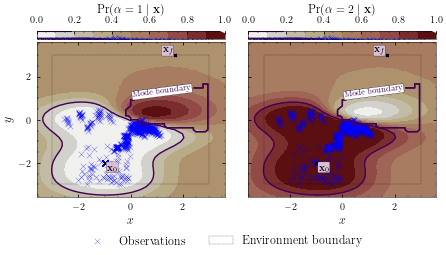

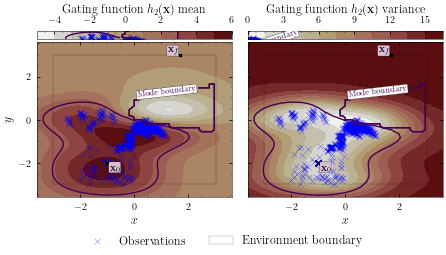

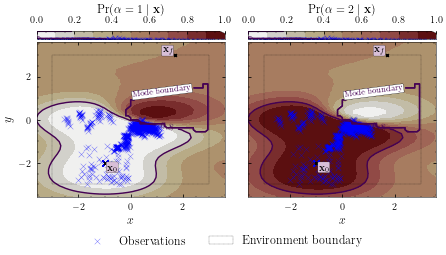

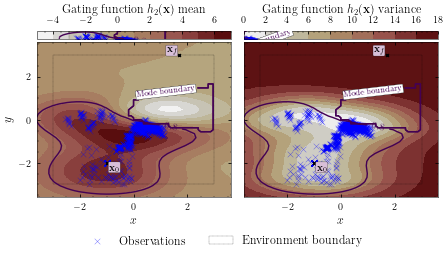

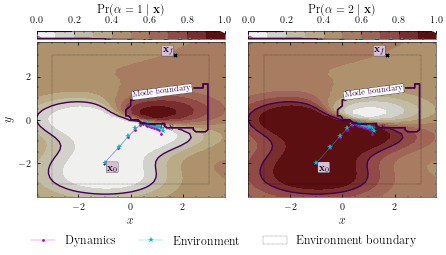

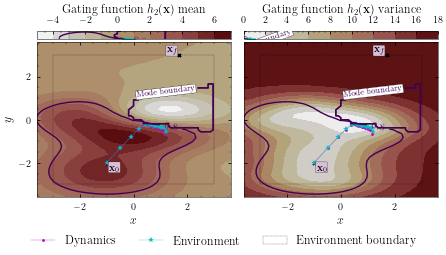

Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: -835.3614 - val_loss: -920.4320
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_13_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -817.6020

2022-04-08 18:30:05.410061: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 18:30:05.410077: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -817.6020 - val_loss: -874.6187
Epoch 3/10000
1/1 [==============================] - 0s 44ms/step - loss: -828.8008 - val_loss: -898.7948
Epoch 4/10000
1/1 [==============================] - ETA: 0s - loss: -758.5585

2022-04-08 18:30:07.131521: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 18:30:07.147579: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 18:30:07.159234: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_30_07

2022-04-08 18:30:07.169334: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_30_07/dr-robots-mbp.local.trace.json.gz
2022-04-08 18:30:07.199074: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_30_07

2022-04-08 18:30:07.19933

1/1 [==============================] - 0s 43ms/step - loss: -758.5585 - val_loss: -841.1819
Epoch 5/10000
1/1 [==============================] - 0s 43ms/step - loss: -830.5409 - val_loss: -860.5458
Epoch 6/10000
1/1 [==============================] - 0s 45ms/step - loss: -819.9757 - val_loss: -887.8875
Epoch 7/10000
1/1 [==============================] - 0s 46ms/step - loss: -827.4647 - val_loss: -908.2447
Epoch 8/10000
1/1 [==============================] - 0s 45ms/step - loss: -574.8251 - val_loss: -779.3169
Epoch 9/10000
1/1 [==============================] - 0s 43ms/step - loss: -835.4484 - val_loss: -919.0749
Epoch 10/10000
1/1 [==============================] - 0s 44ms/step - loss: -785.7525 - val_loss: -902.0739
Epoch 11/10000
1/1 [==============================] - 0s 46ms/step - loss: -894.9376 - val_loss: -925.0005
Epoch 12/10000
1/1 [==============================] - 0s 46ms/step - loss: -817.9078 - val_loss: -881.3622
Epoch 13/10000
1/1 [==============================] - 0s 

Epoch 81/10000
1/1 [==============================] - 0s 47ms/step - loss: -880.8194 - val_loss: -912.7503
Epoch 82/10000
1/1 [==============================] - 0s 48ms/step - loss: -734.2618 - val_loss: -851.1234
Epoch 83/10000
1/1 [==============================] - 0s 48ms/step - loss: -825.2062 - val_loss: -892.1259
Epoch 84/10000
1/1 [==============================] - 0s 48ms/step - loss: -856.5117 - val_loss: -918.0539
Epoch 85/10000
1/1 [==============================] - 0s 48ms/step - loss: -799.8353 - val_loss: -865.7535
Epoch 86/10000
1/1 [==============================] - 0s 45ms/step - loss: -852.8904 - val_loss: -916.7194
Epoch 87/10000
1/1 [==============================] - 0s 47ms/step - loss: -826.7747 - val_loss: -907.6572
Epoch 88/10000
1/1 [==============================] - 0s 47ms/step - loss: -868.9372 - val_loss: -928.0768
Epoch 89/10000
1/1 [==============================] - 0s 47ms/step - loss: -883.3134 - val_loss: -928.3597
Epoch 90/10000
1/1 [=================

1/1 [==============================] - 0s 52ms/step - loss: -751.3005 - val_loss: -891.8071
Epoch 158/10000
1/1 [==============================] - 0s 52ms/step - loss: -892.2070 - val_loss: -942.0599
Epoch 159/10000
1/1 [==============================] - 0s 50ms/step - loss: -776.7213 - val_loss: -962.5849
Epoch 160/10000
1/1 [==============================] - 0s 53ms/step - loss: -904.4286 - val_loss: -904.0924
Epoch 161/10000
1/1 [==============================] - 0s 56ms/step - loss: -804.8760 - val_loss: -886.8991
Epoch 162/10000
1/1 [==============================] - 0s 51ms/step - loss: -867.9465 - val_loss: -956.4865
Epoch 163/10000
1/1 [==============================] - 0s 52ms/step - loss: -545.1155 - val_loss: -848.0023
Epoch 164/10000
1/1 [==============================] - 0s 51ms/step - loss: -802.8464 - val_loss: -963.0750
Epoch 165/10000
1/1 [==============================] - 0s 51ms/step - loss: -904.4501 - val_loss: -924.9813
Epoch 166/10000
1/1 [=======================

1/1 [==============================] - 0s 50ms/step - loss: -845.1092 - val_loss: -873.2305
Epoch 234/10000
1/1 [==============================] - 0s 50ms/step - loss: -787.7579 - val_loss: -830.1464
Epoch 235/10000
1/1 [==============================] - 0s 51ms/step - loss: -787.7131 - val_loss: -835.3331
Epoch 236/10000
1/1 [==============================] - 0s 51ms/step - loss: -740.0785 - val_loss: -837.0885
Epoch 237/10000
1/1 [==============================] - 0s 49ms/step - loss: -805.9764 - val_loss: -876.4157
Epoch 238/10000
1/1 [==============================] - 0s 49ms/step - loss: -856.1151 - val_loss: -887.7584
Epoch 239/10000
1/1 [==============================] - 0s 48ms/step - loss: -790.0951 - val_loss: -872.3285
Epoch 240/10000
1/1 [==============================] - 0s 48ms/step - loss: -813.3874 - val_loss: -882.3858
Epoch 241/10000
1/1 [==============================] - 0s 65ms/step - loss: -859.4391 - val_loss: -896.8490
Epoch 242/10000
1/1 [=======================

1/1 [==============================] - 0s 50ms/step - loss: -911.2581 - val_loss: -944.8829
Epoch 310/10000
1/1 [==============================] - 0s 51ms/step - loss: -866.6784 - val_loss: -916.8871
Epoch 311/10000
1/1 [==============================] - 0s 51ms/step - loss: -889.6456 - val_loss: -927.6265
Epoch 312/10000
1/1 [==============================] - 0s 49ms/step - loss: -883.3911 - val_loss: -941.3883
Epoch 313/10000
1/1 [==============================] - 0s 50ms/step - loss: -876.8102 - val_loss: -917.7179
Epoch 314/10000
1/1 [==============================] - 0s 49ms/step - loss: -907.9042 - val_loss: -951.1628
Epoch 315/10000
1/1 [==============================] - 0s 51ms/step - loss: -881.9102 - val_loss: -925.4909
Epoch 316/10000
1/1 [==============================] - 0s 51ms/step - loss: -876.4245 - val_loss: -918.9733
Epoch 317/10000
1/1 [==============================] - 0s 51ms/step - loss: -908.9506 - val_loss: -940.6734
Epoch 318/10000
1/1 [=======================

1/1 [==============================] - 0s 50ms/step - loss: -839.7518 - val_loss: -846.7048
Epoch 386/10000
1/1 [==============================] - 0s 49ms/step - loss: -833.2682 - val_loss: -877.0778
Epoch 387/10000
1/1 [==============================] - 0s 52ms/step - loss: -876.6004 - val_loss: -905.7971
Epoch 388/10000
1/1 [==============================] - 0s 49ms/step - loss: -841.8291 - val_loss: -882.9486
Epoch 389/10000
1/1 [==============================] - 0s 50ms/step - loss: -842.9530 - val_loss: -914.8599
Epoch 390/10000
1/1 [==============================] - 0s 51ms/step - loss: -842.5213 - val_loss: -912.0637
Epoch 391/10000
1/1 [==============================] - 0s 51ms/step - loss: -835.4471 - val_loss: -936.0439
Epoch 392/10000
1/1 [==============================] - 0s 50ms/step - loss: -864.3894 - val_loss: -912.1775
Epoch 393/10000
1/1 [==============================] - 0s 50ms/step - loss: -861.5411 - val_loss: -931.4200
Epoch 394/10000
1/1 [=======================

1/1 [==============================] - 0s 51ms/step - loss: -838.5662 - val_loss: -943.6040
Epoch 462/10000
1/1 [==============================] - 0s 50ms/step - loss: -897.2349 - val_loss: -930.9944
Epoch 463/10000
1/1 [==============================] - 0s 51ms/step - loss: -806.6520 - val_loss: -925.7200
Epoch 464/10000
1/1 [==============================] - 0s 51ms/step - loss: -843.2940 - val_loss: -911.3438
Epoch 465/10000
1/1 [==============================] - 0s 51ms/step - loss: -845.6086 - val_loss: -930.6788
Epoch 466/10000
1/1 [==============================] - 0s 51ms/step - loss: -704.4140 - val_loss: -922.0122
Epoch 467/10000
1/1 [==============================] - 0s 50ms/step - loss: -812.8556 - val_loss: -946.5801
Epoch 468/10000
1/1 [==============================] - 0s 51ms/step - loss: -797.6730 - val_loss: -827.1251
Epoch 469/10000
1/1 [==============================] - 0s 50ms/step - loss: -406.4143 - val_loss: -921.4155
Epoch 470/10000
1/1 [=======================

1/1 [==============================] - 0s 84ms/step - loss: -841.0079 - val_loss: -885.2639
Epoch 538/10000
1/1 [==============================] - 0s 59ms/step - loss: -851.1330 - val_loss: -895.9582
Epoch 539/10000
1/1 [==============================] - 0s 57ms/step - loss: -848.9865 - val_loss: -901.6684
Epoch 540/10000
1/1 [==============================] - 0s 53ms/step - loss: -849.2448 - val_loss: -881.1406
Epoch 541/10000
1/1 [==============================] - 0s 53ms/step - loss: -842.1716 - val_loss: -889.4687
Epoch 542/10000
1/1 [==============================] - 0s 51ms/step - loss: -818.9125 - val_loss: -875.7409
Epoch 543/10000
1/1 [==============================] - 0s 55ms/step - loss: -754.3590 - val_loss: -864.2247
Epoch 544/10000
1/1 [==============================] - 0s 53ms/step - loss: -870.5667 - val_loss: -906.3098
Epoch 545/10000
1/1 [==============================] - 0s 54ms/step - loss: -870.2075 - val_loss: -902.5908
Epoch 546/10000
1/1 [=======================

1/1 [==============================] - 0s 51ms/step - loss: -414.9310 - val_loss: -494.4034
Epoch 614/10000
1/1 [==============================] - 0s 50ms/step - loss: -433.8882 - val_loss: -695.7514
Epoch 615/10000
1/1 [==============================] - 0s 52ms/step - loss: -519.7597 - val_loss: -878.5731
Epoch 616/10000
1/1 [==============================] - 0s 52ms/step - loss: -802.6320 - val_loss: -786.3253
Epoch 617/10000
1/1 [==============================] - 0s 53ms/step - loss: -751.6218 - val_loss: -768.7192
Epoch 618/10000
1/1 [==============================] - 0s 52ms/step - loss: -712.6024 - val_loss: -762.0632
Epoch 619/10000
1/1 [==============================] - 0s 54ms/step - loss: -503.8884 - val_loss: -506.1435
Epoch 620/10000
1/1 [==============================] - 0s 52ms/step - loss: -725.9586 - val_loss: -858.5480
Epoch 621/10000
1/1 [==============================] - 0s 53ms/step - loss: -821.3102 - val_loss: -880.4124
Epoch 622/10000
1/1 [=======================

1/1 [==============================] - 0s 57ms/step - loss: -823.1389 - val_loss: -902.2245
Epoch 690/10000
1/1 [==============================] - 0s 57ms/step - loss: -878.3563 - val_loss: -924.8591
Epoch 691/10000
1/1 [==============================] - 0s 57ms/step - loss: -891.7339 - val_loss: -917.0834
Epoch 692/10000
1/1 [==============================] - 0s 59ms/step - loss: -867.1617 - val_loss: -929.9441
Epoch 693/10000
1/1 [==============================] - 0s 57ms/step - loss: -898.2527 - val_loss: -932.6478
Epoch 694/10000
1/1 [==============================] - 0s 57ms/step - loss: -790.8509 - val_loss: -879.5888
Epoch 695/10000
1/1 [==============================] - 0s 55ms/step - loss: -836.9976 - val_loss: -895.1006
Epoch 696/10000
1/1 [==============================] - 0s 57ms/step - loss: -842.6053 - val_loss: -880.7942
Epoch 697/10000
1/1 [==============================] - 0s 57ms/step - loss: -828.8665 - val_loss: -913.5477
Epoch 698/10000
1/1 [=======================

1/1 [==============================] - 0s 56ms/step - loss: -809.5958 - val_loss: -880.4484
Epoch 766/10000
1/1 [==============================] - 0s 56ms/step - loss: -869.2122 - val_loss: -900.1114
Epoch 767/10000
1/1 [==============================] - 0s 54ms/step - loss: -928.9432 - val_loss: -970.3301
Epoch 768/10000
1/1 [==============================] - 0s 56ms/step - loss: -914.0286 - val_loss: -969.9342
Epoch 769/10000
1/1 [==============================] - 0s 57ms/step - loss: -895.8791 - val_loss: -945.8140
Epoch 770/10000
1/1 [==============================] - 0s 59ms/step - loss: -935.5791 - val_loss: -979.3063
Epoch 771/10000
1/1 [==============================] - 0s 52ms/step - loss: -877.7278 - val_loss: -963.3942
Epoch 772/10000
1/1 [==============================] - 0s 56ms/step - loss: -825.4394 - val_loss: -946.0885
Epoch 773/10000
1/1 [==============================] - 0s 56ms/step - loss: -883.0115 - val_loss: -978.4729
Epoch 774/10000
1/1 [=======================

1/1 [==============================] - 0s 54ms/step - loss: -818.5794 - val_loss: -906.6504
Epoch 842/10000
1/1 [==============================] - 0s 53ms/step - loss: -840.5055 - val_loss: -896.4505
Epoch 843/10000
1/1 [==============================] - 0s 55ms/step - loss: -848.1821 - val_loss: -889.8972
Epoch 844/10000
1/1 [==============================] - 0s 53ms/step - loss: -799.1816 - val_loss: -904.2576
Epoch 845/10000
1/1 [==============================] - 0s 54ms/step - loss: -898.0706 - val_loss: -919.3118
Epoch 846/10000
1/1 [==============================] - 0s 54ms/step - loss: -804.3060 - val_loss: -861.7990
Epoch 847/10000
1/1 [==============================] - 0s 52ms/step - loss: -763.2905 - val_loss: -848.2958
Epoch 848/10000
1/1 [==============================] - 0s 54ms/step - loss: -831.5064 - val_loss: -856.9807
Epoch 849/10000
1/1 [==============================] - 0s 54ms/step - loss: -889.7125 - val_loss: -923.7283
Epoch 850/10000
1/1 [=======================

1/1 [==============================] - 0s 64ms/step - loss: -840.2127 - val_loss: -895.4029
Epoch 918/10000
1/1 [==============================] - 0s 72ms/step - loss: -821.2987 - val_loss: -893.2589
Epoch 919/10000
1/1 [==============================] - 0s 74ms/step - loss: -634.8738 - val_loss: -730.8050
Epoch 920/10000
1/1 [==============================] - 0s 66ms/step - loss: -787.9584 - val_loss: -870.9195
Epoch 921/10000
1/1 [==============================] - 0s 67ms/step - loss: -880.1226 - val_loss: -908.7581
Epoch 922/10000
1/1 [==============================] - 0s 64ms/step - loss: -813.4537 - val_loss: -875.1020
Epoch 923/10000
1/1 [==============================] - 0s 72ms/step - loss: -242.0018 - val_loss: -739.5054
Epoch 924/10000
1/1 [==============================] - 0s 71ms/step - loss: -796.6329 - val_loss: -871.8374
Epoch 925/10000
1/1 [==============================] - 0s 73ms/step - loss: -885.5970 - val_loss: -913.1345
Epoch 926/10000
1/1 [=======================

1/1 [==============================] - 0s 70ms/step - loss: -767.2627 - val_loss: -811.9643
Epoch 994/10000
1/1 [==============================] - 0s 65ms/step - loss: -807.9802 - val_loss: -924.5580
Epoch 995/10000
1/1 [==============================] - 0s 63ms/step - loss: -891.0391 - val_loss: -914.7027
Epoch 996/10000
1/1 [==============================] - 0s 64ms/step - loss: -910.9115 - val_loss: -945.3547
Epoch 997/10000
1/1 [==============================] - 0s 62ms/step - loss: -902.1161 - val_loss: -956.9535
Epoch 998/10000
1/1 [==============================] - 0s 70ms/step - loss: -670.1352 - val_loss: -763.4314
Epoch 999/10000
1/1 [==============================] - 0s 61ms/step - loss: -821.6593 - val_loss: -918.7244
Epoch 1000/10000
1/1 [==============================] - 0s 61ms/step - loss: -271.9180 - val_loss: -832.0668
Epoch 1001/10000
1/1 [==============================] - 0s 64ms/step - loss: -705.5605 - val_loss: -828.1567
Epoch 1002/10000
1/1 [====================

1/1 [==============================] - 0s 83ms/step - loss: -887.5825 - val_loss: -922.5067
Epoch 1144/10000
1/1 [==============================] - 0s 74ms/step - loss: -890.6131 - val_loss: -941.9113
Epoch 1145/10000
1/1 [==============================] - 0s 89ms/step - loss: -879.9750 - val_loss: -948.2161
Epoch 1146/10000
1/1 [==============================] - 0s 140ms/step - loss: -893.3630 - val_loss: -928.5524
Epoch 1147/10000
1/1 [==============================] - 0s 90ms/step - loss: -908.2606 - val_loss: -947.3233
Epoch 1148/10000
1/1 [==============================] - 0s 88ms/step - loss: -907.3425 - val_loss: -944.5382
Epoch 1149/10000
1/1 [==============================] - 0s 95ms/step - loss: -889.7231 - val_loss: -944.4947
Epoch 1150/10000
1/1 [==============================] - 0s 82ms/step - loss: -912.2259 - val_loss: -951.3821
Epoch 1151/10000
1/1 [==============================] - 0s 77ms/step - loss: -887.6159 - val_loss: -928.4515
Epoch 1152/10000
1/1 [=============

Epoch 1218/10000
1/1 [==============================] - 0s 95ms/step - loss: -800.7155 - val_loss: -798.1414
Epoch 1219/10000
1/1 [==============================] - 0s 99ms/step - loss: -718.1738 - val_loss: -885.6337
Epoch 1220/10000
1/1 [==============================] - 0s 97ms/step - loss: -269.5863 - val_loss: -608.3646
Epoch 1221/10000
1/1 [==============================] - 0s 98ms/step - loss: -683.7707 - val_loss: -805.1796
Epoch 1222/10000
1/1 [==============================] - 0s 91ms/step - loss: -576.1953 - val_loss: -857.9221
Epoch 1223/10000
1/1 [==============================] - 0s 92ms/step - loss: -810.5130 - val_loss: -821.7122
Epoch 1224/10000
1/1 [==============================] - 0s 106ms/step - loss: -857.4156 - val_loss: -870.8647
Epoch 1225/10000
1/1 [==============================] - 0s 90ms/step - loss: -789.7730 - val_loss: -885.3927
Epoch 1226/10000
1/1 [==============================] - 0s 99ms/step - loss: -649.2163 - val_loss: -695.2306
Epoch 1227/10000
1

1/1 [==============================] - 0s 124ms/step - loss: -838.3504 - val_loss: -912.5139
Epoch 1367/10000
1/1 [==============================] - 0s 120ms/step - loss: -851.6958 - val_loss: -939.2645
Epoch 1368/10000
1/1 [==============================] - 0s 132ms/step - loss: -863.2437 - val_loss: -938.5064
Epoch 1369/10000
1/1 [==============================] - 0s 125ms/step - loss: -875.2438 - val_loss: -931.8442
Epoch 1370/10000
1/1 [==============================] - 0s 124ms/step - loss: -893.5746 - val_loss: -944.2730
Epoch 1371/10000
1/1 [==============================] - 0s 120ms/step - loss: -855.6527 - val_loss: -892.4478
Epoch 1372/10000
1/1 [==============================] - 0s 122ms/step - loss: -901.2184 - val_loss: -949.6411
Epoch 1373/10000
1/1 [==============================] - 0s 123ms/step - loss: -863.2900 - val_loss: -922.1762
Epoch 1374/10000
1/1 [==============================] - 0s 129ms/step - loss: -786.7589 - val_loss: -907.5062
Epoch 1375/10000
1/1 [=====

1/1 [==============================] - 0s 113ms/step - loss: -848.7269 - val_loss: -878.2904
Epoch 1515/10000
1/1 [==============================] - 0s 108ms/step - loss: -819.7505 - val_loss: -855.7144
Epoch 1516/10000
1/1 [==============================] - 0s 108ms/step - loss: -818.6750 - val_loss: -849.0292
Epoch 1517/10000
1/1 [==============================] - 0s 107ms/step - loss: -848.7926 - val_loss: -882.3461
Epoch 1518/10000
1/1 [==============================] - 0s 102ms/step - loss: -828.9243 - val_loss: -865.9069
Epoch 1519/10000
1/1 [==============================] - 0s 103ms/step - loss: -837.8384 - val_loss: -865.3578
Epoch 1520/10000
1/1 [==============================] - 0s 101ms/step - loss: -855.1816 - val_loss: -890.4837
Epoch 1521/10000
1/1 [==============================] - 0s 104ms/step - loss: -818.8171 - val_loss: -855.1718
Epoch 1522/10000
1/1 [==============================] - 0s 98ms/step - loss: -790.1896 - val_loss: -867.6853
Epoch 1523/10000
1/1 [======

1/1 [==============================] - 0s 82ms/step - loss: -877.1969 - val_loss: -959.3171
Epoch 1664/10000
1/1 [==============================] - 0s 84ms/step - loss: -913.9605 - val_loss: -946.4597
Epoch 1665/10000
1/1 [==============================] - 0s 92ms/step - loss: -906.9596 - val_loss: -971.7821
Epoch 1666/10000
1/1 [==============================] - 0s 89ms/step - loss: -877.4317 - val_loss: -923.9261
Epoch 1667/10000
1/1 [==============================] - 0s 83ms/step - loss: -649.5433 - val_loss: -941.8632
Epoch 1668/10000
1/1 [==============================] - 0s 88ms/step - loss: -868.8987 - val_loss: -955.4159
Epoch 1669/10000
1/1 [==============================] - 0s 81ms/step - loss: -906.3045 - val_loss: -970.7881
Epoch 1670/10000
1/1 [==============================] - 0s 90ms/step - loss: -632.9732 - val_loss: -946.5032
Epoch 1671/10000
1/1 [==============================] - 0s 88ms/step - loss: -905.2602 - val_loss: -950.5654
Epoch 1672/10000
1/1 [==============

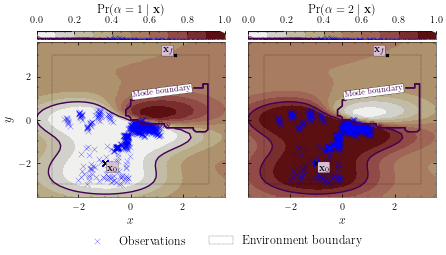

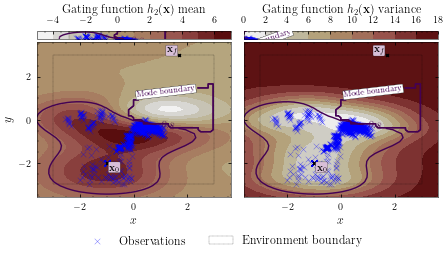

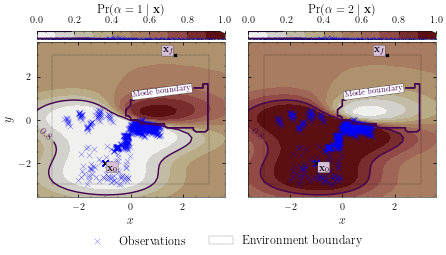

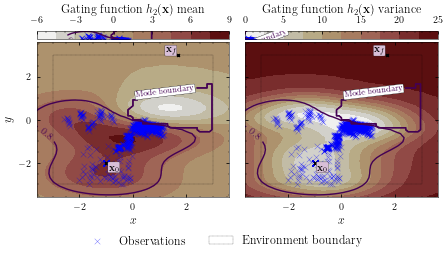

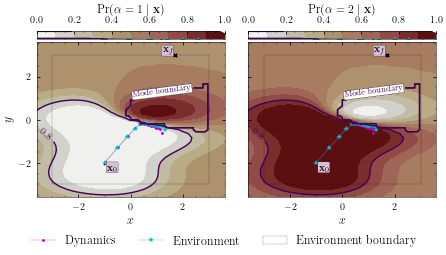

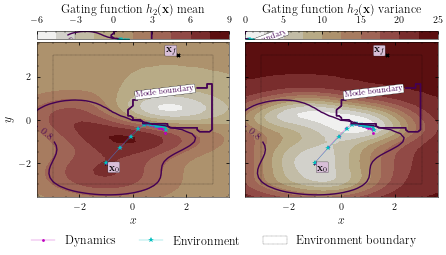

Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: -844.7464 - val_loss: -909.0680
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_14_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -800.1462

2022-04-08 18:34:07.747849: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 18:34:07.747865: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -800.1462 - val_loss: -942.7971
Epoch 3/10000
1/1 [==============================] - 0s 48ms/step - loss: -882.1318 - val_loss: -895.6094


2022-04-08 18:34:09.541190: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 18:34:09.559913: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 18:34:09.572477: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_34_09

2022-04-08 18:34:09.583658: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_34_09/dr-robots-mbp.local.trace.json.gz
2022-04-08 18:34:09.617641: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_34_09

2022-04-08 18:34:09.61790

Epoch 4/10000
1/1 [==============================] - 0s 51ms/step - loss: -402.6783 - val_loss: -912.8384
Epoch 5/10000
1/1 [==============================] - 0s 49ms/step - loss: -777.3642 - val_loss: -908.7298
Epoch 6/10000
1/1 [==============================] - 0s 48ms/step - loss: -884.1904 - val_loss: -941.8613
Epoch 7/10000
1/1 [==============================] - 0s 46ms/step - loss: -760.2047 - val_loss: -951.1707
Epoch 8/10000
1/1 [==============================] - 0s 47ms/step - loss: -628.7646 - val_loss: -927.0618
Epoch 9/10000
1/1 [==============================] - 0s 45ms/step - loss: -836.1406 - val_loss: -945.5464
Epoch 10/10000
1/1 [==============================] - 0s 48ms/step - loss: -868.8608 - val_loss: -873.4092
Epoch 11/10000
1/1 [==============================] - 0s 47ms/step - loss: -852.9303 - val_loss: -905.6684
Epoch 12/10000
1/1 [==============================] - 0s 48ms/step - loss: -675.6747 - val_loss: -891.9386
Epoch 13/10000
1/1 [=======================

1/1 [==============================] - 0s 56ms/step - loss: -817.1756 - val_loss: -868.6552
Epoch 157/10000
1/1 [==============================] - 0s 56ms/step - loss: -610.2254 - val_loss: -786.1376
Epoch 158/10000
1/1 [==============================] - 0s 54ms/step - loss: -766.8573 - val_loss: -778.8596
Epoch 159/10000
1/1 [==============================] - 0s 55ms/step - loss: -801.3712 - val_loss: -814.7921
Epoch 160/10000
1/1 [==============================] - 0s 55ms/step - loss: -770.4067 - val_loss: -859.9737
Epoch 161/10000
1/1 [==============================] - 0s 57ms/step - loss: -733.9274 - val_loss: -748.7625
Epoch 162/10000
1/1 [==============================] - 0s 59ms/step - loss: -709.2765 - val_loss: -775.3480
Epoch 163/10000
1/1 [==============================] - 0s 57ms/step - loss: -667.4941 - val_loss: -754.2546
Epoch 164/10000
1/1 [==============================] - 0s 56ms/step - loss: -743.8548 - val_loss: -857.3888
Epoch 165/10000
1/1 [=======================

1/1 [==============================] - 0s 53ms/step - loss: -847.4676 - val_loss: -889.2293
Epoch 233/10000
1/1 [==============================] - 0s 53ms/step - loss: -880.3984 - val_loss: -909.6616
Epoch 234/10000
1/1 [==============================] - 0s 54ms/step - loss: -893.1120 - val_loss: -928.3236
Epoch 235/10000
1/1 [==============================] - 0s 51ms/step - loss: -844.1108 - val_loss: -924.2703
Epoch 236/10000
1/1 [==============================] - 0s 54ms/step - loss: -907.0972 - val_loss: -932.7384
Epoch 237/10000
1/1 [==============================] - 0s 52ms/step - loss: -841.2512 - val_loss: -890.6585
Epoch 238/10000
1/1 [==============================] - 0s 53ms/step - loss: -887.6330 - val_loss: -917.7621
Epoch 239/10000
1/1 [==============================] - 0s 53ms/step - loss: -875.2240 - val_loss: -927.0403
Epoch 240/10000
1/1 [==============================] - 0s 53ms/step - loss: -852.7941 - val_loss: -914.0739
Epoch 241/10000
1/1 [=======================

1/1 [==============================] - 0s 54ms/step - loss: -291.7909 - val_loss: -499.6646
Epoch 309/10000
1/1 [==============================] - 0s 58ms/step - loss: -724.8875 - val_loss: -839.2023
Epoch 310/10000
1/1 [==============================] - 0s 54ms/step - loss: -788.7556 - val_loss: -874.1518
Epoch 311/10000
1/1 [==============================] - 0s 53ms/step - loss: -850.2173 - val_loss: -856.5584
Epoch 312/10000
1/1 [==============================] - 0s 54ms/step - loss: -715.1836 - val_loss: -820.1294
Epoch 313/10000
1/1 [==============================] - 0s 58ms/step - loss: -827.2529 - val_loss: -806.9557
Epoch 314/10000
1/1 [==============================] - 0s 56ms/step - loss: -742.1773 - val_loss: -767.2431
Epoch 315/10000
1/1 [==============================] - 0s 52ms/step - loss: -725.6852 - val_loss: -782.1093
Epoch 316/10000
1/1 [==============================] - 0s 54ms/step - loss: -580.8183 - val_loss: -720.8880
Epoch 317/10000
1/1 [=======================

1/1 [==============================] - 0s 60ms/step - loss: -902.0964 - val_loss: -937.0601
Epoch 385/10000
1/1 [==============================] - 0s 59ms/step - loss: -890.8901 - val_loss: -881.6598
Epoch 386/10000
1/1 [==============================] - 0s 56ms/step - loss: -894.9285 - val_loss: -919.2370
Epoch 387/10000
1/1 [==============================] - 0s 55ms/step - loss: -823.6352 - val_loss: -887.9298
Epoch 388/10000
1/1 [==============================] - 0s 56ms/step - loss: -878.0868 - val_loss: -918.6378
Epoch 389/10000
1/1 [==============================] - 0s 56ms/step - loss: -867.0877 - val_loss: -924.2116
Epoch 390/10000
1/1 [==============================] - 0s 55ms/step - loss: -897.1479 - val_loss: -914.0628
Epoch 391/10000
1/1 [==============================] - 0s 56ms/step - loss: -883.6751 - val_loss: -914.1342
Epoch 392/10000
1/1 [==============================] - 0s 56ms/step - loss: -843.8176 - val_loss: -916.3328
Epoch 393/10000
1/1 [=======================

1/1 [==============================] - 0s 57ms/step - loss: -494.4003 - val_loss: -653.1886
Epoch 461/10000
1/1 [==============================] - 0s 55ms/step - loss: -842.1718 - val_loss: -926.3364
Epoch 462/10000
1/1 [==============================] - 0s 55ms/step - loss: -502.9883 - val_loss: -736.0427
Epoch 463/10000
1/1 [==============================] - 0s 55ms/step - loss: -760.1148 - val_loss: -856.0640
Epoch 464/10000
1/1 [==============================] - 0s 57ms/step - loss: -787.3738 - val_loss: -875.7499
Epoch 465/10000
1/1 [==============================] - 0s 54ms/step - loss: -772.9074 - val_loss: -786.2155
Epoch 466/10000
1/1 [==============================] - 0s 55ms/step - loss: -886.6530 - val_loss: -908.5388
Epoch 467/10000
1/1 [==============================] - 0s 55ms/step - loss: -774.0146 - val_loss: -800.2357
Epoch 468/10000
1/1 [==============================] - 0s 55ms/step - loss: -834.1948 - val_loss: -863.8175
Epoch 469/10000
1/1 [=======================

1/1 [==============================] - 0s 102ms/step - loss: -861.3508 - val_loss: -872.0334
Epoch 537/10000
1/1 [==============================] - 0s 56ms/step - loss: -813.7805 - val_loss: -847.4934
Epoch 538/10000
1/1 [==============================] - 0s 57ms/step - loss: -819.0320 - val_loss: -854.4834
Epoch 539/10000
1/1 [==============================] - 0s 54ms/step - loss: -857.3806 - val_loss: -877.7196
Epoch 540/10000
1/1 [==============================] - 0s 57ms/step - loss: -791.5782 - val_loss: -844.7335
Epoch 541/10000
1/1 [==============================] - 0s 59ms/step - loss: -860.1218 - val_loss: -881.2014
Epoch 542/10000
1/1 [==============================] - 0s 56ms/step - loss: -801.8811 - val_loss: -859.0865
Epoch 543/10000
1/1 [==============================] - 0s 59ms/step - loss: -845.6002 - val_loss: -876.5471
Epoch 544/10000
1/1 [==============================] - 0s 56ms/step - loss: -817.1575 - val_loss: -870.6383
Epoch 545/10000
1/1 [======================

Epoch 612/10000
1/1 [==============================] - 0s 69ms/step - loss: -762.9837 - val_loss: -834.6881
Epoch 613/10000
1/1 [==============================] - 0s 65ms/step - loss: -891.3681 - val_loss: -928.9925
Epoch 614/10000
1/1 [==============================] - 0s 70ms/step - loss: -901.4042 - val_loss: -934.8719
Epoch 615/10000
1/1 [==============================] - 0s 66ms/step - loss: -911.1391 - val_loss: -947.1849
Epoch 616/10000
1/1 [==============================] - 0s 68ms/step - loss: -783.3083 - val_loss: -942.4341
Epoch 617/10000
1/1 [==============================] - 0s 69ms/step - loss: -882.0965 - val_loss: -931.9136
Epoch 618/10000
1/1 [==============================] - 0s 65ms/step - loss: -907.6592 - val_loss: -931.0482
Epoch 619/10000
1/1 [==============================] - 0s 71ms/step - loss: -907.9375 - val_loss: -926.6342
Epoch 620/10000
1/1 [==============================] - 0s 71ms/step - loss: -908.4875 - val_loss: -920.4720
Epoch 621/10000
1/1 [=======

Epoch 688/10000
1/1 [==============================] - 0s 84ms/step - loss: -789.3216 - val_loss: -810.2890
Epoch 689/10000
1/1 [==============================] - 0s 75ms/step - loss: -848.8888 - val_loss: -909.4083
Epoch 690/10000
1/1 [==============================] - 0s 82ms/step - loss: -439.1247 - val_loss: -843.2887
Epoch 691/10000
1/1 [==============================] - 0s 86ms/step - loss: -892.6459 - val_loss: -926.8760
Epoch 692/10000
1/1 [==============================] - 0s 80ms/step - loss: -887.2089 - val_loss: -928.2463
Epoch 693/10000
1/1 [==============================] - 0s 80ms/step - loss: -876.4243 - val_loss: -913.3805
Epoch 694/10000
1/1 [==============================] - 0s 77ms/step - loss: -872.1207 - val_loss: -927.3247
Epoch 695/10000
1/1 [==============================] - 0s 76ms/step - loss: -768.5647 - val_loss: -875.5613
Epoch 696/10000
1/1 [==============================] - 0s 79ms/step - loss: -803.3463 - val_loss: -862.2083
Epoch 697/10000
1/1 [=======

Epoch 764/10000
1/1 [==============================] - 0s 87ms/step - loss: -765.7600 - val_loss: -852.8666
Epoch 765/10000
1/1 [==============================] - 0s 92ms/step - loss: -821.1037 - val_loss: -859.1969
Epoch 766/10000
1/1 [==============================] - 0s 95ms/step - loss: -768.4317 - val_loss: -879.1682
Epoch 767/10000
1/1 [==============================] - 0s 90ms/step - loss: -870.2024 - val_loss: -886.4615
Epoch 768/10000
1/1 [==============================] - 0s 87ms/step - loss: -680.9314 - val_loss: -792.0741
Epoch 769/10000
1/1 [==============================] - 0s 97ms/step - loss: -816.6731 - val_loss: -861.7587
Epoch 770/10000
1/1 [==============================] - 0s 91ms/step - loss: -818.4093 - val_loss: -866.0088
Epoch 771/10000
1/1 [==============================] - 0s 110ms/step - loss: -829.3482 - val_loss: -867.3408
Epoch 772/10000
1/1 [==============================] - 0s 81ms/step - loss: -745.9837 - val_loss: -877.1517
Epoch 773/10000
1/1 [======

Epoch 840/10000
1/1 [==============================] - 0s 86ms/step - loss: -863.4896 - val_loss: -953.7740
Epoch 841/10000
1/1 [==============================] - 0s 72ms/step - loss: -891.5683 - val_loss: -953.8554
Epoch 842/10000
1/1 [==============================] - 0s 100ms/step - loss: -913.4666 - val_loss: -968.1557
Epoch 843/10000
1/1 [==============================] - 0s 91ms/step - loss: -931.8960 - val_loss: -957.3590
Epoch 844/10000
1/1 [==============================] - 0s 91ms/step - loss: -913.0595 - val_loss: -932.4204
Epoch 845/10000
1/1 [==============================] - 0s 88ms/step - loss: -834.2238 - val_loss: -945.5756
Epoch 846/10000
1/1 [==============================] - 0s 81ms/step - loss: -903.0814 - val_loss: -951.0732
Epoch 847/10000
1/1 [==============================] - 0s 83ms/step - loss: -939.0752 - val_loss: -971.9503
Epoch 848/10000
1/1 [==============================] - 0s 82ms/step - loss: -908.3864 - val_loss: -977.6475
Epoch 849/10000
1/1 [======

Epoch 916/10000
1/1 [==============================] - 0s 82ms/step - loss: -750.6595 - val_loss: -837.9936
Epoch 917/10000
1/1 [==============================] - 0s 87ms/step - loss: -742.0777 - val_loss: -790.9245
Epoch 918/10000
1/1 [==============================] - 0s 81ms/step - loss: -767.6701 - val_loss: -837.1177
Epoch 919/10000
1/1 [==============================] - 0s 111ms/step - loss: -819.8267 - val_loss: -864.0186
Epoch 920/10000
1/1 [==============================] - 0s 94ms/step - loss: -806.0122 - val_loss: -862.0526
Epoch 921/10000
1/1 [==============================] - 0s 106ms/step - loss: -732.7073 - val_loss: -812.6744
Epoch 922/10000
1/1 [==============================] - 0s 88ms/step - loss: -792.0766 - val_loss: -863.2200
Epoch 923/10000
1/1 [==============================] - 0s 84ms/step - loss: -797.4244 - val_loss: -850.6617
Epoch 924/10000
1/1 [==============================] - 0s 80ms/step - loss: -812.9362 - val_loss: -865.1148
Epoch 925/10000
1/1 [=====

1/1 [==============================] - 0s 97ms/step - loss: -846.8773 - val_loss: -901.8422
Epoch 1067/10000
1/1 [==============================] - 0s 90ms/step - loss: -881.3962 - val_loss: -924.0879
Epoch 1068/10000
1/1 [==============================] - 0s 88ms/step - loss: -850.2553 - val_loss: -916.8377
Epoch 1069/10000
1/1 [==============================] - 0s 85ms/step - loss: -880.6984 - val_loss: -876.9242
Epoch 1070/10000
1/1 [==============================] - 0s 86ms/step - loss: -689.6825 - val_loss: -816.9978
Epoch 1071/10000
1/1 [==============================] - 0s 95ms/step - loss: -876.1155 - val_loss: -926.0863
Epoch 1072/10000
1/1 [==============================] - 0s 94ms/step - loss: -899.4149 - val_loss: -932.1852
Epoch 1073/10000
1/1 [==============================] - 0s 92ms/step - loss: -902.4179 - val_loss: -947.8141
Epoch 1074/10000
1/1 [==============================] - 0s 88ms/step - loss: -800.6656 - val_loss: -923.7602
Epoch 1075/10000
1/1 [==============

1/1 [==============================] - 0s 90ms/step - loss: -864.2924 - val_loss: -941.8619
Epoch 1142/10000
1/1 [==============================] - 0s 93ms/step - loss: -899.1426 - val_loss: -977.2902
Epoch 1143/10000
1/1 [==============================] - 0s 98ms/step - loss: -949.4139 - val_loss: -979.7426
Epoch 1144/10000
1/1 [==============================] - 0s 102ms/step - loss: -785.0183 - val_loss: -816.7039
Epoch 1145/10000
1/1 [==============================] - 0s 88ms/step - loss: -913.6071 - val_loss: -949.3789
Epoch 1146/10000
1/1 [==============================] - 0s 91ms/step - loss: -869.6575 - val_loss: -947.9941
Epoch 1147/10000
1/1 [==============================] - 0s 98ms/step - loss: -871.3824 - val_loss: -942.3897
Epoch 1148/10000
1/1 [==============================] - 0s 93ms/step - loss: -925.8204 - val_loss: -974.1894
Epoch 1149/10000
1/1 [==============================] - 0s 89ms/step - loss: -936.7041 - val_loss: -939.1807
Epoch 1150/10000
1/1 [=============

1/1 [==============================] - 0s 81ms/step - loss: -685.7589 - val_loss: -659.3476
Epoch 1292/10000
1/1 [==============================] - 0s 83ms/step - loss: -763.2283 - val_loss: -836.9973
Epoch 1293/10000
1/1 [==============================] - 0s 80ms/step - loss: -674.1349 - val_loss: -777.7198
Epoch 1294/10000
1/1 [==============================] - 0s 77ms/step - loss: -686.1685 - val_loss: -757.0468
Epoch 1295/10000
1/1 [==============================] - 0s 81ms/step - loss: -547.1576 - val_loss: -752.6085
Epoch 1296/10000
1/1 [==============================] - 0s 79ms/step - loss: -352.3049 - val_loss: -635.0689
Epoch 1297/10000
1/1 [==============================] - 0s 81ms/step - loss: -681.9735 - val_loss: -777.4336
Epoch 1298/10000
1/1 [==============================] - 0s 80ms/step - loss: -662.2011 - val_loss: -814.7932
Epoch 1299/10000
1/1 [==============================] - 0s 76ms/step - loss: -593.3098 - val_loss: -779.7522
Epoch 1300/10000
1/1 [==============

1/1 [==============================] - 0s 66ms/step - loss: -844.6964 - val_loss: -881.2834
Epoch 1442/10000
1/1 [==============================] - 0s 67ms/step - loss: -871.4018 - val_loss: -931.6152
Epoch 1443/10000
1/1 [==============================] - 0s 64ms/step - loss: -835.5775 - val_loss: -917.1812
Epoch 1444/10000
1/1 [==============================] - 0s 64ms/step - loss: -876.0907 - val_loss: -949.8988
Epoch 1445/10000
1/1 [==============================] - 0s 67ms/step - loss: -870.7817 - val_loss: -917.6234
Epoch 1446/10000
1/1 [==============================] - 0s 65ms/step - loss: -909.0789 - val_loss: -958.6656
Epoch 1447/10000
1/1 [==============================] - 0s 66ms/step - loss: -715.7170 - val_loss: -762.8720
Epoch 1448/10000
1/1 [==============================] - 0s 67ms/step - loss: -683.2613 - val_loss: -714.5532
Epoch 1449/10000
1/1 [==============================] - 0s 69ms/step - loss: -777.6032 - val_loss: -840.3015
Epoch 1450/10000
1/1 [==============

1/1 [==============================] - 0s 58ms/step - loss: -829.1172 - val_loss: -912.0107
Epoch 1592/10000
1/1 [==============================] - 0s 55ms/step - loss: -654.7695 - val_loss: -856.8119
Epoch 1593/10000
1/1 [==============================] - 0s 58ms/step - loss: -641.1102 - val_loss: -646.3349
Epoch 1594/10000
1/1 [==============================] - 0s 60ms/step - loss: -789.7866 - val_loss: -775.1545
Epoch 1595/10000
1/1 [==============================] - 0s 58ms/step - loss: -712.4766 - val_loss: -758.5920
Epoch 1596/10000
1/1 [==============================] - 0s 57ms/step - loss: -535.3298 - val_loss: -659.6805
Epoch 1597/10000
1/1 [==============================] - 0s 61ms/step - loss: -720.1498 - val_loss: -795.9415
Epoch 1598/10000
1/1 [==============================] - 0s 60ms/step - loss: -874.1645 - val_loss: -919.1631
Epoch 1599/10000
1/1 [==============================] - 0s 59ms/step - loss: -653.9182 - val_loss: -850.9137
Epoch 1600/10000
1/1 [==============

(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
Data set size: (1025, 4)


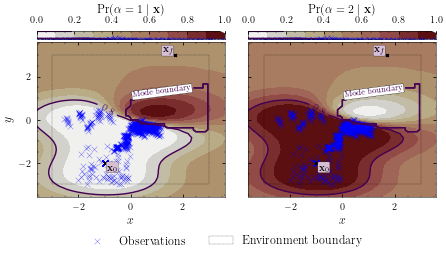

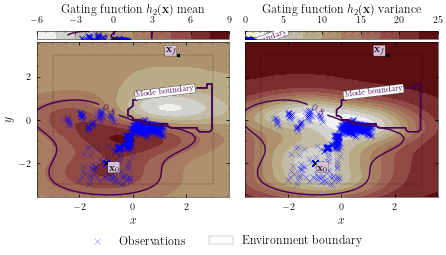

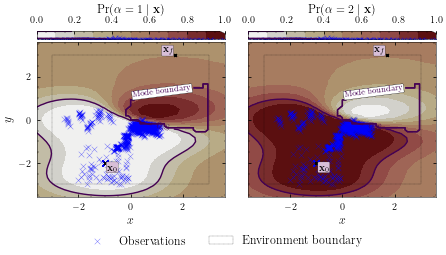

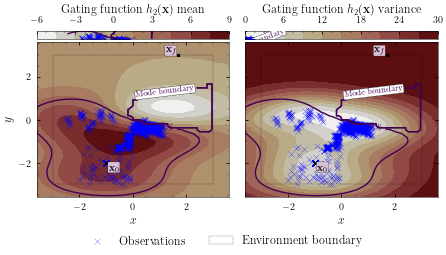

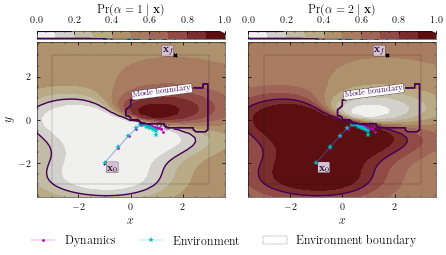

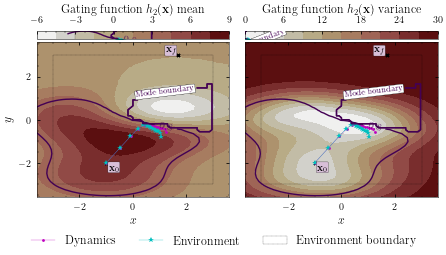

Epoch 1/10000
1/1 [==============================] - 1s 900ms/step - loss: -783.2886 - val_loss: -825.9669
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_15_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -741.5913

2022-04-08 18:38:11.610536: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 18:38:11.610556: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -741.5913 - val_loss: -771.0213


2022-04-08 18:38:13.815094: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 18:38:13.842741: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 18:38:13.856473: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_38_13

2022-04-08 18:38:13.867194: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_38_13/dr-robots-mbp.local.trace.json.gz
2022-04-08 18:38:13.931579: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_38_13

2022-04-08 18:38:13.93189

Epoch 3/10000
1/1 [==============================] - 0s 76ms/step - loss: -779.7867 - val_loss: -807.7497
Epoch 4/10000
1/1 [==============================] - 0s 70ms/step - loss: -810.2141 - val_loss: -863.0590
Epoch 5/10000
1/1 [==============================] - 0s 66ms/step - loss: -647.0389 - val_loss: -687.6304
Epoch 6/10000
1/1 [==============================] - 0s 74ms/step - loss: -874.3507 - val_loss: -897.2228
Epoch 7/10000
1/1 [==============================] - 0s 70ms/step - loss: -802.5454 - val_loss: -818.8744
Epoch 8/10000
1/1 [==============================] - 0s 70ms/step - loss: -818.0673 - val_loss: -901.5683
Epoch 9/10000
1/1 [==============================] - 0s 67ms/step - loss: -867.4123 - val_loss: -917.1918
Epoch 10/10000
1/1 [==============================] - 0s 68ms/step - loss: -863.9115 - val_loss: -887.7275
Epoch 11/10000
1/1 [==============================] - 0s 68ms/step - loss: -889.3624 - val_loss: -929.8457
Epoch 12/10000
1/1 [========================

1/1 [==============================] - 0s 74ms/step - loss: -850.4633 - val_loss: -896.5007
Epoch 156/10000
1/1 [==============================] - 0s 76ms/step - loss: -861.7400 - val_loss: -894.0414
Epoch 157/10000
1/1 [==============================] - 0s 81ms/step - loss: -845.6533 - val_loss: -876.5237
Epoch 158/10000
1/1 [==============================] - 0s 86ms/step - loss: -823.2163 - val_loss: -851.4398
Epoch 159/10000
1/1 [==============================] - 0s 96ms/step - loss: -860.6882 - val_loss: -891.9848
Epoch 160/10000
1/1 [==============================] - 0s 102ms/step - loss: -710.9730 - val_loss: -804.6245
Epoch 161/10000
1/1 [==============================] - 0s 102ms/step - loss: -824.8135 - val_loss: -890.9185
Epoch 162/10000
1/1 [==============================] - 0s 92ms/step - loss: -849.0647 - val_loss: -891.4828
Epoch 163/10000
1/1 [==============================] - 0s 81ms/step - loss: -877.4469 - val_loss: -905.7853
Epoch 164/10000
1/1 [=====================

Epoch 231/10000
1/1 [==============================] - 0s 77ms/step - loss: -476.1552 - val_loss: -604.5612
Epoch 232/10000
1/1 [==============================] - 0s 80ms/step - loss: -930.2522 - val_loss: -958.2481
Epoch 233/10000
1/1 [==============================] - 0s 87ms/step - loss: -805.2773 - val_loss: -919.8138
Epoch 234/10000
1/1 [==============================] - 0s 82ms/step - loss: -814.6074 - val_loss: -919.8417
Epoch 235/10000
1/1 [==============================] - 0s 84ms/step - loss: -779.1655 - val_loss: -883.5867
Epoch 236/10000
1/1 [==============================] - 0s 84ms/step - loss: -798.9627 - val_loss: -915.4751
Epoch 237/10000
1/1 [==============================] - 0s 96ms/step - loss: -593.4695 - val_loss: -782.8090
Epoch 238/10000
1/1 [==============================] - 0s 92ms/step - loss: -562.8820 - val_loss: -895.2884
Epoch 239/10000
1/1 [==============================] - 0s 91ms/step - loss: -856.5835 - val_loss: -849.3410
Epoch 240/10000
1/1 [=======

Epoch 307/10000
1/1 [==============================] - 0s 89ms/step - loss: -901.8430 - val_loss: -934.3412
Epoch 308/10000
1/1 [==============================] - 0s 83ms/step - loss: -860.2835 - val_loss: -924.8082
Epoch 309/10000
1/1 [==============================] - 0s 86ms/step - loss: -807.6893 - val_loss: -913.3967
Epoch 310/10000
1/1 [==============================] - 0s 96ms/step - loss: -893.1399 - val_loss: -930.0084
Epoch 311/10000
1/1 [==============================] - 0s 85ms/step - loss: -891.0446 - val_loss: -918.6414
Epoch 312/10000
1/1 [==============================] - 0s 85ms/step - loss: -909.1274 - val_loss: -938.3912
Epoch 313/10000
1/1 [==============================] - 0s 88ms/step - loss: -843.3165 - val_loss: -904.3878
Epoch 314/10000
1/1 [==============================] - 0s 100ms/step - loss: -873.2166 - val_loss: -929.6010
Epoch 315/10000
1/1 [==============================] - 0s 99ms/step - loss: -905.3293 - val_loss: -942.6079
Epoch 316/10000
1/1 [======

Epoch 458/10000
1/1 [==============================] - 0s 99ms/step - loss: -742.8792 - val_loss: -804.8144
Epoch 459/10000
1/1 [==============================] - 0s 94ms/step - loss: -653.5851 - val_loss: -804.2817
Epoch 460/10000
1/1 [==============================] - 0s 96ms/step - loss: -712.0149 - val_loss: -800.9961
Epoch 461/10000
1/1 [==============================] - 0s 96ms/step - loss: -547.1396 - val_loss: -661.1117
Epoch 462/10000
1/1 [==============================] - 0s 94ms/step - loss: -775.1503 - val_loss: -818.8040
Epoch 463/10000
1/1 [==============================] - 0s 103ms/step - loss: -672.0984 - val_loss: -782.0862
Epoch 464/10000
1/1 [==============================] - 0s 121ms/step - loss: -708.9349 - val_loss: -798.9931
Epoch 465/10000
1/1 [==============================] - 0s 103ms/step - loss: -685.8591 - val_loss: -787.8383
Epoch 466/10000
1/1 [==============================] - 0s 107ms/step - loss: -798.9824 - val_loss: -840.2864
Epoch 467/10000
1/1 [===

Epoch 609/10000
1/1 [==============================] - 0s 92ms/step - loss: -876.6599 - val_loss: -919.5035
Epoch 610/10000
1/1 [==============================] - 0s 84ms/step - loss: -771.1446 - val_loss: -864.4655
Epoch 611/10000
1/1 [==============================] - 0s 89ms/step - loss: -693.2647 - val_loss: -875.2046
Epoch 612/10000
1/1 [==============================] - 0s 90ms/step - loss: -837.9583 - val_loss: -900.5140
Epoch 613/10000
1/1 [==============================] - 0s 87ms/step - loss: -600.0963 - val_loss: -825.2470
Epoch 614/10000
1/1 [==============================] - 0s 90ms/step - loss: -577.9781 - val_loss: -557.1344
Epoch 615/10000
1/1 [==============================] - 0s 92ms/step - loss: -623.0803 - val_loss: -723.2888
Epoch 616/10000
1/1 [==============================] - 0s 98ms/step - loss: -532.3148 - val_loss: -849.5281
Epoch 617/10000
1/1 [==============================] - 0s 92ms/step - loss: -600.8705 - val_loss: -782.5063
Epoch 618/10000
1/1 [=======

Epoch 685/10000
1/1 [==============================] - 0s 77ms/step - loss: -403.2585 - val_loss: -734.1472
Epoch 686/10000
1/1 [==============================] - 0s 79ms/step - loss: -692.0311 - val_loss: -836.7238
Epoch 687/10000
1/1 [==============================] - 0s 78ms/step - loss: -683.0919 - val_loss: -759.7331
Epoch 688/10000
1/1 [==============================] - 0s 80ms/step - loss: -772.8214 - val_loss: -816.3092
Epoch 689/10000
1/1 [==============================] - 0s 78ms/step - loss: -756.5285 - val_loss: -821.3228
Epoch 690/10000
1/1 [==============================] - 0s 77ms/step - loss: -415.0962 - val_loss: -584.6773
Epoch 691/10000
1/1 [==============================] - 0s 118ms/step - loss: -378.5971 - val_loss: -468.7284
Epoch 692/10000
1/1 [==============================] - 0s 88ms/step - loss: -668.3482 - val_loss: -767.1299
Epoch 693/10000
1/1 [==============================] - 0s 79ms/step - loss: -772.4560 - val_loss: -810.4933
Epoch 694/10000
1/1 [======

Epoch 761/10000
1/1 [==============================] - 0s 75ms/step - loss: -762.9985 - val_loss: -836.7906
Epoch 762/10000
1/1 [==============================] - 0s 73ms/step - loss: -838.7422 - val_loss: -875.9968
Epoch 763/10000
1/1 [==============================] - 0s 68ms/step - loss: -789.7454 - val_loss: -880.8621
Epoch 764/10000
1/1 [==============================] - 0s 69ms/step - loss: -844.6784 - val_loss: -892.3909
Epoch 765/10000
1/1 [==============================] - 0s 69ms/step - loss: -722.0595 - val_loss: -874.6499
Epoch 766/10000
1/1 [==============================] - 0s 71ms/step - loss: -836.9680 - val_loss: -887.4593
Epoch 767/10000
1/1 [==============================] - 0s 71ms/step - loss: -663.1814 - val_loss: -870.9692
Epoch 768/10000
1/1 [==============================] - 0s 73ms/step - loss: -837.2175 - val_loss: -885.7043
Epoch 769/10000
1/1 [==============================] - 0s 72ms/step - loss: -824.7933 - val_loss: -900.8746
Epoch 770/10000
1/1 [=======

Epoch 837/10000
1/1 [==============================] - 0s 71ms/step - loss: -822.0365 - val_loss: -880.3396
Epoch 838/10000
1/1 [==============================] - 0s 80ms/step - loss: -775.2426 - val_loss: -751.5351
Epoch 839/10000
1/1 [==============================] - 0s 73ms/step - loss: -587.9608 - val_loss: -652.8648
Epoch 840/10000
1/1 [==============================] - 0s 67ms/step - loss: -526.5148 - val_loss: -660.1076
Epoch 841/10000
1/1 [==============================] - 0s 72ms/step - loss: -739.7763 - val_loss: -788.6741
Epoch 842/10000
1/1 [==============================] - 0s 72ms/step - loss: -787.0977 - val_loss: -862.6958
Epoch 843/10000
1/1 [==============================] - 0s 69ms/step - loss: -758.4213 - val_loss: -797.9253
Epoch 844/10000
1/1 [==============================] - 0s 66ms/step - loss: -369.6757 - val_loss: -363.4620
Epoch 845/10000
1/1 [==============================] - 0s 87ms/step - loss: -186.0859 - val_loss: -532.5960
Epoch 846/10000
1/1 [=======

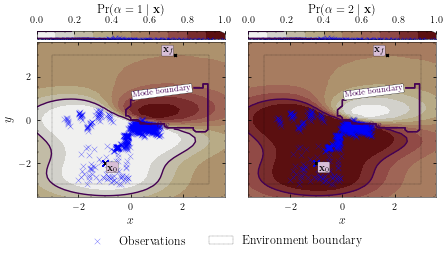

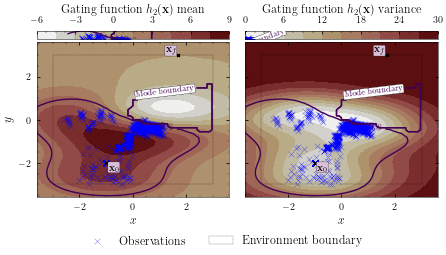

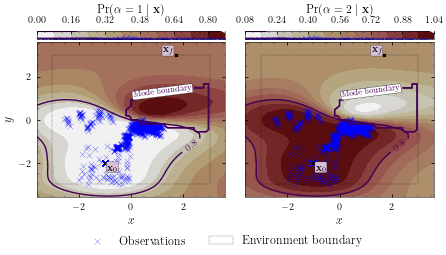

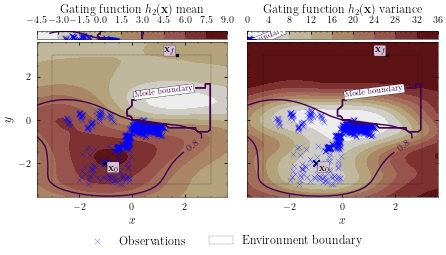

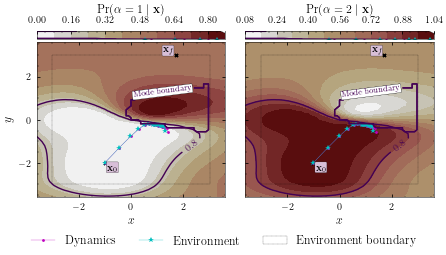

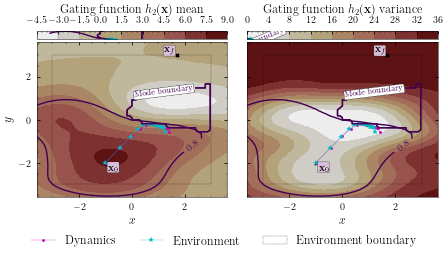

Epoch 1/10000
1/1 [==============================] - 1s 765ms/step - loss: -747.7620 - val_loss: -827.8612
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_16_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -681.6599

2022-04-08 18:41:30.786803: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 18:41:30.786822: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -681.6599 - val_loss: -797.8746
Epoch 3/10000
1/1 [==============================] - 0s 54ms/step - loss: -662.1121 - val_loss: -740.1288
Epoch 4/10000
1/1 [==============================] - ETA: 0s - loss: -747.4717

2022-04-08 18:41:32.745108: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 18:41:32.759189: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 18:41:32.769144: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_41_32

2022-04-08 18:41:32.778496: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_41_32/dr-robots-mbp.local.trace.json.gz
2022-04-08 18:41:32.806537: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_41_32

2022-04-08 18:41:32.80678

1/1 [==============================] - 0s 52ms/step - loss: -747.4717 - val_loss: -856.9023
Epoch 5/10000
1/1 [==============================] - 0s 51ms/step - loss: -466.2247 - val_loss: -745.0677
Epoch 6/10000
1/1 [==============================] - 0s 52ms/step - loss: -615.8775 - val_loss: -774.0864
Epoch 7/10000
1/1 [==============================] - 0s 53ms/step - loss: -564.8075 - val_loss: -705.9296
Epoch 8/10000
1/1 [==============================] - 0s 54ms/step - loss: -749.9227 - val_loss: -803.9234
Epoch 9/10000
1/1 [==============================] - 0s 52ms/step - loss: 78.4966 - val_loss: 65.6036
Epoch 10/10000
1/1 [==============================] - 0s 52ms/step - loss: -364.8611 - val_loss: -224.2603
Epoch 11/10000
1/1 [==============================] - 0s 52ms/step - loss: -595.3555 - val_loss: -619.0690
Epoch 12/10000
1/1 [==============================] - 0s 109ms/step - loss: 548.3739 - val_loss: 663.5723
Epoch 13/10000
1/1 [==============================] - 0s 55ms/

Epoch 81/10000
1/1 [==============================] - 0s 53ms/step - loss: -806.2614 - val_loss: -844.8214
Epoch 82/10000
1/1 [==============================] - 0s 55ms/step - loss: -750.9767 - val_loss: -830.2526
Epoch 83/10000
1/1 [==============================] - 0s 53ms/step - loss: -811.7050 - val_loss: -850.2081
Epoch 84/10000
1/1 [==============================] - 0s 55ms/step - loss: -766.2485 - val_loss: -821.2530
Epoch 85/10000
1/1 [==============================] - 0s 55ms/step - loss: -806.2915 - val_loss: -856.8596
Epoch 86/10000
1/1 [==============================] - 0s 54ms/step - loss: -806.0282 - val_loss: -851.0163
Epoch 87/10000
1/1 [==============================] - 0s 55ms/step - loss: -783.3968 - val_loss: -846.8260
Epoch 88/10000
1/1 [==============================] - 0s 55ms/step - loss: -787.1091 - val_loss: -828.8748
Epoch 89/10000
1/1 [==============================] - 0s 56ms/step - loss: -802.6103 - val_loss: -848.9118
Epoch 90/10000
1/1 [=================

1/1 [==============================] - 0s 58ms/step - loss: -884.0769 - val_loss: -927.6071
Epoch 158/10000
1/1 [==============================] - 0s 58ms/step - loss: -763.4946 - val_loss: -812.9231
Epoch 159/10000
1/1 [==============================] - 0s 112ms/step - loss: -843.4716 - val_loss: -935.0489
Epoch 160/10000
1/1 [==============================] - 0s 64ms/step - loss: -825.2679 - val_loss: -921.5372
Epoch 161/10000
1/1 [==============================] - 0s 58ms/step - loss: -586.4283 - val_loss: -858.3045
Epoch 162/10000
1/1 [==============================] - 0s 58ms/step - loss: -885.3945 - val_loss: -939.7075
Epoch 163/10000
1/1 [==============================] - 0s 59ms/step - loss: -845.5719 - val_loss: -830.2320
Epoch 164/10000
1/1 [==============================] - 0s 58ms/step - loss: -837.1466 - val_loss: -908.0024
Epoch 165/10000
1/1 [==============================] - 0s 57ms/step - loss: -858.2224 - val_loss: -875.6206
Epoch 166/10000
1/1 [======================

1/1 [==============================] - 0s 56ms/step - loss: -769.3808 - val_loss: -811.8733
Epoch 234/10000
1/1 [==============================] - 0s 55ms/step - loss: -764.0550 - val_loss: -801.9105
Epoch 235/10000
1/1 [==============================] - 0s 56ms/step - loss: -688.9063 - val_loss: -778.4963
Epoch 236/10000
1/1 [==============================] - 0s 56ms/step - loss: -811.1148 - val_loss: -839.5202
Epoch 237/10000
1/1 [==============================] - 0s 54ms/step - loss: -757.0027 - val_loss: -831.8978
Epoch 238/10000
1/1 [==============================] - 0s 55ms/step - loss: -773.2279 - val_loss: -851.3081
Epoch 239/10000
1/1 [==============================] - 0s 56ms/step - loss: -795.7116 - val_loss: -821.8523
Epoch 240/10000
1/1 [==============================] - 0s 55ms/step - loss: -808.1276 - val_loss: -841.7445
Epoch 241/10000
1/1 [==============================] - 0s 56ms/step - loss: -806.8697 - val_loss: -816.8645
Epoch 242/10000
1/1 [=======================

1/1 [==============================] - 0s 58ms/step - loss: -828.5557 - val_loss: -886.3337
Epoch 310/10000
1/1 [==============================] - 0s 58ms/step - loss: -731.6022 - val_loss: -825.9200
Epoch 311/10000
1/1 [==============================] - 0s 54ms/step - loss: -766.0087 - val_loss: -875.9789
Epoch 312/10000
1/1 [==============================] - 0s 57ms/step - loss: -894.6724 - val_loss: -902.8683
Epoch 313/10000
1/1 [==============================] - 0s 55ms/step - loss: -761.9097 - val_loss: -685.0083
Epoch 314/10000
1/1 [==============================] - 0s 57ms/step - loss: -861.1895 - val_loss: -922.7853
Epoch 315/10000
1/1 [==============================] - 0s 61ms/step - loss: -874.1803 - val_loss: -922.8387
Epoch 316/10000
1/1 [==============================] - 0s 58ms/step - loss: -653.3511 - val_loss: -755.8396
Epoch 317/10000
1/1 [==============================] - 0s 56ms/step - loss: -855.0191 - val_loss: -914.5704
Epoch 318/10000
1/1 [=======================

1/1 [==============================] - 0s 58ms/step - loss: -892.2930 - val_loss: -922.8146
Epoch 386/10000
1/1 [==============================] - 0s 56ms/step - loss: -908.6118 - val_loss: -946.8359
Epoch 387/10000
1/1 [==============================] - 0s 56ms/step - loss: -899.7217 - val_loss: -927.1136
Epoch 388/10000
1/1 [==============================] - 0s 56ms/step - loss: -896.3175 - val_loss: -949.1455
Epoch 389/10000
1/1 [==============================] - 0s 59ms/step - loss: -876.2643 - val_loss: -924.6414
Epoch 390/10000
1/1 [==============================] - 0s 57ms/step - loss: -908.2688 - val_loss: -940.8843
Epoch 391/10000
1/1 [==============================] - 0s 59ms/step - loss: -909.2794 - val_loss: -949.1978
Epoch 392/10000
1/1 [==============================] - 0s 58ms/step - loss: -891.6980 - val_loss: -939.4580
Epoch 393/10000
1/1 [==============================] - 0s 58ms/step - loss: -890.4687 - val_loss: -933.0093
Epoch 394/10000
1/1 [=======================

1/1 [==============================] - 0s 54ms/step - loss: -799.2826 - val_loss: -947.4013
Epoch 462/10000
1/1 [==============================] - 0s 54ms/step - loss: -861.5584 - val_loss: -916.4146
Epoch 463/10000
1/1 [==============================] - 0s 54ms/step - loss: -722.4439 - val_loss: -941.7790
Epoch 464/10000
1/1 [==============================] - 0s 53ms/step - loss: -864.3300 - val_loss: -906.8013
Epoch 465/10000
1/1 [==============================] - 0s 55ms/step - loss: -902.5079 - val_loss: -952.5949
Epoch 466/10000
1/1 [==============================] - 0s 54ms/step - loss: -883.0922 - val_loss: -956.3101
Epoch 467/10000
1/1 [==============================] - 0s 54ms/step - loss: -834.6488 - val_loss: -895.8091
Epoch 468/10000
1/1 [==============================] - 0s 53ms/step - loss: -621.3919 - val_loss: -882.8923
Epoch 469/10000
1/1 [==============================] - 0s 53ms/step - loss: -751.9875 - val_loss: -943.9925
Epoch 470/10000
1/1 [=======================

1/1 [==============================] - 0s 55ms/step - loss: -841.5182 - val_loss: -876.7223
Epoch 538/10000
1/1 [==============================] - 0s 55ms/step - loss: -836.4876 - val_loss: -864.0914
Epoch 539/10000
1/1 [==============================] - 0s 54ms/step - loss: -827.4087 - val_loss: -871.3383
Epoch 540/10000
1/1 [==============================] - 0s 54ms/step - loss: -819.3905 - val_loss: -868.4006
Epoch 541/10000
1/1 [==============================] - 0s 53ms/step - loss: -862.0116 - val_loss: -897.8918
Epoch 542/10000
1/1 [==============================] - 0s 54ms/step - loss: -844.0608 - val_loss: -896.9690
Epoch 543/10000
1/1 [==============================] - 0s 53ms/step - loss: -854.9978 - val_loss: -893.7159
Epoch 544/10000
1/1 [==============================] - 0s 53ms/step - loss: -853.8661 - val_loss: -898.3600
Epoch 545/10000
1/1 [==============================] - 0s 54ms/step - loss: -835.5403 - val_loss: -889.6808
Epoch 546/10000
1/1 [=======================

1/1 [==============================] - 0s 53ms/step - loss: -908.1202 - val_loss: -968.0854
Epoch 614/10000
1/1 [==============================] - 0s 55ms/step - loss: -872.1406 - val_loss: -926.2590
Epoch 615/10000
1/1 [==============================] - 0s 56ms/step - loss: -798.6227 - val_loss: -757.6787
Epoch 616/10000
1/1 [==============================] - 0s 58ms/step - loss: -901.0105 - val_loss: -957.3648
Epoch 617/10000
1/1 [==============================] - 0s 57ms/step - loss: -10.3823 - val_loss: -525.4757
Epoch 618/10000
1/1 [==============================] - 0s 56ms/step - loss: -583.3473 - val_loss: -829.4657
Epoch 619/10000
1/1 [==============================] - 0s 55ms/step - loss: -620.4538 - val_loss: -908.9635
Epoch 620/10000
1/1 [==============================] - 0s 57ms/step - loss: -620.9051 - val_loss: -519.2134
Epoch 621/10000
1/1 [==============================] - 0s 54ms/step - loss: -757.6918 - val_loss: -729.3415
Epoch 622/10000
1/1 [========================

1/1 [==============================] - 0s 55ms/step - loss: -862.3330 - val_loss: -904.3839
Epoch 690/10000
1/1 [==============================] - 0s 57ms/step - loss: -800.5171 - val_loss: -863.2861
Epoch 691/10000
1/1 [==============================] - 0s 55ms/step - loss: -868.3460 - val_loss: -909.0755
Epoch 692/10000
1/1 [==============================] - 0s 55ms/step - loss: -845.7865 - val_loss: -889.6953
Epoch 693/10000
1/1 [==============================] - 0s 56ms/step - loss: -868.9771 - val_loss: -913.1728
Epoch 694/10000
1/1 [==============================] - 0s 56ms/step - loss: -897.7319 - val_loss: -922.1917
Epoch 695/10000
1/1 [==============================] - 0s 57ms/step - loss: -865.5780 - val_loss: -895.1381
Epoch 696/10000
1/1 [==============================] - 0s 55ms/step - loss: -884.5816 - val_loss: -902.8547
Epoch 697/10000
1/1 [==============================] - 0s 57ms/step - loss: -873.2461 - val_loss: -917.5567
Epoch 698/10000
1/1 [=======================

1/1 [==============================] - 0s 55ms/step - loss: -917.3509 - val_loss: -937.0994
Epoch 766/10000
1/1 [==============================] - 0s 55ms/step - loss: -645.4043 - val_loss: -729.0224
Epoch 767/10000
1/1 [==============================] - 0s 55ms/step - loss: -900.4854 - val_loss: -958.5484
Epoch 768/10000
1/1 [==============================] - 0s 56ms/step - loss: -871.9688 - val_loss: -931.6013
Epoch 769/10000
1/1 [==============================] - 0s 56ms/step - loss: -917.2032 - val_loss: -946.7321
Epoch 770/10000
1/1 [==============================] - 0s 55ms/step - loss: -885.6821 - val_loss: -896.2688
Epoch 771/10000
1/1 [==============================] - 0s 56ms/step - loss: -864.7927 - val_loss: -931.9355
Epoch 772/10000
1/1 [==============================] - 0s 56ms/step - loss: -737.6505 - val_loss: -826.0403
Epoch 773/10000
1/1 [==============================] - 0s 56ms/step - loss: -846.0664 - val_loss: -907.8258
Epoch 774/10000
1/1 [=======================

1/1 [==============================] - 0s 59ms/step - loss: -816.3518 - val_loss: -813.3989
Epoch 842/10000
1/1 [==============================] - 0s 61ms/step - loss: -882.2441 - val_loss: -919.8050
Epoch 843/10000
1/1 [==============================] - 0s 61ms/step - loss: -874.8096 - val_loss: -897.8961
Epoch 844/10000
1/1 [==============================] - 0s 58ms/step - loss: -878.6121 - val_loss: -943.9595
Epoch 845/10000
1/1 [==============================] - 0s 59ms/step - loss: -887.0089 - val_loss: -935.7826
Epoch 846/10000
1/1 [==============================] - 0s 58ms/step - loss: -838.4272 - val_loss: -912.6189
Epoch 847/10000
1/1 [==============================] - 0s 58ms/step - loss: -857.8084 - val_loss: -883.1112
Epoch 848/10000
1/1 [==============================] - 0s 60ms/step - loss: -900.5518 - val_loss: -951.6596
Epoch 849/10000
1/1 [==============================] - 0s 60ms/step - loss: -885.3231 - val_loss: -932.5045
Epoch 850/10000
1/1 [=======================

1/1 [==============================] - 0s 63ms/step - loss: -592.8656 - val_loss: -666.8656
Epoch 918/10000
1/1 [==============================] - 0s 61ms/step - loss: -610.2040 - val_loss: -607.3874
Epoch 919/10000
1/1 [==============================] - 0s 60ms/step - loss: -648.8837 - val_loss: -684.5028
Epoch 920/10000
1/1 [==============================] - 0s 61ms/step - loss: -496.5486 - val_loss: -592.9896
Epoch 921/10000
1/1 [==============================] - 0s 62ms/step - loss: -336.8534 - val_loss: -608.7752
Epoch 922/10000
1/1 [==============================] - 0s 62ms/step - loss: -239.0454 - val_loss: -697.3852
Epoch 923/10000
1/1 [==============================] - 0s 65ms/step - loss: -678.3542 - val_loss: -800.8958
Epoch 924/10000
1/1 [==============================] - 0s 60ms/step - loss: -590.7321 - val_loss: -788.2172
Epoch 925/10000
1/1 [==============================] - 0s 61ms/step - loss: -726.0562 - val_loss: -787.8143
Epoch 926/10000
1/1 [=======================

1/1 [==============================] - 0s 58ms/step - loss: -826.9244 - val_loss: -857.5438
Epoch 994/10000
1/1 [==============================] - 0s 61ms/step - loss: -833.3433 - val_loss: -863.5074
Epoch 995/10000
1/1 [==============================] - 0s 60ms/step - loss: -840.8688 - val_loss: -856.0416
Epoch 996/10000
1/1 [==============================] - 0s 61ms/step - loss: -829.0964 - val_loss: -849.9565
Epoch 997/10000
1/1 [==============================] - 0s 60ms/step - loss: -801.3851 - val_loss: -833.1661
Epoch 998/10000
1/1 [==============================] - 0s 63ms/step - loss: -819.9477 - val_loss: -847.2644
Epoch 999/10000
1/1 [==============================] - 0s 62ms/step - loss: -820.3203 - val_loss: -868.8133
Epoch 1000/10000
1/1 [==============================] - 0s 61ms/step - loss: -846.8901 - val_loss: -877.9329
Epoch 1001/10000
1/1 [==============================] - 0s 62ms/step - loss: -825.9240 - val_loss: -857.9840
Epoch 1002/10000
1/1 [====================

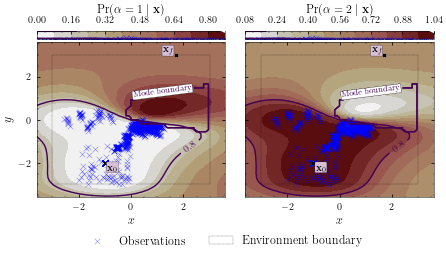

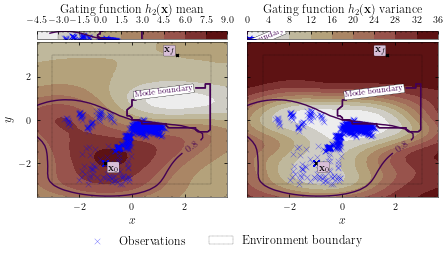

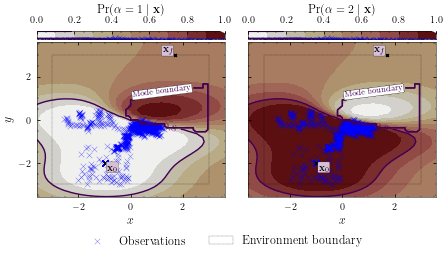

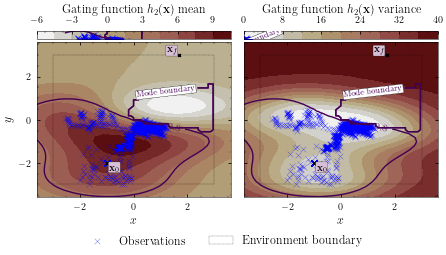

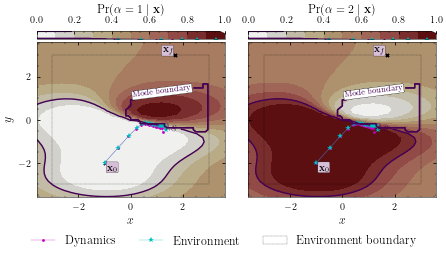

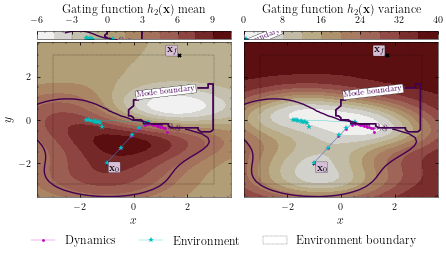

Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: -593.4317 - val_loss: -793.8780
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_17_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -800.8443

2022-04-08 18:44:32.630357: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 18:44:32.630371: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -800.8443 - val_loss: -902.5225
Epoch 3/10000
1/1 [==============================] - 0s 54ms/step - loss: -933.5424 - val_loss: -930.1255
Epoch 4/10000
1/1 [==============================] - ETA: 0s - loss: -883.8627

2022-04-08 18:44:34.331279: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 18:44:34.349454: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 18:44:34.358779: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_44_34

2022-04-08 18:44:34.366671: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_44_34/dr-robots-mbp.local.trace.json.gz
2022-04-08 18:44:34.394074: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_44_34

2022-04-08 18:44:34.39434

1/1 [==============================] - 0s 57ms/step - loss: -883.8627 - val_loss: -921.6978
Epoch 5/10000
1/1 [==============================] - 0s 52ms/step - loss: -893.3619 - val_loss: -902.1669
Epoch 6/10000
1/1 [==============================] - 0s 52ms/step - loss: -840.1318 - val_loss: -886.9803
Epoch 7/10000
1/1 [==============================] - 0s 49ms/step - loss: -920.9212 - val_loss: -876.0376
Epoch 8/10000
1/1 [==============================] - 0s 49ms/step - loss: -894.7373 - val_loss: -889.5364
Epoch 9/10000
1/1 [==============================] - 0s 50ms/step - loss: -820.4197 - val_loss: -847.6514
Epoch 10/10000
1/1 [==============================] - 0s 50ms/step - loss: -922.0652 - val_loss: -900.2877
Epoch 11/10000
1/1 [==============================] - 0s 48ms/step - loss: -849.9718 - val_loss: -827.7974
Epoch 12/10000
1/1 [==============================] - 0s 53ms/step - loss: -772.2951 - val_loss: -863.6599
Epoch 13/10000
1/1 [==============================] - 0s 

Epoch 81/10000
1/1 [==============================] - 0s 60ms/step - loss: -887.6849 - val_loss: -894.7145
Epoch 82/10000
1/1 [==============================] - 0s 58ms/step - loss: -838.7150 - val_loss: -862.5223
Epoch 83/10000
1/1 [==============================] - 0s 59ms/step - loss: -859.1092 - val_loss: -886.5588
Epoch 84/10000
1/1 [==============================] - 0s 58ms/step - loss: -896.1274 - val_loss: -897.9503
Epoch 85/10000
1/1 [==============================] - 0s 57ms/step - loss: -615.6896 - val_loss: -773.4910
Epoch 86/10000
1/1 [==============================] - 0s 57ms/step - loss: -877.0383 - val_loss: -864.9403
Epoch 87/10000
1/1 [==============================] - 0s 58ms/step - loss: -810.5615 - val_loss: -818.5127
Epoch 88/10000
1/1 [==============================] - 0s 58ms/step - loss: -860.9471 - val_loss: -847.2168
Epoch 89/10000
1/1 [==============================] - 0s 55ms/step - loss: -782.1487 - val_loss: -854.3206
Epoch 90/10000
1/1 [=================

1/1 [==============================] - 0s 59ms/step - loss: -913.8465 - val_loss: -903.2174
Epoch 158/10000
1/1 [==============================] - 0s 54ms/step - loss: -898.6381 - val_loss: -873.8779
Epoch 159/10000
1/1 [==============================] - 0s 58ms/step - loss: -866.3324 - val_loss: -900.5344
Epoch 160/10000
1/1 [==============================] - 0s 55ms/step - loss: -905.4053 - val_loss: -901.0720
Epoch 161/10000
1/1 [==============================] - 0s 57ms/step - loss: -886.2991 - val_loss: -890.7847
Epoch 162/10000
1/1 [==============================] - 0s 59ms/step - loss: -913.2957 - val_loss: -902.0004
Epoch 163/10000
1/1 [==============================] - 0s 57ms/step - loss: -910.8269 - val_loss: -906.1116
Epoch 164/10000
1/1 [==============================] - 0s 58ms/step - loss: -922.4799 - val_loss: -912.2891
Epoch 165/10000
1/1 [==============================] - 0s 63ms/step - loss: -729.4342 - val_loss: -855.5390
Epoch 166/10000
1/1 [=======================

1/1 [==============================] - 0s 61ms/step - loss: -749.0676 - val_loss: -761.6662
Epoch 234/10000
1/1 [==============================] - 0s 59ms/step - loss: -816.8060 - val_loss: -817.9685
Epoch 235/10000
1/1 [==============================] - 0s 67ms/step - loss: -701.1459 - val_loss: -734.2195
Epoch 236/10000
1/1 [==============================] - 0s 102ms/step - loss: -772.9693 - val_loss: -785.1654
Epoch 237/10000
1/1 [==============================] - 0s 84ms/step - loss: -724.6508 - val_loss: -773.3724
Epoch 238/10000
1/1 [==============================] - 0s 69ms/step - loss: -816.0952 - val_loss: -805.7753
Epoch 239/10000
1/1 [==============================] - 0s 77ms/step - loss: -819.6385 - val_loss: -835.7756
Epoch 240/10000
1/1 [==============================] - 0s 72ms/step - loss: -808.0112 - val_loss: -829.6795
Epoch 241/10000
1/1 [==============================] - 0s 75ms/step - loss: -812.2394 - val_loss: -814.4577
Epoch 242/10000
1/1 [======================

Epoch 309/10000
1/1 [==============================] - 0s 77ms/step - loss: -904.9885 - val_loss: -910.5997
Epoch 310/10000
1/1 [==============================] - 0s 78ms/step - loss: -897.4016 - val_loss: -916.1520
Epoch 311/10000
1/1 [==============================] - 0s 73ms/step - loss: -921.8630 - val_loss: -913.8241
Epoch 312/10000
1/1 [==============================] - 0s 76ms/step - loss: -925.0833 - val_loss: -921.6513
Epoch 313/10000
1/1 [==============================] - 0s 79ms/step - loss: -907.1417 - val_loss: -912.3000
Epoch 314/10000
1/1 [==============================] - 0s 77ms/step - loss: -900.9595 - val_loss: -914.2493
Epoch 315/10000
1/1 [==============================] - 0s 82ms/step - loss: -875.9825 - val_loss: -897.6534
Epoch 316/10000
1/1 [==============================] - 0s 96ms/step - loss: -894.7798 - val_loss: -920.4570
Epoch 317/10000
1/1 [==============================] - 0s 84ms/step - loss: -895.9290 - val_loss: -923.9015
Epoch 318/10000
1/1 [=======

Epoch 460/10000
1/1 [==============================] - 0s 77ms/step - loss: -851.3898 - val_loss: -864.6864
Epoch 461/10000
1/1 [==============================] - 0s 84ms/step - loss: -808.6522 - val_loss: -863.3544
Epoch 462/10000
1/1 [==============================] - 0s 82ms/step - loss: -901.4651 - val_loss: -899.2012
Epoch 463/10000
1/1 [==============================] - 0s 81ms/step - loss: -887.0918 - val_loss: -879.5494
Epoch 464/10000
1/1 [==============================] - 0s 82ms/step - loss: -864.1540 - val_loss: -876.9544
Epoch 465/10000
1/1 [==============================] - 0s 84ms/step - loss: -907.0845 - val_loss: -903.7055
Epoch 466/10000
1/1 [==============================] - 0s 94ms/step - loss: -893.5656 - val_loss: -891.2002
Epoch 467/10000
1/1 [==============================] - 0s 92ms/step - loss: -890.3653 - val_loss: -891.8651
Epoch 468/10000
1/1 [==============================] - 0s 90ms/step - loss: -842.0463 - val_loss: -868.1214
Epoch 469/10000
1/1 [=======

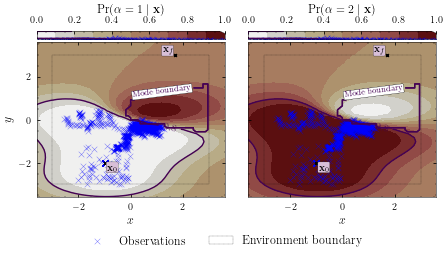

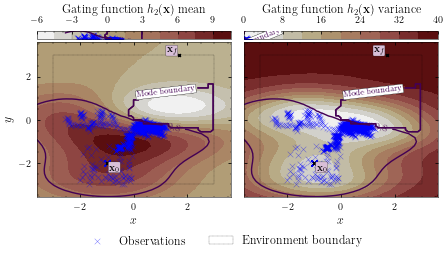

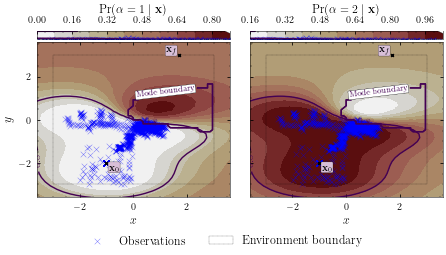

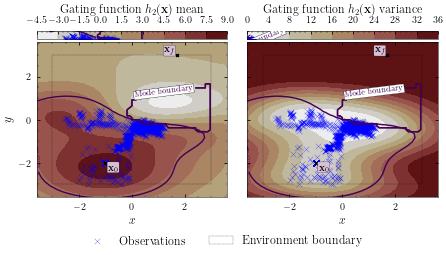

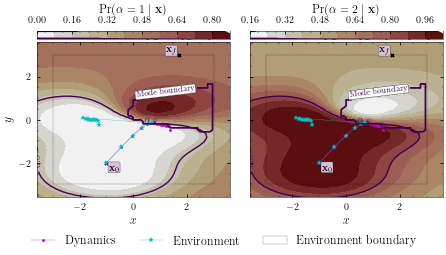

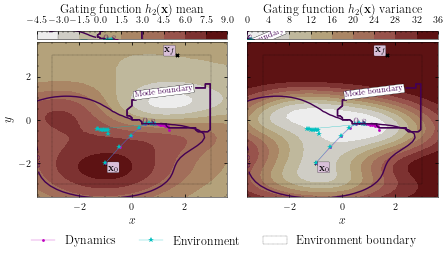

Epoch 1/10000
1/1 [==============================] - 1s 737ms/step - loss: -825.5809 - val_loss: -858.2379
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_18_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -915.5595

2022-04-08 18:46:56.464265: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 18:46:56.464294: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 3s 3s/step - loss: -915.5595 - val_loss: -864.6206


2022-04-08 18:46:58.843798: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 18:46:58.866489: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 18:46:58.880556: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_46_58

2022-04-08 18:46:58.902223: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_46_58/dr-robots-mbp.local.trace.json.gz
2022-04-08 18:46:58.947736: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_46_58

2022-04-08 18:46:58.94809

Epoch 3/10000
1/1 [==============================] - 0s 66ms/step - loss: -892.0307 - val_loss: -879.9521
Epoch 4/10000
1/1 [==============================] - 0s 62ms/step - loss: -886.2677 - val_loss: -842.2584
Epoch 5/10000
1/1 [==============================] - 0s 65ms/step - loss: -859.1196 - val_loss: -852.4779
Epoch 6/10000
1/1 [==============================] - 0s 69ms/step - loss: -878.5565 - val_loss: -880.4013
Epoch 7/10000
1/1 [==============================] - 0s 72ms/step - loss: -896.9630 - val_loss: -869.8195
Epoch 8/10000
1/1 [==============================] - 0s 65ms/step - loss: -914.9074 - val_loss: -889.6691
Epoch 9/10000
1/1 [==============================] - 0s 69ms/step - loss: -881.5697 - val_loss: -875.2123
Epoch 10/10000
1/1 [==============================] - 0s 69ms/step - loss: -915.5053 - val_loss: -877.8747
Epoch 11/10000
1/1 [==============================] - 0s 63ms/step - loss: -875.4438 - val_loss: -867.5817
Epoch 12/10000
1/1 [========================

1/1 [==============================] - 0s 74ms/step - loss: -557.1271 - val_loss: -753.4981
Epoch 156/10000
1/1 [==============================] - 0s 73ms/step - loss: -759.8114 - val_loss: -832.1205
Epoch 157/10000
1/1 [==============================] - 0s 75ms/step - loss: -716.0836 - val_loss: -636.6969
Epoch 158/10000
1/1 [==============================] - 0s 78ms/step - loss: 807.0460 - val_loss: 762.3789
Epoch 159/10000
1/1 [==============================] - 0s 78ms/step - loss: 121.0972 - val_loss: -374.1501
Epoch 160/10000
1/1 [==============================] - 0s 79ms/step - loss: -718.7993 - val_loss: -568.1913
Epoch 161/10000
1/1 [==============================] - 0s 87ms/step - loss: -546.5989 - val_loss: -448.1507
Epoch 162/10000
1/1 [==============================] - 0s 84ms/step - loss: -802.7770 - val_loss: -789.8216
Epoch 163/10000
1/1 [==============================] - 0s 79ms/step - loss: -4.9307 - val_loss: -71.5699
Epoch 164/10000
1/1 [=============================

1/1 [==============================] - 0s 63ms/step - loss: -811.2846 - val_loss: -790.9450
Epoch 232/10000
1/1 [==============================] - 0s 64ms/step - loss: -809.3289 - val_loss: -779.5919
Epoch 233/10000
1/1 [==============================] - 0s 65ms/step - loss: -781.8200 - val_loss: -767.3177
Epoch 234/10000
1/1 [==============================] - 0s 66ms/step - loss: -811.5893 - val_loss: -788.2291
Epoch 235/10000
1/1 [==============================] - 0s 64ms/step - loss: -787.9899 - val_loss: -774.4594
Epoch 236/10000
1/1 [==============================] - 0s 64ms/step - loss: -823.8686 - val_loss: -799.7587
Epoch 237/10000
1/1 [==============================] - 0s 66ms/step - loss: -825.6631 - val_loss: -797.4488
Epoch 238/10000
1/1 [==============================] - 0s 67ms/step - loss: -824.3207 - val_loss: -808.4231
Epoch 239/10000
1/1 [==============================] - 0s 66ms/step - loss: -819.0018 - val_loss: -792.5084
Epoch 240/10000
1/1 [=======================

1/1 [==============================] - 0s 66ms/step - loss: -931.8114 - val_loss: -895.8587
Epoch 308/10000
1/1 [==============================] - 0s 68ms/step - loss: -931.2526 - val_loss: -899.6212
Epoch 309/10000
1/1 [==============================] - 0s 64ms/step - loss: -926.6912 - val_loss: -884.5407
Epoch 310/10000
1/1 [==============================] - 0s 67ms/step - loss: -909.3815 - val_loss: -864.3339
Epoch 311/10000
1/1 [==============================] - 0s 68ms/step - loss: -929.0213 - val_loss: -880.2460
Epoch 312/10000
1/1 [==============================] - 0s 67ms/step - loss: -935.5902 - val_loss: -897.9425
Epoch 313/10000
1/1 [==============================] - 0s 70ms/step - loss: -886.4116 - val_loss: -903.1294
Epoch 314/10000
1/1 [==============================] - 0s 65ms/step - loss: -922.6588 - val_loss: -895.1292
Epoch 315/10000
1/1 [==============================] - 0s 68ms/step - loss: -926.0663 - val_loss: -895.5157
Epoch 316/10000
1/1 [=======================

1/1 [==============================] - 0s 67ms/step - loss: 559.0000 - val_loss: -25.4797
Epoch 384/10000
1/1 [==============================] - 0s 66ms/step - loss: -552.9360 - val_loss: -656.3467
Epoch 385/10000
1/1 [==============================] - 0s 68ms/step - loss: 615.9143 - val_loss: 87.4342
Epoch 386/10000
1/1 [==============================] - 0s 65ms/step - loss: -644.5042 - val_loss: -615.2950
Epoch 387/10000
1/1 [==============================] - 0s 67ms/step - loss: -661.2730 - val_loss: -726.5491
Epoch 388/10000
1/1 [==============================] - 0s 69ms/step - loss: -823.5063 - val_loss: -785.3250
Epoch 389/10000
1/1 [==============================] - 0s 65ms/step - loss: -588.7790 - val_loss: -690.4529
Epoch 390/10000
1/1 [==============================] - 0s 65ms/step - loss: -814.7732 - val_loss: -747.2997
Epoch 391/10000
1/1 [==============================] - 0s 62ms/step - loss: -747.7233 - val_loss: -691.2892
Epoch 392/10000
1/1 [============================

1/1 [==============================] - 0s 64ms/step - loss: -830.4166 - val_loss: -810.8267
Epoch 460/10000
1/1 [==============================] - 0s 63ms/step - loss: -839.2715 - val_loss: -820.3167
Epoch 461/10000
1/1 [==============================] - 0s 63ms/step - loss: -816.9769 - val_loss: -807.5051
Epoch 462/10000
1/1 [==============================] - 0s 62ms/step - loss: -848.5789 - val_loss: -819.2725
Epoch 463/10000
1/1 [==============================] - 0s 63ms/step - loss: -831.8764 - val_loss: -816.2366
Epoch 464/10000
1/1 [==============================] - 0s 62ms/step - loss: -819.0210 - val_loss: -815.4698
Epoch 465/10000
1/1 [==============================] - 0s 62ms/step - loss: -829.3152 - val_loss: -801.7765
Epoch 466/10000
1/1 [==============================] - 0s 62ms/step - loss: -802.5516 - val_loss: -785.0902
Epoch 467/10000
1/1 [==============================] - 0s 63ms/step - loss: -746.3925 - val_loss: -797.4848
Epoch 468/10000
1/1 [=======================

Epoch 535/10000
1/1 [==============================] - 0s 64ms/step - loss: -928.2607 - val_loss: -892.5841
Epoch 536/10000
1/1 [==============================] - 0s 66ms/step - loss: -915.7832 - val_loss: -896.5209
Epoch 537/10000
1/1 [==============================] - 0s 66ms/step - loss: -928.0137 - val_loss: -883.0324
Epoch 538/10000
1/1 [==============================] - 0s 66ms/step - loss: -860.2274 - val_loss: -828.9287
Epoch 539/10000
1/1 [==============================] - 0s 69ms/step - loss: -913.9623 - val_loss: -894.6076
Epoch 540/10000
1/1 [==============================] - 0s 69ms/step - loss: -861.2931 - val_loss: -825.2207
Epoch 541/10000
1/1 [==============================] - 0s 69ms/step - loss: -928.7268 - val_loss: -883.8773
Epoch 542/10000
1/1 [==============================] - 0s 67ms/step - loss: -896.7490 - val_loss: -868.3835
Epoch 543/10000
1/1 [==============================] - 0s 68ms/step - loss: -947.6115 - val_loss: -910.4385
Epoch 544/10000
1/1 [=======

Epoch 611/10000
1/1 [==============================] - 0s 63ms/step - loss: -609.5312 - val_loss: -683.3596
Epoch 612/10000
1/1 [==============================] - 0s 63ms/step - loss: -731.8638 - val_loss: -772.8025
Epoch 613/10000
1/1 [==============================] - 0s 61ms/step - loss: -753.6338 - val_loss: -614.1940
Epoch 614/10000
1/1 [==============================] - 0s 61ms/step - loss: -526.6520 - val_loss: -467.1457
Epoch 615/10000
1/1 [==============================] - 0s 63ms/step - loss: -438.6979 - val_loss: -622.3796
Epoch 616/10000
1/1 [==============================] - 0s 61ms/step - loss: -519.5359 - val_loss: -647.2093
Epoch 617/10000
1/1 [==============================] - 0s 60ms/step - loss: -779.9321 - val_loss: -872.8495
Epoch 618/10000
1/1 [==============================] - 0s 61ms/step - loss: -825.9473 - val_loss: -864.4901
Epoch 619/10000
1/1 [==============================] - 0s 59ms/step - loss: -842.6736 - val_loss: -674.8274
Epoch 620/10000
1/1 [=======

Epoch 687/10000
1/1 [==============================] - 0s 59ms/step - loss: -814.5051 - val_loss: -812.2139
Epoch 688/10000
1/1 [==============================] - 0s 61ms/step - loss: -887.1583 - val_loss: -854.8267
Epoch 689/10000
1/1 [==============================] - 0s 60ms/step - loss: -878.4819 - val_loss: -852.0841
Epoch 690/10000
1/1 [==============================] - 0s 61ms/step - loss: -879.6005 - val_loss: -844.2787
Epoch 691/10000
1/1 [==============================] - 0s 59ms/step - loss: -875.3919 - val_loss: -849.6079
Epoch 692/10000
1/1 [==============================] - 0s 61ms/step - loss: -778.5581 - val_loss: -795.1947
Epoch 693/10000
1/1 [==============================] - 0s 60ms/step - loss: -886.9190 - val_loss: -846.2834
Epoch 694/10000
1/1 [==============================] - 0s 62ms/step - loss: -888.1885 - val_loss: -855.7729
Epoch 695/10000
1/1 [==============================] - 0s 60ms/step - loss: -894.4276 - val_loss: -856.2905
Epoch 696/10000
1/1 [=======

Epoch 763/10000
1/1 [==============================] - 0s 66ms/step - loss: -784.8349 - val_loss: -856.2569
Epoch 764/10000
1/1 [==============================] - 0s 64ms/step - loss: -189.9040 - val_loss: -844.3023
Epoch 765/10000
1/1 [==============================] - 0s 67ms/step - loss: -830.7431 - val_loss: -784.0513
Epoch 766/10000
1/1 [==============================] - 0s 67ms/step - loss: -859.5417 - val_loss: -784.8306
Epoch 767/10000
1/1 [==============================] - 0s 66ms/step - loss: -621.6789 - val_loss: -807.2787
Epoch 768/10000
1/1 [==============================] - 0s 76ms/step - loss: -859.0346 - val_loss: -813.4248
Epoch 769/10000
1/1 [==============================] - 0s 62ms/step - loss: -669.3657 - val_loss: -676.8791
Epoch 770/10000
1/1 [==============================] - 0s 62ms/step - loss: -26.2835 - val_loss: -703.7315
Epoch 771/10000
1/1 [==============================] - 0s 62ms/step - loss: -644.0005 - val_loss: -545.2692
Epoch 772/10000
1/1 [========

Epoch 839/10000
1/1 [==============================] - 0s 59ms/step - loss: -841.4805 - val_loss: -810.5851
Epoch 840/10000
1/1 [==============================] - 0s 61ms/step - loss: -835.3552 - val_loss: -800.2828
Epoch 841/10000
1/1 [==============================] - 0s 60ms/step - loss: -835.3057 - val_loss: -801.4164
Epoch 842/10000
1/1 [==============================] - 0s 58ms/step - loss: -824.0122 - val_loss: -786.4817
Epoch 843/10000
1/1 [==============================] - 0s 60ms/step - loss: -747.0107 - val_loss: -742.2712
Epoch 844/10000
1/1 [==============================] - 0s 61ms/step - loss: -808.0961 - val_loss: -792.4313
Epoch 845/10000
1/1 [==============================] - 0s 60ms/step - loss: -835.6406 - val_loss: -819.7507
Epoch 846/10000
1/1 [==============================] - 0s 58ms/step - loss: -835.0519 - val_loss: -815.0100
Epoch 847/10000
1/1 [==============================] - 0s 59ms/step - loss: -835.0237 - val_loss: -794.3010
Epoch 848/10000
1/1 [=======

Epoch 915/10000
1/1 [==============================] - 0s 80ms/step - loss: -941.3554 - val_loss: -908.4825
Epoch 916/10000
1/1 [==============================] - 0s 62ms/step - loss: -930.9508 - val_loss: -895.9305
Epoch 917/10000
1/1 [==============================] - 0s 59ms/step - loss: -935.0571 - val_loss: -908.4097
Epoch 918/10000
1/1 [==============================] - 0s 60ms/step - loss: -920.9982 - val_loss: -895.6384
Epoch 919/10000
1/1 [==============================] - 0s 61ms/step - loss: -919.4525 - val_loss: -905.5020
Epoch 920/10000
1/1 [==============================] - 0s 66ms/step - loss: -917.2175 - val_loss: -893.0522
Epoch 921/10000
1/1 [==============================] - 0s 61ms/step - loss: -936.5156 - val_loss: -908.0453
Epoch 922/10000
1/1 [==============================] - 0s 61ms/step - loss: -928.3172 - val_loss: -897.6122
Epoch 923/10000
1/1 [==============================] - 0s 94ms/step - loss: -917.2559 - val_loss: -888.3423
Epoch 924/10000
1/1 [=======

Epoch 991/10000
1/1 [==============================] - 0s 66ms/step - loss: -767.9236 - val_loss: -753.5293
Epoch 992/10000
1/1 [==============================] - 0s 64ms/step - loss: 379.2808 - val_loss: -47.9876
Epoch 993/10000
1/1 [==============================] - 0s 64ms/step - loss: -375.5591 - val_loss: -486.4621
Epoch 994/10000
1/1 [==============================] - 0s 66ms/step - loss: -754.4375 - val_loss: -769.3482
Epoch 995/10000
1/1 [==============================] - 0s 66ms/step - loss: -767.8854 - val_loss: -808.3699
Epoch 996/10000
1/1 [==============================] - 0s 63ms/step - loss: 468.3622 - val_loss: 174.2955
Epoch 997/10000
1/1 [==============================] - 0s 64ms/step - loss: -377.1466 - val_loss: -553.8969
Epoch 998/10000
1/1 [==============================] - 0s 63ms/step - loss: -619.2484 - val_loss: -686.3073
Epoch 999/10000
1/1 [==============================] - 0s 66ms/step - loss: -707.2747 - val_loss: -747.9619
Epoch 1000/10000
1/1 [==========

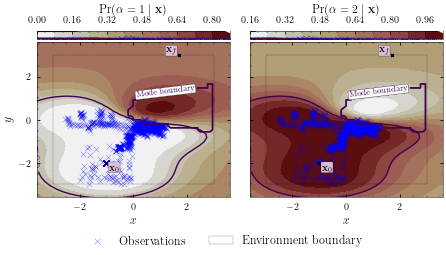

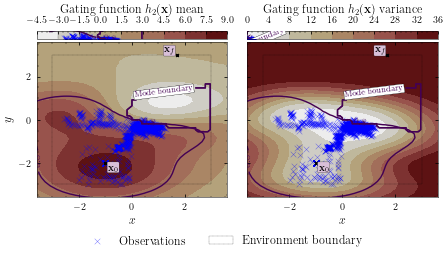

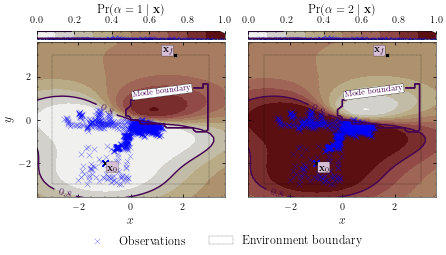

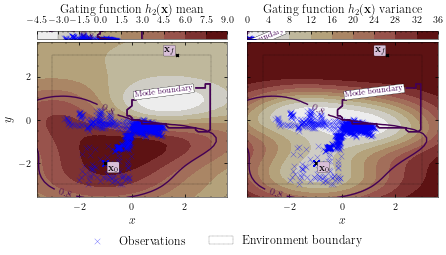

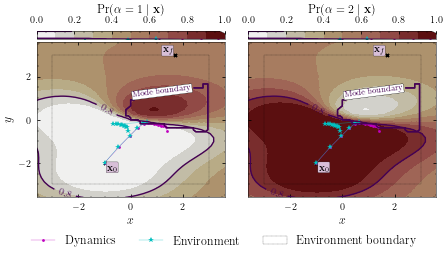

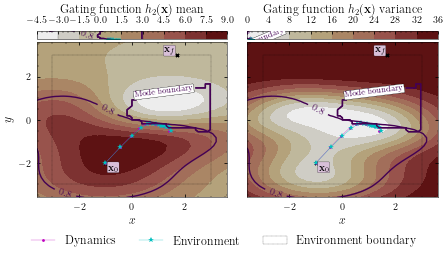

Epoch 1/10000
1/1 [==============================] - 1s 658ms/step - loss: -864.2977 - val_loss: -811.0499
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_19_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -869.5738

2022-04-08 18:49:54.509155: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 18:49:54.509172: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -869.5738 - val_loss: -803.2776
Epoch 3/10000
1/1 [==============================] - ETA: 0s - loss: -877.1389

2022-04-08 18:49:56.380750: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 18:49:56.415149: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 18:49:56.427025: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_49_56

2022-04-08 18:49:56.437488: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_49_56/dr-robots-mbp.local.trace.json.gz
2022-04-08 18:49:56.483016: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_49_56

2022-04-08 18:49:56.48338

1/1 [==============================] - 0s 64ms/step - loss: -877.1389 - val_loss: -814.6082
Epoch 4/10000
1/1 [==============================] - 0s 66ms/step - loss: -884.8071 - val_loss: -823.0284
Epoch 5/10000
1/1 [==============================] - 0s 65ms/step - loss: -878.7396 - val_loss: -833.9530
Epoch 6/10000
1/1 [==============================] - 0s 67ms/step - loss: -890.6987 - val_loss: -828.7904
Epoch 7/10000
1/1 [==============================] - 0s 68ms/step - loss: -873.9183 - val_loss: -814.5422
Epoch 8/10000
1/1 [==============================] - 0s 67ms/step - loss: -875.8077 - val_loss: -819.0716
Epoch 9/10000
1/1 [==============================] - 0s 66ms/step - loss: -876.3365 - val_loss: -830.0042
Epoch 10/10000
1/1 [==============================] - 0s 66ms/step - loss: -839.9523 - val_loss: -789.4208
Epoch 11/10000
1/1 [==============================] - 0s 70ms/step - loss: -888.1292 - val_loss: -840.1795
Epoch 12/10000
1/1 [==============================] - 0s 6

Epoch 80/10000
1/1 [==============================] - 0s 81ms/step - loss: -813.8590 - val_loss: -733.0539
Epoch 81/10000
1/1 [==============================] - 0s 80ms/step - loss: -910.2528 - val_loss: -846.7537
Epoch 82/10000
1/1 [==============================] - 0s 76ms/step - loss: -755.2435 - val_loss: -800.4183
Epoch 83/10000
1/1 [==============================] - 0s 80ms/step - loss: -898.1383 - val_loss: -847.5569
Epoch 84/10000
1/1 [==============================] - 0s 82ms/step - loss: -792.3184 - val_loss: -640.9972
Epoch 85/10000
1/1 [==============================] - 0s 84ms/step - loss: -868.8515 - val_loss: -821.9588
Epoch 86/10000
1/1 [==============================] - 0s 73ms/step - loss: -842.2111 - val_loss: -763.5029
Epoch 87/10000
1/1 [==============================] - 0s 71ms/step - loss: -873.2098 - val_loss: -772.1033
Epoch 88/10000
1/1 [==============================] - 0s 71ms/step - loss: -680.6567 - val_loss: -693.4099
Epoch 89/10000
1/1 [=================

1/1 [==============================] - 0s 73ms/step - loss: -371.5137 - val_loss: -465.3076
Epoch 157/10000
1/1 [==============================] - 0s 73ms/step - loss: -839.9717 - val_loss: -771.9129
Epoch 158/10000
1/1 [==============================] - 0s 72ms/step - loss: -383.3051 - val_loss: -364.6560
Epoch 159/10000
1/1 [==============================] - 0s 72ms/step - loss: -785.9487 - val_loss: -660.2620
Epoch 160/10000
1/1 [==============================] - 0s 73ms/step - loss: -765.3447 - val_loss: -745.1512
Epoch 161/10000
1/1 [==============================] - 0s 85ms/step - loss: -619.9925 - val_loss: -690.1284
Epoch 162/10000
1/1 [==============================] - 0s 78ms/step - loss: -815.4893 - val_loss: -777.4435
Epoch 163/10000
1/1 [==============================] - 0s 76ms/step - loss: -805.7408 - val_loss: -765.1594
Epoch 164/10000
1/1 [==============================] - 0s 75ms/step - loss: -716.0401 - val_loss: -650.1814
Epoch 165/10000
1/1 [=======================

1/1 [==============================] - 0s 87ms/step - loss: -779.0993 - val_loss: -718.8533
Epoch 233/10000
1/1 [==============================] - 0s 81ms/step - loss: -784.7405 - val_loss: -741.7603
Epoch 234/10000
1/1 [==============================] - 0s 80ms/step - loss: -765.0032 - val_loss: -706.2571
Epoch 235/10000
1/1 [==============================] - 0s 86ms/step - loss: -739.1324 - val_loss: -713.0030
Epoch 236/10000
1/1 [==============================] - 0s 90ms/step - loss: -743.9388 - val_loss: -719.7872
Epoch 237/10000
1/1 [==============================] - 0s 96ms/step - loss: -792.1535 - val_loss: -741.6778
Epoch 238/10000
1/1 [==============================] - 0s 88ms/step - loss: -762.2236 - val_loss: -719.9134
Epoch 239/10000
1/1 [==============================] - 0s 89ms/step - loss: -801.0684 - val_loss: -746.8691
Epoch 240/10000
1/1 [==============================] - 0s 84ms/step - loss: -742.9182 - val_loss: -691.9203
Epoch 241/10000
1/1 [=======================

Epoch 308/10000
1/1 [==============================] - 0s 125ms/step - loss: -916.4990 - val_loss: -846.0896
Epoch 309/10000
1/1 [==============================] - 0s 75ms/step - loss: -884.3383 - val_loss: -814.6096
Epoch 310/10000
1/1 [==============================] - 0s 73ms/step - loss: -924.3380 - val_loss: -863.7707
Epoch 311/10000
1/1 [==============================] - 0s 76ms/step - loss: -912.9585 - val_loss: -854.9123
Epoch 312/10000
1/1 [==============================] - 0s 77ms/step - loss: -840.5730 - val_loss: -815.5462
Epoch 313/10000
1/1 [==============================] - 0s 77ms/step - loss: -896.0900 - val_loss: -832.0799
Epoch 314/10000
1/1 [==============================] - 0s 76ms/step - loss: -925.3815 - val_loss: -860.8050
Epoch 315/10000
1/1 [==============================] - 0s 77ms/step - loss: -918.1810 - val_loss: -862.2928
Epoch 316/10000
1/1 [==============================] - 0s 80ms/step - loss: -897.8712 - val_loss: -845.2007
Epoch 317/10000
1/1 [======

Epoch 384/10000
1/1 [==============================] - 0s 84ms/step - loss: -715.0497 - val_loss: -696.1886
Epoch 385/10000
1/1 [==============================] - 0s 83ms/step - loss: -749.5933 - val_loss: -813.0109
Epoch 386/10000
1/1 [==============================] - 0s 89ms/step - loss: -666.8065 - val_loss: -757.8618
Epoch 387/10000
1/1 [==============================] - 0s 95ms/step - loss: -867.6771 - val_loss: -845.8963
Epoch 388/10000
1/1 [==============================] - 0s 80ms/step - loss: -857.2213 - val_loss: -845.9557
Epoch 389/10000
1/1 [==============================] - 0s 82ms/step - loss: -820.6464 - val_loss: -701.1596
Epoch 390/10000
1/1 [==============================] - 0s 88ms/step - loss: -185.7884 - val_loss: -437.4039
Epoch 391/10000
1/1 [==============================] - 0s 92ms/step - loss: -523.9926 - val_loss: -529.4503
Epoch 392/10000
1/1 [==============================] - 0s 90ms/step - loss: -501.1388 - val_loss: -643.6459
Epoch 393/10000
1/1 [=======

Epoch 460/10000
1/1 [==============================] - 0s 83ms/step - loss: -834.8070 - val_loss: -777.5872
Epoch 461/10000
1/1 [==============================] - 0s 88ms/step - loss: -836.9435 - val_loss: -787.0578
Epoch 462/10000
1/1 [==============================] - 0s 82ms/step - loss: -692.0273 - val_loss: -744.4977
Epoch 463/10000
1/1 [==============================] - 0s 82ms/step - loss: -412.8609 - val_loss: -533.8181
Epoch 464/10000
1/1 [==============================] - 0s 84ms/step - loss: -792.0761 - val_loss: -776.7892
Epoch 465/10000
1/1 [==============================] - 0s 84ms/step - loss: -789.1653 - val_loss: -746.2745
Epoch 466/10000
1/1 [==============================] - 0s 79ms/step - loss: -826.9943 - val_loss: -796.5812
Epoch 467/10000
1/1 [==============================] - 0s 91ms/step - loss: -852.8174 - val_loss: -787.6638
Epoch 468/10000
1/1 [==============================] - 0s 82ms/step - loss: -823.9344 - val_loss: -786.3291
Epoch 469/10000
1/1 [=======

Epoch 536/10000
1/1 [==============================] - 0s 67ms/step - loss: -785.3365 - val_loss: -671.3877
Epoch 537/10000
1/1 [==============================] - 0s 72ms/step - loss: -789.6923 - val_loss: -739.5243
Epoch 538/10000
1/1 [==============================] - 0s 73ms/step - loss: -882.4454 - val_loss: -832.0908
Epoch 539/10000
1/1 [==============================] - 0s 70ms/step - loss: -806.8121 - val_loss: -789.7320
Epoch 540/10000
1/1 [==============================] - 0s 69ms/step - loss: -725.3243 - val_loss: -725.1870
Epoch 541/10000
1/1 [==============================] - 0s 69ms/step - loss: -790.9433 - val_loss: -729.8000
Epoch 542/10000
1/1 [==============================] - 0s 74ms/step - loss: -886.0542 - val_loss: -849.0078
Epoch 543/10000
1/1 [==============================] - 0s 75ms/step - loss: -860.8459 - val_loss: -787.1118
Epoch 544/10000
1/1 [==============================] - 0s 70ms/step - loss: -767.9102 - val_loss: -788.6433
Epoch 545/10000
1/1 [=======

Epoch 612/10000
1/1 [==============================] - 0s 69ms/step - loss: -911.7283 - val_loss: -845.9405
Epoch 613/10000
1/1 [==============================] - 0s 70ms/step - loss: -885.8225 - val_loss: -854.2581
Epoch 614/10000
1/1 [==============================] - 0s 71ms/step - loss: -863.9433 - val_loss: -853.1454
Epoch 615/10000
1/1 [==============================] - 0s 69ms/step - loss: -919.5284 - val_loss: -853.5131
Epoch 616/10000
1/1 [==============================] - 0s 74ms/step - loss: -921.1624 - val_loss: -848.0329
Epoch 617/10000
1/1 [==============================] - 0s 71ms/step - loss: -938.2714 - val_loss: -868.7846
Epoch 618/10000
1/1 [==============================] - 0s 69ms/step - loss: -933.4580 - val_loss: -875.3684
Epoch 619/10000
1/1 [==============================] - 0s 69ms/step - loss: -913.2565 - val_loss: -846.2101
Epoch 620/10000
1/1 [==============================] - 0s 67ms/step - loss: -913.0839 - val_loss: -856.1723
Epoch 621/10000
1/1 [=======

1/1 [==============================] - 0s 62ms/step - loss: -702.7542 - val_loss: -718.1021
Epoch 689/10000
1/1 [==============================] - 0s 65ms/step - loss: -462.6358 - val_loss: -466.2512
Epoch 690/10000
1/1 [==============================] - 0s 63ms/step - loss: -770.2303 - val_loss: -729.6357
Epoch 691/10000
1/1 [==============================] - 0s 64ms/step - loss: -684.7612 - val_loss: -658.3435
Epoch 692/10000
1/1 [==============================] - 0s 68ms/step - loss: -796.0116 - val_loss: -731.6999
Epoch 693/10000
1/1 [==============================] - 0s 65ms/step - loss: -762.2988 - val_loss: -753.3004
Epoch 694/10000
1/1 [==============================] - 0s 60ms/step - loss: -762.6888 - val_loss: -753.1229
Epoch 695/10000
1/1 [==============================] - 0s 62ms/step - loss: -781.4142 - val_loss: -736.9101
Epoch 696/10000
1/1 [==============================] - 0s 64ms/step - loss: -769.7711 - val_loss: -734.3572
Epoch 697/10000
1/1 [=======================

1/1 [==============================] - 0s 66ms/step - loss: -879.6526 - val_loss: -811.0740
Epoch 765/10000
1/1 [==============================] - 0s 67ms/step - loss: -891.2165 - val_loss: -841.4620
Epoch 766/10000
1/1 [==============================] - 0s 64ms/step - loss: -896.8821 - val_loss: -833.7574
Epoch 767/10000
1/1 [==============================] - 0s 63ms/step - loss: -882.8488 - val_loss: -829.5181
Epoch 768/10000
1/1 [==============================] - 0s 69ms/step - loss: -906.9127 - val_loss: -849.7905
Epoch 769/10000
1/1 [==============================] - 0s 73ms/step - loss: -906.0283 - val_loss: -833.7052
Epoch 770/10000
1/1 [==============================] - 0s 68ms/step - loss: -911.8893 - val_loss: -852.8064
Epoch 771/10000
1/1 [==============================] - 0s 68ms/step - loss: -896.1693 - val_loss: -845.4843
Epoch 772/10000
1/1 [==============================] - 0s 71ms/step - loss: -899.7833 - val_loss: -851.2765
Epoch 773/10000
1/1 [=======================

1/1 [==============================] - 0s 62ms/step - loss: -929.7053 - val_loss: -781.7323
Epoch 841/10000
1/1 [==============================] - 0s 62ms/step - loss: -932.5411 - val_loss: -869.1451
Epoch 842/10000
1/1 [==============================] - 0s 62ms/step - loss: -908.2844 - val_loss: -814.4753
Epoch 843/10000
1/1 [==============================] - 0s 64ms/step - loss: -894.2785 - val_loss: -841.7648
Epoch 844/10000
1/1 [==============================] - 0s 63ms/step - loss: -839.5136 - val_loss: -817.2166
Epoch 845/10000
1/1 [==============================] - 0s 61ms/step - loss: -792.3956 - val_loss: -810.8230
Epoch 846/10000
1/1 [==============================] - 0s 64ms/step - loss: -358.5761 - val_loss: -629.8840
Epoch 847/10000
1/1 [==============================] - 0s 62ms/step - loss: -940.8152 - val_loss: -827.5634
Epoch 848/10000
1/1 [==============================] - 0s 63ms/step - loss: -782.2451 - val_loss: -784.0811
Epoch 849/10000
1/1 [=======================

1/1 [==============================] - 0s 66ms/step - loss: -866.0194 - val_loss: -821.3126
Epoch 917/10000
1/1 [==============================] - 0s 117ms/step - loss: -889.1054 - val_loss: -832.3220
Epoch 918/10000
1/1 [==============================] - 0s 74ms/step - loss: -884.3651 - val_loss: -835.9074
Epoch 919/10000
1/1 [==============================] - 0s 67ms/step - loss: -872.4464 - val_loss: -813.4033
Epoch 920/10000
1/1 [==============================] - 0s 69ms/step - loss: -899.2485 - val_loss: -834.7322
Epoch 921/10000
1/1 [==============================] - 0s 69ms/step - loss: -866.0397 - val_loss: -829.7612
Epoch 922/10000
1/1 [==============================] - 0s 67ms/step - loss: -876.1927 - val_loss: -811.4331
Epoch 923/10000
1/1 [==============================] - 0s 67ms/step - loss: -884.9355 - val_loss: -828.3432
Epoch 924/10000
1/1 [==============================] - 0s 68ms/step - loss: -762.0121 - val_loss: -742.9831
Epoch 925/10000
1/1 [======================

Epoch 992/10000
1/1 [==============================] - 0s 64ms/step - loss: -903.9077 - val_loss: -826.5483
Epoch 993/10000
1/1 [==============================] - 0s 64ms/step - loss: -916.6278 - val_loss: -855.3341
Epoch 994/10000
1/1 [==============================] - 0s 66ms/step - loss: -906.9752 - val_loss: -848.6713
Epoch 995/10000
1/1 [==============================] - 0s 65ms/step - loss: -781.2080 - val_loss: -804.2348
Epoch 996/10000
1/1 [==============================] - 0s 68ms/step - loss: -924.4873 - val_loss: -813.4426
Epoch 997/10000
1/1 [==============================] - 0s 69ms/step - loss: -857.0099 - val_loss: -756.7171
Epoch 998/10000
1/1 [==============================] - 0s 69ms/step - loss: -905.6776 - val_loss: -829.8970
Epoch 999/10000
1/1 [==============================] - 0s 67ms/step - loss: -813.0911 - val_loss: -850.3266
Epoch 1000/10000
1/1 [==============================] - 0s 67ms/step - loss: -898.5703 - val_loss: -830.0370
Epoch 1001/10000
1/1 [=====

1/1 [==============================] - 0s 65ms/step - loss: -890.0238 - val_loss: -837.4152
Epoch 1143/10000
1/1 [==============================] - 0s 63ms/step - loss: -908.8081 - val_loss: -843.0481
Epoch 1144/10000
1/1 [==============================] - 0s 63ms/step - loss: -915.2255 - val_loss: -847.7289
Epoch 1145/10000
1/1 [==============================] - 0s 64ms/step - loss: -930.0607 - val_loss: -858.0141
Epoch 1146/10000
1/1 [==============================] - 0s 65ms/step - loss: -922.7683 - val_loss: -849.0669
Epoch 1147/10000
1/1 [==============================] - 0s 65ms/step - loss: -923.2965 - val_loss: -854.1498
Epoch 1148/10000
1/1 [==============================] - 0s 63ms/step - loss: -864.8119 - val_loss: -819.3624
Epoch 1149/10000
1/1 [==============================] - 0s 64ms/step - loss: -910.5013 - val_loss: -836.5416
Epoch 1150/10000
1/1 [==============================] - 0s 66ms/step - loss: -900.8742 - val_loss: -829.6779
Epoch 1151/10000
1/1 [==============

1/1 [==============================] - 0s 62ms/step - loss: -780.2345 - val_loss: -703.5687
Epoch 1293/10000
1/1 [==============================] - 0s 61ms/step - loss: -765.9900 - val_loss: -793.1209
Epoch 1294/10000
1/1 [==============================] - 0s 61ms/step - loss: -830.5386 - val_loss: -806.5735
Epoch 1295/10000
1/1 [==============================] - 0s 63ms/step - loss: -843.0520 - val_loss: -745.8634
Epoch 1296/10000
1/1 [==============================] - 0s 64ms/step - loss: -867.9065 - val_loss: -793.7231
Epoch 1297/10000
1/1 [==============================] - 0s 61ms/step - loss: -860.5271 - val_loss: -806.3726
Epoch 1298/10000
1/1 [==============================] - 0s 63ms/step - loss: -754.2170 - val_loss: -689.9411
Epoch 1299/10000
1/1 [==============================] - 0s 62ms/step - loss: -668.5357 - val_loss: -735.7343
Epoch 1300/10000
1/1 [==============================] - 0s 59ms/step - loss: -775.0991 - val_loss: -779.4948
Epoch 1301/10000
1/1 [==============

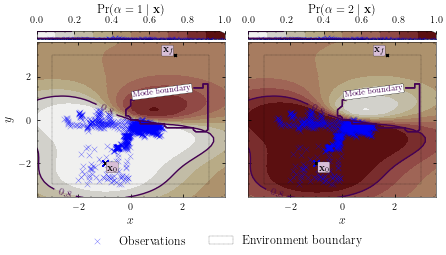

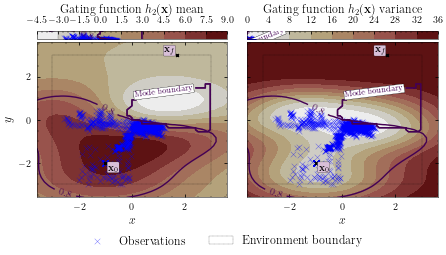

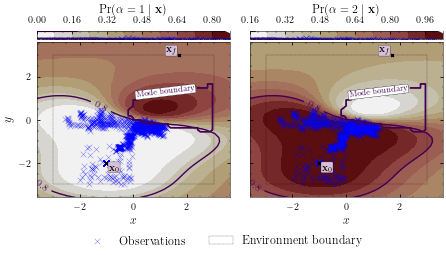

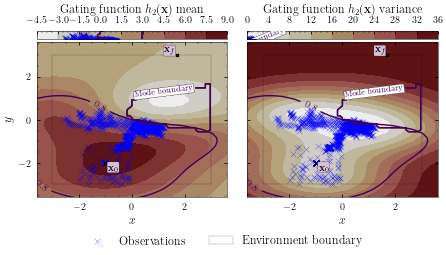

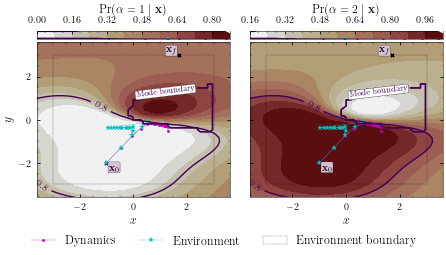

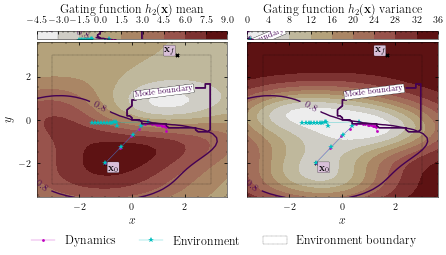

Epoch 1/10000
1/1 [==============================] - 1s 638ms/step - loss: -548.0616 - val_loss: -573.3709
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_20_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -697.8747

2022-04-08 18:53:15.358089: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 18:53:15.358105: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 3s 3s/step - loss: -697.8747 - val_loss: -722.9177
Epoch 3/10000
1/1 [==============================] - ETA: 0s - loss: -684.1094

2022-04-08 18:53:17.722899: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 18:53:17.752572: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 18:53:17.762605: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_53_17

2022-04-08 18:53:17.774267: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_53_17/dr-robots-mbp.local.trace.json.gz
2022-04-08 18:53:17.809040: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_53_17

2022-04-08 18:53:17.80933

1/1 [==============================] - 0s 69ms/step - loss: -684.1094 - val_loss: -775.8404
Epoch 4/10000
1/1 [==============================] - 0s 69ms/step - loss: -827.9657 - val_loss: -732.2803
Epoch 5/10000
1/1 [==============================] - 0s 70ms/step - loss: -699.5325 - val_loss: -650.7478
Epoch 6/10000
1/1 [==============================] - 0s 72ms/step - loss: -819.6590 - val_loss: -735.0042
Epoch 7/10000
1/1 [==============================] - 0s 80ms/step - loss: -681.2635 - val_loss: -683.5685
Epoch 8/10000
1/1 [==============================] - 0s 73ms/step - loss: -812.0270 - val_loss: -709.8969
Epoch 9/10000
1/1 [==============================] - 0s 69ms/step - loss: -749.3383 - val_loss: -709.8756
Epoch 10/10000
1/1 [==============================] - 0s 68ms/step - loss: -831.3952 - val_loss: -776.4011
Epoch 11/10000
1/1 [==============================] - 0s 66ms/step - loss: -790.2757 - val_loss: -758.5396
Epoch 12/10000
1/1 [==============================] - 0s 6

Epoch 80/10000
1/1 [==============================] - 0s 78ms/step - loss: -919.4103 - val_loss: -832.9741
Epoch 81/10000
1/1 [==============================] - 0s 80ms/step - loss: -895.0447 - val_loss: -828.6461
Epoch 82/10000
1/1 [==============================] - 0s 84ms/step - loss: -913.7028 - val_loss: -833.9666
Epoch 83/10000
1/1 [==============================] - 0s 81ms/step - loss: -918.3119 - val_loss: -821.5575
Epoch 84/10000
1/1 [==============================] - 0s 76ms/step - loss: -925.7411 - val_loss: -838.4366
Epoch 85/10000
1/1 [==============================] - 0s 79ms/step - loss: -931.8598 - val_loss: -844.7730
Epoch 86/10000
1/1 [==============================] - 0s 76ms/step - loss: -938.2236 - val_loss: -828.0243
Epoch 87/10000
1/1 [==============================] - 0s 82ms/step - loss: -931.3397 - val_loss: -844.2987
Epoch 88/10000
1/1 [==============================] - 0s 77ms/step - loss: -932.0579 - val_loss: -840.2527
Epoch 89/10000
1/1 [=================

1/1 [==============================] - 0s 78ms/step - loss: -897.9578 - val_loss: -855.4830
Epoch 157/10000
1/1 [==============================] - 0s 77ms/step - loss: -851.0565 - val_loss: -845.6033
Epoch 158/10000
1/1 [==============================] - 0s 78ms/step - loss: -903.2795 - val_loss: -847.7512
Epoch 159/10000
1/1 [==============================] - 0s 83ms/step - loss: -943.1264 - val_loss: -828.0780
Epoch 160/10000
1/1 [==============================] - 0s 77ms/step - loss: -849.0281 - val_loss: -767.4644
Epoch 161/10000
1/1 [==============================] - 0s 78ms/step - loss: -933.0573 - val_loss: -828.6757
Epoch 162/10000
1/1 [==============================] - 0s 77ms/step - loss: -285.1115 - val_loss: -787.7780
Epoch 163/10000
1/1 [==============================] - 0s 77ms/step - loss: -893.5975 - val_loss: -745.6794
Epoch 164/10000
1/1 [==============================] - 0s 76ms/step - loss: -542.1531 - val_loss: -558.9403
Epoch 165/10000
1/1 [=======================

1/1 [==============================] - 0s 91ms/step - loss: -883.5094 - val_loss: -810.1406
Epoch 233/10000
1/1 [==============================] - 0s 87ms/step - loss: -894.8116 - val_loss: -801.5711
Epoch 234/10000
1/1 [==============================] - 0s 87ms/step - loss: -888.7032 - val_loss: -796.2705
Epoch 235/10000
1/1 [==============================] - 0s 95ms/step - loss: -843.5283 - val_loss: -783.3598
Epoch 236/10000
1/1 [==============================] - 0s 87ms/step - loss: -875.2530 - val_loss: -799.7659
Epoch 237/10000
1/1 [==============================] - 0s 83ms/step - loss: -891.4980 - val_loss: -818.1917
Epoch 238/10000
1/1 [==============================] - 0s 109ms/step - loss: -859.8951 - val_loss: -792.9872
Epoch 239/10000
1/1 [==============================] - 0s 92ms/step - loss: -883.2195 - val_loss: -815.7461
Epoch 240/10000
1/1 [==============================] - 0s 96ms/step - loss: -895.0791 - val_loss: -800.3885
Epoch 241/10000
1/1 [======================

Epoch 308/10000
1/1 [==============================] - 0s 79ms/step - loss: -935.2510 - val_loss: -864.9052
Epoch 309/10000
1/1 [==============================] - 0s 84ms/step - loss: -919.4077 - val_loss: -780.8717
Epoch 310/10000
1/1 [==============================] - 0s 81ms/step - loss: -948.6819 - val_loss: -842.0861
Epoch 311/10000
1/1 [==============================] - 0s 78ms/step - loss: -910.2919 - val_loss: -832.1730
Epoch 312/10000
1/1 [==============================] - 0s 79ms/step - loss: -905.3163 - val_loss: -849.5352
Epoch 313/10000
1/1 [==============================] - 0s 80ms/step - loss: -922.1991 - val_loss: -867.3950
Epoch 314/10000
1/1 [==============================] - 0s 90ms/step - loss: -941.6646 - val_loss: -819.4969
Epoch 315/10000
1/1 [==============================] - 0s 82ms/step - loss: -913.9894 - val_loss: -858.8236
Epoch 316/10000
1/1 [==============================] - 0s 80ms/step - loss: -893.2288 - val_loss: -814.5483
Epoch 317/10000
1/1 [=======

Epoch 384/10000
1/1 [==============================] - 0s 84ms/step - loss: -505.8999 - val_loss: -721.7126
Epoch 385/10000
1/1 [==============================] - 0s 86ms/step - loss: -788.1230 - val_loss: -746.7307
Epoch 386/10000
1/1 [==============================] - 0s 82ms/step - loss: -819.3667 - val_loss: -790.4156
Epoch 387/10000
1/1 [==============================] - 0s 82ms/step - loss: -785.8150 - val_loss: -605.1366
Epoch 388/10000
1/1 [==============================] - 0s 83ms/step - loss: -763.0981 - val_loss: -734.6657
Epoch 389/10000
1/1 [==============================] - 0s 83ms/step - loss: -860.6239 - val_loss: -800.0890
Epoch 390/10000
1/1 [==============================] - 0s 86ms/step - loss: -624.9761 - val_loss: -575.5882
Epoch 391/10000
1/1 [==============================] - 0s 89ms/step - loss: -874.3043 - val_loss: -776.9450
Epoch 392/10000
1/1 [==============================] - 0s 88ms/step - loss: -702.9037 - val_loss: -615.3786
Epoch 393/10000
1/1 [=======

Epoch 460/10000
1/1 [==============================] - 0s 89ms/step - loss: -802.2637 - val_loss: -613.8560
Epoch 461/10000
1/1 [==============================] - 0s 84ms/step - loss: -742.9761 - val_loss: -670.3794
Epoch 462/10000
1/1 [==============================] - 0s 80ms/step - loss: -842.0020 - val_loss: -778.6386
Epoch 463/10000
1/1 [==============================] - 0s 83ms/step - loss: -874.4924 - val_loss: -793.5368
Epoch 464/10000
1/1 [==============================] - 0s 87ms/step - loss: -857.6882 - val_loss: -791.0611
Epoch 465/10000
1/1 [==============================] - 0s 82ms/step - loss: -826.2799 - val_loss: -732.4509
Epoch 466/10000
1/1 [==============================] - 0s 81ms/step - loss: -851.0434 - val_loss: -745.7630
Epoch 467/10000
1/1 [==============================] - 0s 85ms/step - loss: -858.8598 - val_loss: -785.2735
Epoch 468/10000
1/1 [==============================] - 0s 84ms/step - loss: -714.2247 - val_loss: -589.8677
Epoch 469/10000
1/1 [=======

Epoch 536/10000
1/1 [==============================] - 0s 85ms/step - loss: -909.9426 - val_loss: -851.3157
Epoch 537/10000
1/1 [==============================] - 0s 83ms/step - loss: -925.7505 - val_loss: -842.5730
Epoch 538/10000
1/1 [==============================] - 0s 87ms/step - loss: -914.4973 - val_loss: -824.3395
Epoch 539/10000
1/1 [==============================] - 0s 87ms/step - loss: -889.7916 - val_loss: -799.6319
Epoch 540/10000
1/1 [==============================] - 0s 86ms/step - loss: -917.4109 - val_loss: -832.9503
Epoch 541/10000
1/1 [==============================] - 0s 88ms/step - loss: -904.9244 - val_loss: -849.5058
Epoch 542/10000
1/1 [==============================] - 0s 85ms/step - loss: -929.5231 - val_loss: -841.3246
Epoch 543/10000
1/1 [==============================] - 0s 84ms/step - loss: -936.4394 - val_loss: -852.4737
Epoch 544/10000
1/1 [==============================] - 0s 84ms/step - loss: -942.0804 - val_loss: -851.2379
Epoch 545/10000
1/1 [=======

Epoch 612/10000
1/1 [==============================] - 0s 80ms/step - loss: -541.9667 - val_loss: -615.5374
Epoch 613/10000
1/1 [==============================] - 0s 76ms/step - loss: -846.2201 - val_loss: -739.8111
Epoch 614/10000
1/1 [==============================] - 0s 93ms/step - loss: -897.6337 - val_loss: -823.2357
Epoch 615/10000
1/1 [==============================] - 0s 83ms/step - loss: -817.8312 - val_loss: -791.0473
Epoch 616/10000
1/1 [==============================] - 0s 81ms/step - loss: -502.4861 - val_loss: -700.3015
Optimisation result:
     fun: 270.5463778603782
     jac: array([-2.28390747e+00, -1.34003652e+01, -2.40874040e+00, -1.38547916e+01,
       -2.48020604e+00, -1.41093777e+01, -2.49087634e+00, -1.41711530e+01,
       -2.44616515e+00, -1.40828340e+01, -2.23421741e+00, -1.30636631e+01,
       -1.93122579e+00, -1.14535001e+01, -1.63545288e+00, -9.84588236e+00,
       -1.34730068e+00, -8.23949847e+00, -1.06699537e+00, -6.63369617e+00,
       -7.95047389e-01, -5

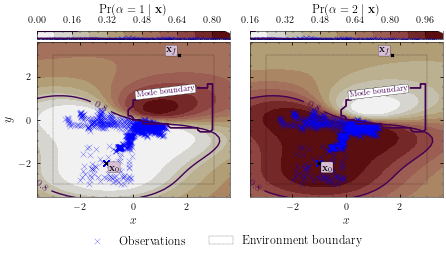

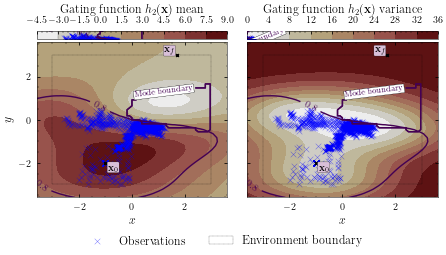

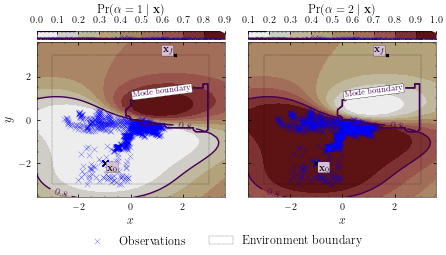

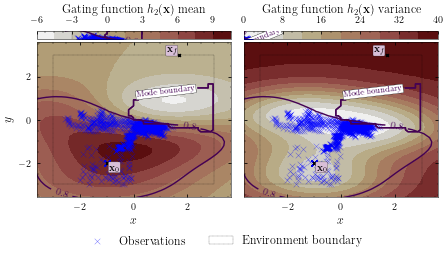

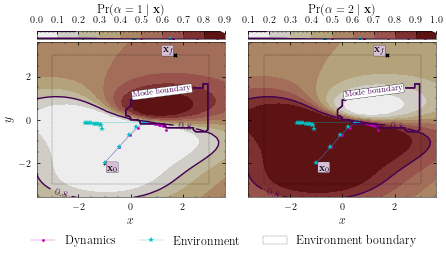

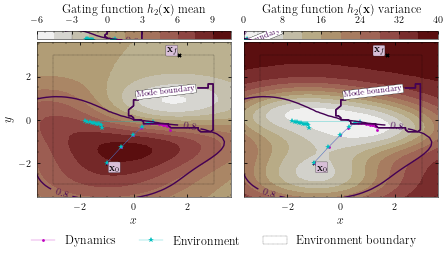

Epoch 1/10000
1/1 [==============================] - 1s 723ms/step - loss: 383.5608 - val_loss: 81.8735
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-31/ckpts/step_21_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -845.5333

2022-04-08 18:56:16.746669: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 18:56:16.746683: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-08 18:56:20.554388: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 18:56:20.570034: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 18:56:20.598809: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_56_20

2022-04-08 18:56:20.627762: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_56_20/dr-robots-mbp.local.trace.json.gz
2022-04-08 18:56:20.651120: I

ResourceExhaustedError: experiments/no-entropy-only-state-diff/explorative-prob-0.8/2022-04-08-17-31/train/plugins/profile/2022_04_08_18_56_20/dr-robots-mbp.local.xplane.pb; No space left on device

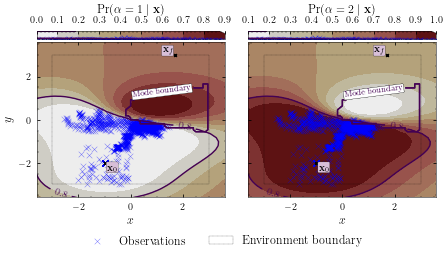

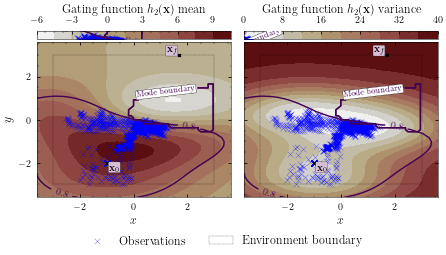

In [34]:
for step in range(1, num_steps):
    new_dataset = mode_optimiser.explore_env()
    mode_optimiser.update_dataset(new_dataset)
    mode_optimiser.dynamics_fit_kwargs.update({"batch_size": mode_optimiser.dataset[0].shape[0]})
    print("Data set size: {}".format(mode_optimiser.dataset[0].shape))
    plot_data_over_gating_network_and_save(step=step, epoch=0, save=False)
    plot_trajectories_over_gating_network_and_save(step=step, save=True)
    plt.show()
    mode_optimiser.optimise_dynamics()

In [ ]:
for step in range(num_steps, num_steps*2):
    new_dataset = mode_optimiser.explore_env()
    mode_optimiser.update_dataset(new_dataset)
    mode_optimiser.dynamics_fit_kwargs.update({"batch_size": mode_optimiser.dataset[0].shape[0]})
    print("Data set size: {}".format(mode_optimiser.dataset[0].shape))
    plot_data_over_gating_network_and_save(step=step, epoch=0, save=False)
    plot_trajectories_over_gating_network_and_save(step=step, save=True)
    plt.show()
    mode_optimiser.optimise_dynamics()

In [ ]:
# for step in range(num_steps, num_steps*2):
#     new_dataset = mode_optimiser.explore_env()
#     mode_optimiser.update_dataset(new_dataset)
#     batch_size = mode_optimiser.dataset[0].shape[0]
#     mode_optimiser.dynamics_fit_kwargs.update({"epochs": num_epochs, "batch_size": batch_size, "validation_split": 0.2})
#     print("Data set size: {}".format(mode_optimiser.dataset[0].shape))
#     plot_data_over_gating_network_and_save(step=step, epoch=0, save=False)
#     plot_trajectories_over_gating_network_and_save(step=step, save=True)
#     plt.show()
#     mode_optimiser.optimise_dynamics()

In [ ]:
state_diff_cost_matrix